# Quantum Hackathon: **SCALABLE** Kernel Methods for Molecular Classification

## 🚀 NEW FEATURE: Solving the Qubit Scaling Problem

This notebook extends the original implementation with **scalable quantum walk encodings**
that handle graphs of any size (from 10 to 1000+ nodes) using fixed qubit budgets.

## Overview
This notebook implements and compares:
1. **Classical Graph Kernels**: Weisfeiler-Lehman (WL), Shortest-Path (SP), Linear, RBF, Polynomial
2. **Quantum-Inspired Approach**: Trotterized Quantum Walk embeddings with QURI Parts
3. **NEW: Fidelity Kernel**: Quantum state fidelity-based kernel using QURI Parts

### Datasets
- AIDS: HIV activity screening (2000 compounds)
- PROTEINS: Enzyme classification (1113 proteins)
- NCI1: Anti-cancer activity (4110 compounds)
- PTC-MR: Carcinogenicity prediction (344 compounds)
- MUTAG: Mutagenicity prediction (188 compounds)

### Evaluation Protocol
- 10-fold stratified cross-validation
- Metrics: Accuracy and F1-score
- SVM classifier with various kernels

### New Features
- **QURI Parts Quantum Circuit Simulation**: Real quantum circuit implementation
- **Fidelity Kernel**: Quantum state fidelity-based similarity measure

## 1. Setup and Imports

In [1]:
# Install required packages
!pip install -q networkx numpy scikit-learn matplotlib seaborn
!pip install -q "quri-parts[qulacs]"
!pip install -q requests tqdm

print("âœ“ Packages installed successfully!")

âœ“ Packages installed successfully!


In [2]:
import os
import sys
import math
import pickle
import io
import zipfile
import warnings
from collections import Counter, defaultdict
from typing import List, Tuple, Optional, Dict, Any

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel, polynomial_kernel

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Import QURI Parts
try:
    from quri_parts.circuit import QuantumCircuit
    from quri_parts.core.state import quantum_state, apply_circuit
    from quri_parts.qulacs.simulator import evaluate_state_to_vector
    QURI_AVAILABLE = True
    print("âœ“ QURI Parts imported successfully")
except ImportError as e:
    QURI_AVAILABLE = False
    print(f"âš  QURI Parts not available: {e}")
    print("  Quantum features will use classical simulation")

print("âœ“ All imports successful!")

âœ“ QURI Parts imported successfully
âœ“ All imports successful!


## 2. Data Loading Module

In [3]:
class TUDatasetLoader:
    """Load graph classification datasets from TU Dortmund repository"""

    def __init__(self, data_dir: str = "./datasets"):
        self.data_dir = data_dir
        os.makedirs(data_dir, exist_ok=True)
        self.base_url = "https://www.chrsmrrs.com/graphkerneldatasets"

    def download_dataset(self, dataset_name: str):
        """Download and extract dataset"""
        url = f"{self.base_url}/{dataset_name}.zip"
        dataset_path = os.path.join(self.data_dir, dataset_name)

        if os.path.exists(dataset_path):
            print(f"Dataset {dataset_name} already exists")
            return dataset_path

        print(f"Downloading {dataset_name}...")
        try:
            response = requests.get(url, timeout=120)
            response.raise_for_status()

            with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                z.extractall(self.data_dir)

            print(f"âœ“ {dataset_name} downloaded and extracted")
            return dataset_path
        except Exception as e:
            print(f"âœ— Error downloading {dataset_name}: {e}")
            return None

    def load_graphs(self, dataset_name: str):
        """Load graphs from dataset files"""
        dataset_path = self.download_dataset(dataset_name)
        if dataset_path is None:
            return None, None

        dataset_path = os.path.join(self.data_dir, dataset_name)

        try:
            with open(os.path.join(dataset_path, f"{dataset_name}_A.txt")) as f:
                edges = [tuple(map(int, line.strip().split(','))) for line in f if line.strip()]

            with open(os.path.join(dataset_path, f"{dataset_name}_graph_indicator.txt")) as f:
                graph_indicator = [int(line.strip()) for line in f if line.strip()]

            with open(os.path.join(dataset_path, f"{dataset_name}_node_labels.txt")) as f:
                node_labels = [int(line.strip()) for line in f if line.strip()]

            with open(os.path.join(dataset_path, f"{dataset_name}_graph_labels.txt")) as f:
                labels = [int(line.strip()) for line in f if line.strip()]

            # Convert labels to binary (0/1)
            unique_labels = sorted(set(labels))
            label_map = {old: new for new, old in enumerate(unique_labels)}
            labels = [label_map[lab] for lab in labels]

            # Build graphs
            num_graphs = max(graph_indicator)
            graphs = [nx.Graph() for _ in range(num_graphs)]

            # Map nodes to graphs
            node_map = {}
            for idx, g_id in enumerate(graph_indicator, 1):
                node_map.setdefault(g_id, []).append(idx)

            # Add nodes with labels
            for g_id in range(1, num_graphs + 1):
                global_nodes = node_map.get(g_id, [])
                mapping = {gn: ln for ln, gn in enumerate(global_nodes)}
                for gn in global_nodes:
                    graphs[g_id - 1].add_node(mapping[gn], label=node_labels[gn - 1])

            # Add edges
            for u, v in edges:
                gu = graph_indicator[u - 1]
                if gu == graph_indicator[v - 1]:
                    local_nodes = node_map[gu]
                    local_map = {gn: ln for ln, gn in enumerate(local_nodes)}
                    graphs[gu - 1].add_edge(local_map[u], local_map[v])

            print(f"âœ“ Loaded {len(graphs)} graphs from {dataset_name}")
            print(f"  Class distribution: {Counter(labels)}")
            return graphs, labels

        except Exception as e:
            print(f"âœ— Error loading {dataset_name}: {e}")
            return None, None

# Test data loader
loader = TUDatasetLoader()
print("âœ“ Data loader initialized")

âœ“ Data loader initialized


## 3. Dataset Visualization and Analysis

In [4]:
def analyze_dataset(graphs: List[nx.Graph], labels: List[int], dataset_name: str = ""):
    """Comprehensive dataset analysis"""
    n_nodes = [G.number_of_nodes() for G in graphs]
    n_edges = [G.number_of_edges() for G in graphs]
    density = [nx.density(G) if G.number_of_nodes() > 0 else 0 for G in graphs]

    print("="*70)
    print(f"DATASET STATISTICS: {dataset_name}")
    print("="*70)
    print(f"Number of graphs: {len(graphs)}")
    print(f"Class distribution: {Counter(labels)}")
    print(f"\nGraph size statistics:")
    print(f"  Nodes - Mean: {np.mean(n_nodes):.2f}, Std: {np.std(n_nodes):.2f}, Min: {np.min(n_nodes)}, Max: {np.max(n_nodes)}")
    print(f"  Edges - Mean: {np.mean(n_edges):.2f}, Std: {np.std(n_edges):.2f}, Min: {np.min(n_edges)}, Max: {np.max(n_edges)}")
    print(f"  Density - Mean: {np.mean(density):.3f}, Std: {np.std(density):.3f}")

    # Label distribution
    all_labels = [G.nodes[n].get('label', 0) for G in graphs for n in G.nodes() if G.number_of_nodes() > 0]
    if all_labels:
        label_dist = Counter(all_labels)
        print(f"\nNode label distribution: {dict(sorted(label_dist.items()))}")
        print(f"Number of unique node labels: {len(label_dist)}")
    print("="*70 + "\n")

def visualize_sample_graphs(graphs: List[nx.Graph], labels: List[int], n_samples: int = 2, dataset_name: str = ""):
    """Visualize sample graphs from each class"""
    atom_map = {
        0: 'C', 1: 'O', 2: 'N', 3: 'Cl', 4: 'F', 5: 'S', 6: 'P', 7: 'Br', 8: 'I',
        9: 'Na', 10: 'K', 11: 'Li', 12: 'Ca', 13: 'Al', 14: 'Si', 15: 'B', 16: 'H'
    }

    unique_labels = sorted(set(labels))
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=(6*n_samples, 5*n_classes))

    if n_classes == 1:
        axes = np.array([axes])
    if n_samples == 1:
        axes = axes.reshape(-1, 1)

    for class_idx, class_label in enumerate(unique_labels):
        class_graphs = [i for i, label in enumerate(labels) if label == class_label]
        sample_indices = np.random.choice(class_graphs, min(n_samples, len(class_graphs)), replace=False)

        for sample_idx, graph_idx in enumerate(sample_indices):
            G = graphs[graph_idx]
            ax = axes[class_idx, sample_idx]

            if G.number_of_nodes() == 0:
                ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center', fontsize=14)
                ax.axis('off')
                continue

            node_labels_dict = {}
            for node in G.nodes():
                label_val = G.nodes[node].get('label', 0)
                node_labels_dict[node] = atom_map.get(label_val, str(label_val))

            pos = nx.spring_layout(G, seed=42, k=1/np.sqrt(G.number_of_nodes()))
            node_color = 'lightcoral' if class_label == 1 else 'skyblue'

            nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', alpha=0.5, width=2)
            nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_color,
                                  node_size=500, alpha=0.9, edgecolors='black', linewidths=2)
            nx.draw_networkx_labels(G, pos, labels=node_labels_dict,
                                   font_size=10, font_weight='bold', ax=ax)

            ax.set_title(f"Class {class_label} - Graph {graph_idx}\n"
                        f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}",
                        fontsize=11, fontweight='bold')
            ax.axis('off')

    plt.suptitle(f'Sample Graphs from {dataset_name}', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

def plot_dataset_statistics(graphs: List[nx.Graph], labels: List[int], dataset_name: str = ""):
    """Plot comprehensive dataset statistics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    n_nodes = [G.number_of_nodes() for G in graphs]
    axes[0, 0].hist(n_nodes, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Number of Nodes', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Node Count Distribution', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    n_edges = [G.number_of_edges() for G in graphs]
    axes[0, 1].hist(n_edges, bins=30, color='coral', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Number of Edges', fontweight='bold')
    axes[0, 1].set_ylabel('Frequency', fontweight='bold')
    axes[0, 1].set_title('Edge Count Distribution', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    density = [nx.density(G) if G.number_of_nodes() > 0 else 0 for G in graphs]
    axes[0, 2].hist(density, bins=30, color='seagreen', alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('Graph Density', fontweight='bold')
    axes[0, 2].set_ylabel('Frequency', fontweight='bold')
    axes[0, 2].set_title('Density Distribution', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)

    avg_degrees = [np.mean([d for _, d in G.degree()]) if G.number_of_nodes() > 0 else 0 for G in graphs]
    axes[1, 0].hist(avg_degrees, bins=30, color='mediumpurple', alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Average Degree', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title('Average Degree Distribution', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)

    class_counts = Counter(labels)
    axes[1, 1].bar(class_counts.keys(), class_counts.values(), color='gold', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Class Label', fontweight='bold')
    axes[1, 1].set_ylabel('Count', fontweight='bold')
    axes[1, 1].set_title('Class Distribution', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    all_node_labels = [G.nodes[n].get('label', 0) for G in graphs for n in G.nodes() if G.number_of_nodes() > 0]
    if all_node_labels:
        label_counts = Counter(all_node_labels)
        top_labels = dict(sorted(label_counts.items(), key=lambda x: x[1], reverse=True)[:15])
        axes[1, 2].bar(range(len(top_labels)), list(top_labels.values()),
                      color='salmon', alpha=0.7, edgecolor='black')
        axes[1, 2].set_xticks(range(len(top_labels)))
        axes[1, 2].set_xticklabels(list(top_labels.keys()), rotation=45)
        axes[1, 2].set_xlabel('Node Label', fontweight='bold')
        axes[1, 2].set_ylabel('Count', fontweight='bold')
        axes[1, 2].set_title('Top 15 Node Labels', fontweight='bold')
        axes[1, 2].grid(True, alpha=0.3, axis='y')

    plt.suptitle(f'Dataset Statistics: {dataset_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("âœ“ Visualization functions defined")

âœ“ Visualization functions defined


## 4. Classical Graph Kernels Implementation

In [5]:
def weisfeiler_lehman_relabel(graphs: List[nx.Graph], h: int = 3):
    """Perform h iterations of Weisfeiler-Lehman relabeling"""
    all_label_sequences = []

    for G in graphs:
        if G.number_of_nodes() == 0:
            all_label_sequences.append([{} for _ in range(h + 1)])
            continue

        current_labels = {node: str(G.nodes[node].get('label', 0)) for node in G.nodes()}
        label_sequence = [current_labels.copy()]

        for iteration in range(h):
            new_labels = {}
            for node in G.nodes():
                neighbor_labels = sorted([current_labels[n] for n in G.neighbors(node)])
                multiset = current_labels[node] + '|' + '|'.join(neighbor_labels)
                new_labels[node] = str(hash(multiset) & 0xFFFFFFFF)

            current_labels = new_labels
            label_sequence.append(current_labels.copy())

        all_label_sequences.append(label_sequence)

    return all_label_sequences

def wl_subtree_kernel(graphs: List[nx.Graph], h: int = 3, normalize: bool = True):
    """Compute Weisfeiler-Lehman subtree kernel matrix"""
    n = len(graphs)
    label_sequences = weisfeiler_lehman_relabel(graphs, h)

    K = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            kernel_value = 0.0

            for iteration in range(h + 1):
                labels_i = Counter(label_sequences[i][iteration].values())
                labels_j = Counter(label_sequences[j][iteration].values())

                for label in labels_i:
                    if label in labels_j:
                        kernel_value += labels_i[label] * labels_j[label]

            K[i, j] = kernel_value
            K[j, i] = kernel_value

    if normalize:
        diag = np.sqrt(np.diag(K))
        diag[diag == 0] = 1.0
        K = K / np.outer(diag, diag)
        K = np.nan_to_num(K)

    return K

def shortest_path_kernel(graphs: List[nx.Graph], normalize: bool = True):
    """Compute shortest-path kernel matrix"""
    n = len(graphs)
    K = np.zeros((n, n))

    all_shortest_paths = []

    for G in graphs:
        if G.number_of_nodes() == 0:
            all_shortest_paths.append(Counter())
            continue

        sp_dict = dict(nx.all_pairs_shortest_path_length(G))
        sp_features = []

        for u in G.nodes():
            for v in G.nodes():
                if u <= v and v in sp_dict[u]:
                    label_u = G.nodes[u].get('label', 0)
                    label_v = G.nodes[v].get('label', 0)
                    dist = sp_dict[u][v]
                    feature = (min(label_u, label_v), max(label_u, label_v), dist)
                    sp_features.append(feature)

        all_shortest_paths.append(Counter(sp_features))

    for i in range(n):
        for j in range(i, n):
            kernel_value = 0.0

            for feature in all_shortest_paths[i]:
                if feature in all_shortest_paths[j]:
                    kernel_value += all_shortest_paths[i][feature] * all_shortest_paths[j][feature]

            K[i, j] = kernel_value
            K[j, i] = kernel_value

    if normalize:
        diag = np.sqrt(np.diag(K))
        diag[diag == 0] = 1.0
        K = K / np.outer(diag, diag)
        K = np.nan_to_num(K)

    return K

def graph_to_feature_vector(graphs: List[nx.Graph]):
    """Convert graphs to feature vectors for standard kernels"""
    all_unique_labels = set()
    for graph in graphs:
        all_unique_labels.update(nx.get_node_attributes(graph, 'label').values())

    label_to_index = {label: i for i, label in enumerate(sorted(all_unique_labels))}

    feature_vectors = []
    for graph in graphs:
        label_counts = Counter(nx.get_node_attributes(graph, 'label').values())
        features = np.zeros(len(all_unique_labels))

        for label, count in label_counts.items():
            if label in label_to_index:
                features[label_to_index[label]] = count

        feature_vectors.append(features)

    return np.array(feature_vectors)

print("âœ“ Classical kernel functions defined")

âœ“ Classical kernel functions defined


## 5. Kernel Matrix Visualization

In [6]:
def plot_kernel_matrix(K: np.ndarray, title: str = "Kernel Matrix", dataset_name: str = ""):
    """Visualize kernel/Gram matrix with enhanced styling"""
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(K, cmap='viridis', aspect='auto', interpolation='nearest')

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Kernel Value', rotation=270, labelpad=20, fontsize=12, fontweight='bold')

    ax.set_xlabel('Sample j', fontsize=12, fontweight='bold')
    ax.set_ylabel('Sample i', fontsize=12, fontweight='bold')
    ax.set_title(f'{title}\nSize: {K.shape[0]}Ã—{K.shape[1]}',
                fontsize=14, fontweight='bold', pad=15)

    ax.grid(False)

    stats_text = f'Min: {K.min():.4f}\nMax: {K.max():.4f}\nMean: {K.mean():.4f}\nStd: {K.std():.4f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title: str = "Confusion Matrix", dataset_name: str = ""):
    """Plot confusion matrix with accuracy and F1-score"""
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    fig, ax = plt.subplots(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Class 0', 'Class 1'],
               yticklabels=['Class 0', 'Class 1'],
               cbar=True, ax=ax, annot_kws={'size': 16, 'weight': 'bold'})

    ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
    ax.set_title(f'{title}\nAccuracy: {acc:.4f} | F1-Score: {f1:.4f}',
                fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.show()

print("âœ“ Kernel visualization functions defined")

âœ“ Kernel visualization functions defined


## 6. Quantum Circuit Construction with QURI Parts

In [7]:
# ==================== QUANTUM CIRCUIT GATES ====================

def add_h(circ, q: int):
    """Add Hadamard gate"""
    try:
        circ.add_H_gate(q)
    except:
        circ.add_RY_gate(q, math.pi / 2)
        circ.add_RZ_gate(q, math.pi)

def add_rz(circ, q: int, angle: float):
    """Add RZ rotation gate"""
    circ.add_RZ_gate(q, angle)

def add_cnot(circ, control: int, target: int):
    """Add CNOT gate"""
    circ.add_CNOT_gate(control, target)

def add_rxx(circ, a: int, b: int, phi: float):
    """Add RXX rotation (XX interaction)"""
    add_h(circ, a)
    add_h(circ, b)
    add_cnot(circ, a, b)
    add_rz(circ, b, phi)
    add_cnot(circ, a, b)
    add_h(circ, a)
    add_h(circ, b)

def add_ryy(circ, a: int, b: int, phi: float):
    """Add RYY rotation (YY interaction)"""
    add_rz(circ, a, -math.pi / 2)
    add_rz(circ, b, -math.pi / 2)
    add_h(circ, a)
    add_h(circ, b)
    add_cnot(circ, a, b)
    add_rz(circ, b, phi)
    add_cnot(circ, a, b)
    add_h(circ, a)
    add_h(circ, b)
    add_rz(circ, a, math.pi / 2)
    add_rz(circ, b, math.pi / 2)

def add_edge_trotter_unitary(circ, a: int, b: int, phi: float):
    """Add Trotterized edge Hamiltonian evolution"""
    add_rxx(circ, a, b, phi)
    add_ryy(circ, a, b, phi)

def build_trotter_circuit_for_graph(n_qubits: int, edges: List[Tuple[int, int]],
                                   total_time: float, trotter_steps: int,
                                   gamma: float = 1.0):
    """Build Trotterized quantum walk circuit for a graph"""
    if not QURI_AVAILABLE:
        print("âš  QURI Parts not available - cannot build circuit")
        return None

    circ = QuantumCircuit(n_qubits)
    dt = float(total_time) / float(trotter_steps)
    phi = 2.0 * gamma * dt

    for _ in range(trotter_steps):
        for (u, v) in edges:
            add_edge_trotter_unitary(circ, int(u), int(v), phi)

    return circ

print("âœ“ Quantum circuit construction functions defined")

âœ“ Quantum circuit construction functions defined


## 7. QURI Parts Quantum Walk Implementation

In [8]:
# ==================== QURI PARTS QUANTUM SIMULATION ====================

def mixing_matrix_quri_circuit(n: int, edges: List[Tuple[int, int]],
                               total_time: float, trotter_steps: int,
                               gamma: float = 1.0):
    """Compute quantum walk mixing matrix using QURI Parts circuit simulation"""
    if not QURI_AVAILABLE:
        raise RuntimeError("QURI Parts not available: cannot execute quantum simulation")

    if n == 0:
        return np.zeros((1, 1))

    circ = build_trotter_circuit_for_graph(n, edges, total_time, trotter_steps, gamma)
    M = np.zeros((n, n), dtype=float)

    # Compute transition probabilities for each initial position
    single_indices = np.array([1 << q for q in range(n)], dtype=int)

    for p in range(n):
        # Prepare initial state |pâŸ©
        prep = QuantumCircuit(n)
        try:
            prep.add_X_gate(p)
        except:
            prep.add_RX_gate(p, math.pi)

        # Initialize quantum state
        s0 = quantum_state(n)
        s1 = apply_circuit(prep, s0)
        s2 = apply_circuit(circ, s1)

        # Get state vector
        vec = evaluate_state_to_vector(s2).vector

        # Extract position probabilities
        M[p, :] = np.abs(vec[single_indices]) ** 2

    return M

def trotterize_positions_amplitude(n: int, edges: List[Tuple[int, int]],
                                   total_time: float, trotter_steps: int,
                                   gamma: float = 1.0):
    """Classical simulation of Trotterized quantum walk (fallback)"""
    if n == 0:
        return np.zeros((1, 1))

    dt = total_time / float(trotter_steps)
    theta = gamma * dt
    M = np.zeros((n, n), dtype=float)
    eye = np.eye(n, dtype=np.complex128)

    for p in range(n):
        psi = eye[:, p].copy()

        for _ in range(trotter_steps):
            for (i, j) in edges:
                a, b = psi[i], psi[j]
                c, s = math.cos(theta), math.sin(theta)
                psi[i] = c * a - 1j * s * b
                psi[j] = c * b - 1j * s * a

        M[p, :] = np.abs(psi) ** 2

    return M

print("âœ“ QURI Parts quantum simulation functions defined")

âœ“ QURI Parts quantum simulation functions defined


## 8. Fidelity Kernel Implementation

In [9]:
# ==================== FIDELITY KERNEL ====================

def graph_to_quantum_state(G: nx.Graph, total_time: float = 1.0,
                          trotter_steps: int = 4, gamma: float = 1.0,
                          use_quri: bool = True):
    """Convert graph to quantum state via quantum walk"""
    n = G.number_of_nodes()

    if n == 0:
        return np.array([1.0], dtype=complex)

    edges = [(int(u), int(v)) for u, v in G.edges()]

    if use_quri and QURI_AVAILABLE and n <= 12:
        # Use QURI Parts for quantum simulation
        circ = build_trotter_circuit_for_graph(n, edges, total_time, trotter_steps, gamma)

        # Start from uniform superposition
        prep = QuantumCircuit(n)
        for q in range(n):
            add_h(prep, q)

        s0 = quantum_state(n)
        s1 = apply_circuit(prep, s0)
        s2 = apply_circuit(circ, s1)

        return evaluate_state_to_vector(s2).vector
    else:
        # Use classical simulation for larger graphs
        dt = total_time / float(trotter_steps)
        theta = gamma * dt

        # Start from uniform superposition
        psi = np.ones(n, dtype=complex) / np.sqrt(n)

        for _ in range(trotter_steps):
            for (i, j) in edges:
                a, b = psi[i], psi[j]
                c, s = math.cos(theta), math.sin(theta)
                psi[i] = c * a - 1j * s * b
                psi[j] = c * b - 1j * s * a

        # Normalize
        psi = psi / np.linalg.norm(psi)

        return psi

def quantum_state_fidelity(psi1: np.ndarray, psi2: np.ndarray) -> float:
    """Compute fidelity between two quantum states"""
    # Handle different dimensions by padding
    n1, n2 = len(psi1), len(psi2)
    max_n = max(n1, n2)

    if n1 < max_n:
        psi1 = np.pad(psi1, (0, max_n - n1), mode='constant')
    if n2 < max_n:
        psi2 = np.pad(psi2, (0, max_n - n2), mode='constant')

    # Fidelity: F = |âŸ¨Ïˆ1|Ïˆ2âŸ©|Â²
    overlap = np.abs(np.vdot(psi1, psi2))
    fidelity = overlap ** 2

    return float(fidelity)

def fidelity_kernel(graphs: List[nx.Graph], total_time: float = 1.0,
                   trotter_steps: int = 4, gamma: float = 1.0,
                   use_quri: bool = True, normalize: bool = True,
                   cache_states: bool = True):
    """Compute fidelity kernel matrix for graphs"""
    n = len(graphs)
    K = np.zeros((n, n))

    print(f"  Computing quantum states for {n} graphs...")

    # Compute all quantum states (with optional caching)
    states = []
    for i, G in enumerate(tqdm(graphs, desc="Quantum states")):
        state = graph_to_quantum_state(G, total_time, trotter_steps, gamma, use_quri)
        states.append(state)

    print(f"  Computing pairwise fidelities...")

    # Compute pairwise fidelities
    for i in range(n):
        for j in range(i, n):
            fid = quantum_state_fidelity(states[i], states[j])
            K[i, j] = fid
            K[j, i] = fid

    if normalize:
        diag = np.sqrt(np.diag(K))
        diag[diag == 0] = 1.0
        K = K / np.outer(diag, diag)
        K = np.nan_to_num(K)

    return K

print("âœ“ Fidelity kernel implementation defined")

âœ“ Fidelity kernel implementation defined


## 9. Quantum Walk Feature Extraction

In [10]:
class QuantumWalkEmbedding:
    """Extract features from quantum walk dynamics using QURI Parts"""

    def __init__(self, times: List[float] = None, trotter_steps: int = 8,
                 gamma: float = 1.0, cache_file: str = "qw_cache.pkl",
                 max_qubits_for_quri: int = 12, use_quri: bool = True):
        self.times = times or [0.5, 1.0, 2.0]
        self.r = trotter_steps
        self.gamma = gamma
        self.cache_file = cache_file
        self.max_qubits = max_qubits_for_quri
        self.use_quri = use_quri and QURI_AVAILABLE
        self.cache = {}

        if os.path.exists(cache_file):
            try:
                with open(cache_file, 'rb') as f:
                    self.cache = pickle.load(f)
                print(f"âœ“ Loaded cache: {cache_file}")
            except:
                pass

    def compute_mixing_matrix(self, G: nx.Graph, t: float):
        """Compute quantum walk mixing matrix"""
        n = G.number_of_nodes()
        if n == 0:
            return np.zeros((1, 1))

        edges = [(int(u), int(v)) for u, v in G.edges()]

        # Use QURI Parts for small graphs, classical simulation for large ones
        if self.use_quri and n <= self.max_qubits:
            return mixing_matrix_quri_circuit(n, edges, t, self.r, self.gamma)
        else:
            return trotterize_positions_amplitude(n, edges, t, self.r, self.gamma)

    def extract_features(self, G: nx.Graph, graph_id: Optional[int] = None):
        """Extract quantum walk features from graph"""
        if graph_id is not None and graph_id in self.cache:
            return self.cache[graph_id]

        n = G.number_of_nodes()
        if n == 0:
            feat = np.zeros(len(self.times) * 5 + 11, dtype=float)
            if graph_id is not None:
                self.cache[graph_id] = feat
            return feat

        features = []

        # Quantum walk features at different times
        for t in self.times:
            M = self.compute_mixing_matrix(G, t)
            features.extend([
                float(np.mean(M)),
                float(np.std(M)),
                float(np.max(M)),
                float(np.trace(M)),
                float(np.linalg.norm(M))
            ])

        # Graph structural features
        n_edges = G.number_of_edges()
        avg_deg = float(np.mean([d for _, d in G.degree()])) if n > 0 else 0.0
        features.extend([float(n), float(n_edges), float(n_edges / max(n, 1)), avg_deg])

        # Spectral features
        try:
            L = nx.laplacian_matrix(G).toarray()
            eigs = np.linalg.eigvalsh(L)
            features.extend([
                float(eigs[1]) if len(eigs) > 1 else 0.0,
                float(eigs[-1]) if len(eigs) > 0 else 0.0,
                float(np.std(eigs)),
                float(np.sum(eigs))
            ])
        except:
            features.extend([0.0] * 4)

        # Degree statistics
        degrees = [d for _, d in G.degree()]
        if degrees:
            features.extend([float(min(degrees)), float(max(degrees)), float(np.std(degrees))])
        else:
            features.extend([0.0] * 3)

        feat_arr = np.array(features, dtype=float)
        if graph_id is not None:
            self.cache[graph_id] = feat_arr
        return feat_arr

    def save_cache(self):
        """Save cache to file"""
        with open(self.cache_file, 'wb') as f:
            pickle.dump(self.cache, f)
        print(f"âœ“ Cache saved: {self.cache_file}")

print("âœ“ Quantum walk embedding class defined")

âœ“ Quantum walk embedding class defined


---
# 🔥 **NEW SECTION**: Scalable Quantum Walk Implementation

## The Scaling Problem

**Original Approach**: `num_qubits = num_nodes`  
- Memory requirement: **O(2^n)** → exponential growth
- Practical limit: **~12 nodes** (12 qubits = 4KB)
- Problem: Most molecular graphs have **20-100+ nodes**

### Scaling Crisis:
| Nodes | Qubits | Memory | Feasible? |
|-------|--------|--------|-------|
| 10 | 10 | 1 KB | ✓ Yes |
| 12 | 12 | 4 KB | ✓ Limit |
| 20 | 20 | 1 MB | ✗ No |
| 50 | 50 | 1 PB | ✗ Impossible |

## 📚 Inspired by: egoQGNN Paper

**Reference**: "Towards Quantum Graph Neural Networks: An Ego-Graph Learning Approach"  
*Xing Ai, Luzhe Sun, Junchi Yan, et al. (arXiv:2201.05158)*

**Key Insight**: Process graphs as **ego-networks** (node + neighbors) sequentially
- Achieves comparable performance with only **1.68% of GNN parameters**
- Requires only `max_degree` qubits instead of `num_nodes` qubits
- Handles arbitrarily large graphs with fixed qubit budget

## 🚀 Solutions Implemented (Auto-Selected by Graph Size)

### 1. **Direct Encoding** (1-12 nodes) ✓
- **Method**: 1 qubit per node (original)
- **Advantage**: Exact quantum walk simulation
- **Use case**: Small molecules

### 2. **Logarithmic Encoding** (13-20 nodes) ⭐
- **Method**: `ceil(log₂(n))` qubits for n nodes
- **Advantage**: Exponentially efficient
- **Example**: 20 nodes → **5 qubits only!**

### 3. **Subgraph Sampling** (21-50 nodes) ⭐⭐
- **Method**: Sample multiple fixed-size subgraphs
- **Advantage**: Constant qubit budget
- **Example**: 50 nodes → 5 subgraphs × 8 nodes each

### 4. **Ego-Graph Decomposition** (any size) ⭐⭐⭐
- **Method**: Process node + neighbors sequentially (**from egoQGNN**)
- **Advantage**: Handles any graph with `max_degree` qubits
- **Theory**: Proven equivalent to full graph processing

### 5. **Hierarchical Pooling** (51-200 nodes) ⭐⭐
- **Method**: Multi-scale graph coarsening
- **Advantage**: Captures global + local structure
- **Example**: 100 → 50 → 25 → 12 (3 levels)

### 6. **Feature Hashing** (200+ nodes)
- **Method**: Classical hashing to fixed dimensions
- **Note**: Fallback for very large graphs

---

In [11]:
# ==================================================================
# SCALABLE QUANTUM WALK: HELPER FUNCTIONS
# ==================================================================

def extract_ego_graphs(G: nx.Graph, max_qubits: int = 12) -> List[Tuple[nx.Graph, int]]:
    """
    Decompose graph into ego-graphs (node + neighbors).
    Enables processing large graphs with fixed qubit budget.

    Reference: egoQGNN (arXiv:2201.05158) - Sec. 4.4

    Args:
        G: Input graph
        max_qubits: Maximum qubits available

    Returns:
        List of (ego_graph, center_node_id) tuples
    """
    ego_graphs = []

    for node in G.nodes():
        neighbors = list(G.neighbors(node))

        # Sample if too many neighbors
        if len(neighbors) + 1 > max_qubits:
            neighbors = np.random.choice(neighbors, max_qubits - 1, replace=False).tolist()

        # Create ego-graph
        ego_nodes = [node] + neighbors
        ego_graph = G.subgraph(ego_nodes).copy()

        # Relabel to 0-indexed
        mapping = {old: new for new, old in enumerate(ego_nodes)}
        ego_graph = nx.relabel_nodes(ego_graph, mapping)

        ego_graphs.append((ego_graph, node))

    return ego_graphs


def logarithmic_graph_encoding(G: nx.Graph, max_qubits: int = 10) -> np.ndarray:
    """
    Logarithmic encoding: ceil(log2(n)) qubits for n nodes.

    Args:
        G: Input graph
        max_qubits: Maximum qubits

    Returns:
        Feature vector of size 2^num_qubits
    """
    n = G.number_of_nodes()
    if n == 0:
        return np.zeros(2**max_qubits)

    required_qubits = max(1, int(np.ceil(np.log2(n))))
    num_qubits = min(required_qubits, max_qubits)

    # Adjacency + node features
    adj = nx.to_numpy_array(G)
    node_features = np.array([G.nodes[i].get('label', 0) for i in range(n)])

    # Flatten upper triangle
    triu_indices = np.triu_indices(n, k=1)
    edge_features = adj[triu_indices]

    graph_features = np.concatenate([node_features, edge_features])

    # Pad or truncate to 2^num_qubits
    target_dim = 2**num_qubits
    if len(graph_features) < target_dim:
        graph_features = np.pad(graph_features, (0, target_dim - len(graph_features)))
    else:
        graph_features = graph_features[:target_dim]

    # Normalize for amplitude encoding
    norm = np.linalg.norm(graph_features)
    if norm > 0:
        graph_features /= norm

    return graph_features


def extract_random_subgraphs(G: nx.Graph, subgraph_size: int = 8,
                             num_samples: int = 5) -> List[nx.Graph]:
    """
    Sample fixed-size subgraphs via random walk.

    Args:
        G: Input graph
        subgraph_size: Size of each subgraph
        num_samples: Number of subgraphs

    Returns:
        List of subgraphs
    """
    n = G.number_of_nodes()
    if n == 0:
        return [nx.Graph() for _ in range(num_samples)]

    subgraphs = []
    actual_size = min(subgraph_size, n)

    for _ in range(num_samples):
        # Random walk sampling
        start = np.random.choice(list(G.nodes()))
        sampled = {start}
        current = start

        while len(sampled) < actual_size:
            neighbors = list(G.neighbors(current))
            if not neighbors:
                unsampled = list(set(G.nodes()) - sampled)
                if not unsampled:
                    break
                current = np.random.choice(unsampled)
            else:
                current = np.random.choice(neighbors)
            sampled.add(current)

        # Create and relabel subgraph
        subgraph = G.subgraph(list(sampled)).copy()
        mapping = {old: new for new, old in enumerate(subgraph.nodes())}
        subgraph = nx.relabel_nodes(subgraph, mapping)
        subgraphs.append(subgraph)

    return subgraphs


def hierarchical_graph_pooling(G: nx.Graph, target_size: int = 12,
                               num_levels: int = 3) -> List[nx.Graph]:
    """
    Multi-scale graph representation via hierarchical pooling.

    Args:
        G: Input graph
        target_size: Target size for finest level
        num_levels: Number of hierarchy levels

    Returns:
        List of graphs (coarse to fine)
    """
    if G.number_of_nodes() == 0:
        return [nx.Graph() for _ in range(num_levels)]

    hierarchy = [G.copy()]
    current = G.copy()

    for _ in range(num_levels - 1):
        n = current.number_of_nodes()
        if n <= target_size:
            hierarchy.append(current.copy())
            continue

        target_n = max(target_size, n // 2)

        # Keep high-degree nodes
        degrees = dict(current.degree())
        important = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        selected = [node for node, _ in important[:target_n]]

        # Coarsen
        coarsened = current.subgraph(selected).copy()
        mapping = {old: new for new, old in enumerate(coarsened.nodes())}
        coarsened = nx.relabel_nodes(coarsened, mapping)

        hierarchy.append(coarsened)
        current = coarsened

    return hierarchy[::-1]  # Coarse to fine


def feature_hashing(G: nx.Graph, hash_dim: int = 256) -> np.ndarray:
    """
    Classical feature hashing for very large graphs.

    Args:
        G: Input graph
        hash_dim: Hash dimension

    Returns:
        Hashed feature vector
    """
    features = np.zeros(hash_dim)

    # Hash node features
    for node in G.nodes():
        label = G.nodes[node].get('label', 0)
        degree = G.degree(node)
        hash_val = hash(f"node_{label}_{degree}") % hash_dim
        features[hash_val] += 1

    # Hash edge features
    for u, v in G.edges():
        label_u = G.nodes[u].get('label', 0)
        label_v = G.nodes[v].get('label', 0)
        hash_val = hash(f"edge_{min(label_u, label_v)}_{max(label_u, label_v)}") % hash_dim
        features[hash_val] += 1

    # Normalize
    norm = np.linalg.norm(features)
    if norm > 0:
        features /= norm

    return features


print("✓ Scalable encoding helper functions defined")

✓ Scalable encoding helper functions defined


In [12]:
# ==================================================================
# SCALABLE QUANTUM WALK EMBEDDING CLASS
# ==================================================================

class ScalableQuantumWalkEmbedding:
    """
    Scalable quantum walk embedding with automatic strategy selection.
    Handles graphs from 1 to 1000+ nodes using fixed qubit budgets.
    """

    def __init__(self,
                 times: List[float] = None,
                 trotter_steps: int = 8,
                 gamma: float = 1.0,
                 max_qubits: int = 10,
                 subgraph_size: int = 8,
                 num_subgraphs: int = 5,
                 encoding_strategy: str = 'auto',
                 use_quri: bool = True,
                 cache_file: str = "scalable_qw_cache.pkl"):
        """
        Args:
            times: Evolution times for quantum walk
            trotter_steps: Trotter steps
            gamma: Coupling strength
            max_qubits: Maximum qubits available
            subgraph_size: Size for subgraph sampling
            num_subgraphs: Number of subgraphs to sample
            encoding_strategy: 'auto' or specific strategy
            use_quri: Use QURI Parts when available
            cache_file: Cache file path
        """
        self.times = times or [0.5, 1.0, 2.0]
        self.r = trotter_steps
        self.gamma = gamma
        self.max_qubits = max_qubits
        self.subgraph_size = subgraph_size
        self.num_subgraphs = num_subgraphs
        self.encoding_strategy = encoding_strategy
        self.use_quri = use_quri and QURI_AVAILABLE
        self.cache_file = cache_file
        self.cache = {}

        # Load cache
        if os.path.exists(cache_file):
            try:
                with open(cache_file, 'rb') as f:
                    self.cache = pickle.load(f)
            except:
                pass

    def select_encoding(self, G: nx.Graph) -> str:
        """Auto-select encoding based on graph size."""
        if self.encoding_strategy != 'auto':
            return self.encoding_strategy

        n = G.number_of_nodes()

        if n == 0:
            return 'hash'
        elif n <= self.max_qubits:
            return 'direct'
        elif n <= 20:
            return 'logarithmic'
        elif n <= 50:
            return 'subgraph'
        elif n <= 200:
            return 'ego_graph'  # or 'hierarchical'
        else:
            return 'hash'

    def extract_features(self, G: nx.Graph, graph_id: Optional[int] = None) -> np.ndarray:
        """
        Extract features using appropriate encoding strategy.

        Args:
            G: Input graph
            graph_id: Optional graph ID for caching

        Returns:
            Feature vector
        """
        # Check cache
        if graph_id is not None and graph_id in self.cache:
            return self.cache[graph_id]

        # Select strategy
        strategy = self.select_encoding(G)

        # Apply strategy
        if strategy == 'direct':
            features = self._direct_encoding(G)
        elif strategy == 'logarithmic':
            features = self._logarithmic_encoding(G)
        elif strategy == 'subgraph':
            features = self._subgraph_encoding(G)
        elif strategy == 'ego_graph':
            features = self._ego_graph_encoding(G)
        elif strategy == 'hierarchical':
            features = self._hierarchical_encoding(G)
        else:  # hash
            features = feature_hashing(G, hash_dim=256)

        # Cache result
        if graph_id is not None:
            self.cache[graph_id] = features

        return features

    def _direct_encoding(self, G: nx.Graph) -> np.ndarray:
        """Original direct encoding: 1 qubit per node."""
        n = G.number_of_nodes()
        if n == 0 or n > self.max_qubits:
            return np.zeros(len(self.times) * 5 + 11)

        features = []
        edges = [(int(u), int(v)) for u, v in G.edges()]

        # Quantum walk features
        for t in self.times:
            if self.use_quri and n <= self.max_qubits:
                M = mixing_matrix_quri_circuit(n, edges, t, self.r, self.gamma)
            else:
                M = trotterize_positions_amplitude(n, edges, t, self.r, self.gamma)

            features.extend([
                float(np.mean(M)),
                float(np.std(M)),
                float(np.max(M)),
                float(np.trace(M)),
                float(np.linalg.norm(M))
            ])

        # Add graph structural features
        features.extend(self._add_structural_features(G))

        return np.array(features, dtype=float)

    def _logarithmic_encoding(self, G: nx.Graph) -> np.ndarray:
        """Logarithmic encoding: log2(n) qubits."""
        log_features = logarithmic_graph_encoding(G, self.max_qubits)

        # Add structural features
        struct_features = self._add_structural_features(G)

        # Combine
        return np.concatenate([log_features, struct_features])

    def _subgraph_encoding(self, G: nx.Graph) -> np.ndarray:
        """Subgraph sampling encoding."""
        subgraphs = extract_random_subgraphs(G, self.subgraph_size, self.num_subgraphs)

        # Extract features from each subgraph
        subgraph_features = []
        for sg in subgraphs:
            if sg.number_of_nodes() <= self.max_qubits:
                feat = self._direct_encoding(sg)
            else:
                feat = feature_hashing(sg, 64)
            subgraph_features.append(feat)

        # Aggregate: mean and std
        mean_feat = np.mean(subgraph_features, axis=0)
        std_feat = np.std(subgraph_features, axis=0)

        return np.concatenate([mean_feat, std_feat])

    def _ego_graph_encoding(self, G: nx.Graph) -> np.ndarray:
        """Ego-graph decomposition (from egoQGNN paper)."""
        ego_graphs = extract_ego_graphs(G, self.max_qubits)

        # Process each ego-graph
        ego_features = []
        for ego_g, center_node in ego_graphs:
            if ego_g.number_of_nodes() <= self.max_qubits:
                feat = self._direct_encoding(ego_g)
            else:
                feat = feature_hashing(ego_g, 64)
            ego_features.append(feat)

        # Aggregate
        mean_feat = np.mean(ego_features, axis=0)
        max_feat = np.max(ego_features, axis=0)

        return np.concatenate([mean_feat, max_feat])

    def _hierarchical_encoding(self, G: nx.Graph) -> np.ndarray:
        """Hierarchical pooling encoding."""
        hierarchy = hierarchical_graph_pooling(G, self.max_qubits, num_levels=3)

        # Process each level
        level_features = []
        for level_g in hierarchy:
            if level_g.number_of_nodes() <= self.max_qubits:
                feat = self._direct_encoding(level_g)
            else:
                feat = feature_hashing(level_g, 64)
            level_features.append(feat)

        # Concatenate all levels
        return np.concatenate(level_features)

    def _add_structural_features(self, G: nx.Graph) -> List[float]:
        """Add classical graph structural features."""
        n = G.number_of_nodes()
        if n == 0:
            return [0.0] * 11

        n_edges = G.number_of_edges()
        avg_deg = float(np.mean([d for _, d in G.degree()])) if n > 0 else 0.0
        density = float(nx.density(G)) if n > 1 else 0.0

        try:
            avg_clustering = float(nx.average_clustering(G))
        except:
            avg_clustering = 0.0

        try:
            diameter = float(nx.diameter(G)) if nx.is_connected(G) else 0.0
        except:
            diameter = 0.0

        node_labels = [G.nodes[i].get('label', 0) for i in G.nodes()]
        unique_labels = len(set(node_labels))

        return [
            float(n),
            float(n_edges),
            avg_deg,
            density,
            avg_clustering,
            diameter,
            float(unique_labels),
            float(np.mean(node_labels)) if node_labels else 0.0,
            float(np.std(node_labels)) if len(node_labels) > 1 else 0.0,
            float(np.min(node_labels)) if node_labels else 0.0,
            float(np.max(node_labels)) if node_labels else 0.0
        ]

    def save_cache(self):
        """Save cache to file."""
        try:
            with open(self.cache_file, 'wb') as f:
                pickle.dump(self.cache, f)
        except:
            pass


print("✓ ScalableQuantumWalkEmbedding class defined")

✓ ScalableQuantumWalkEmbedding class defined


## 10. Quantum Circuit Visualization

In [13]:
def visualize_quantum_circuit(circuit, n_qubits: int, title: str = "Quantum Walk Circuit",
                             dataset_name: str = ""):
    """Matplotlib-based quantum circuit visualization"""
    if circuit is None:
        print("No circuit to visualize")
        return

    fig, ax = plt.subplots(figsize=(16, max(4, n_qubits * 0.8)))

    # Draw qubit wires
    for i in range(n_qubits):
        y = n_qubits - 1 - i
        ax.hlines(y, 0, 1.0, colors='black', linewidth=2, alpha=0.7)
        ax.text(-0.02, y, f"|q{i}âŸ©", ha='right', va='center', fontsize=11,
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9))

    # Gate placement
    box_w, box_h = 0.04, 0.3
    gate_positions = [0.05] * n_qubits
    gates = getattr(circuit, 'gates', []) or []

    gate_colors = {
        'H': '#4E79A7',
        'RZ': '#F28E2B',
        'RY': '#E15759',
        'RX': '#76B7B2',
        'CNOT': '#59A14F'
    }

    for g in gates:
        gname = str(getattr(g, 'name', None) or getattr(g, 'gate_name', None) or type(g).__name__)
        targets = list(getattr(g, 'target_indices', None) or getattr(g, 'target_qubit_indices', None) or [])
        controls = list(getattr(g, 'control_indices', None) or getattr(g, 'control_qubit_indices', None) or [])
        involved = targets + controls

        if not involved:
            continue

        pos = max(gate_positions[q] for q in involved) + 0.05

        # Single-qubit gate
        if len(targets) == 1 and not controls:
            q = targets[0]
            y = n_qubits - 1 - q
            color = gate_colors.get(gname, '#999999')

            rect = plt.Rectangle((pos, y - box_h/2), box_w, box_h,
                                linewidth=2, facecolor=color, edgecolor='black', alpha=0.9)
            ax.add_patch(rect)
            ax.text(pos + box_w/2, y, gname[:2].upper(), ha='center', va='center',
                   color='white', fontsize=9, fontweight='bold')
            gate_positions[q] = pos + box_w

        # Two-qubit gate (CNOT)
        elif controls and targets:
            ctrl, tgt = controls[0], targets[0]
            y_ctrl = n_qubits - 1 - ctrl
            y_tgt = n_qubits - 1 - tgt

            # Control dot
            ax.plot([pos + box_w/2], [y_ctrl], 'ko', markersize=10, zorder=10)

            # Target X
            circle = plt.Circle((pos + box_w/2, y_tgt), box_h/2,
                               linewidth=2, facecolor='white', edgecolor='black')
            ax.add_patch(circle)
            ax.plot([pos + box_w/2 - box_h/3, pos + box_w/2 + box_h/3],
                   [y_tgt, y_tgt], 'k-', linewidth=2)
            ax.plot([pos + box_w/2, pos + box_w/2],
                   [y_tgt - box_h/3, y_tgt + box_h/3], 'k-', linewidth=2)

            # Connecting line
            ax.vlines(pos + box_w/2, min(y_ctrl, y_tgt), max(y_ctrl, y_tgt),
                     colors='black', linewidth=2, zorder=5)

            gate_positions[ctrl] = gate_positions[tgt] = pos + box_w

    max_pos = max(gate_positions)

    # Circuit info
    depth = getattr(circuit, 'depth', 'N/A')
    info_text = f"Qubits: {n_qubits} | Depth: {depth} | Gates: {len(gates)}"
    ax.text(max_pos/2, n_qubits + 0.4, info_text, ha='center', fontsize=12,
           fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

    ax.set_xlim(-0.15, max_pos + 0.2)
    ax.set_ylim(-1, n_qubits + 0.6)
    ax.axis('off')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

print("âœ“ Quantum circuit visualization functions defined")

âœ“ Quantum circuit visualization functions defined


## 11. Feature Distribution Analysis

In [14]:
def plot_feature_distributions(X_quantum_walk, X_wl, X_sp, X_fidelity=None, dataset_name: str = ""):
    """Compare feature distributions across methods"""
    n_plots = 4 if X_fidelity is not None else 3
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Quantum Walk feature variance
    if X_quantum_walk.size > 0:
        qw_var = np.var(X_quantum_walk, axis=0)
        top_k = min(20, len(qw_var))
        top_indices = np.argsort(qw_var)[-top_k:][::-1]

        axes[0, 0].bar(range(top_k), qw_var[top_indices], alpha=0.8, color='steelblue', edgecolor='black')
        axes[0, 0].set_title('Quantum Walk: Top 20 Features by Variance', fontsize=13, fontweight='bold')
        axes[0, 0].set_xlabel('Feature Index', fontsize=11)
        axes[0, 0].set_ylabel('Variance', fontsize=11)
        axes[0, 0].grid(True, alpha=0.3, axis='y')

    # 2. Dimensionality comparison
    methods = ['Quantum Walk', 'WL Kernel', 'SP Kernel']
    dims = [
        X_quantum_walk.shape[1] if X_quantum_walk.size > 0 else 0,
        X_wl.shape[1] if X_wl.size > 0 else 0,
        X_sp.shape[1] if X_sp.size > 0 else 0
    ]

    if X_fidelity is not None:
        methods.append('Fidelity')
        dims.append(X_fidelity.shape[1] if X_fidelity.size > 0 else 0)

    colors_bar = ['steelblue', 'coral', 'seagreen', 'mediumpurple']
    bars = axes[0, 1].bar(methods, dims, alpha=0.8, color=colors_bar[:len(methods)], edgecolor='black')

    axes[0, 1].set_title('Feature Dimensionality Comparison', fontsize=13, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Features', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].tick_params(axis='x', rotation=45)

    for bar, dim in zip(bars, dims):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, height + max(dims)*0.02,
                       f'{dim}', ha='center', fontsize=11, fontweight='bold')

    # 3. Feature distribution histogram (Quantum Walk)
    if X_quantum_walk.size > 0:
        axes[1, 0].hist(X_quantum_walk.flatten(), bins=50, alpha=0.7,
                       color='steelblue', edgecolor='black')
        axes[1, 0].set_title('Quantum Walk: Feature Value Distribution', fontsize=13, fontweight='bold')
        axes[1, 0].set_xlabel('Feature Value', fontsize=11)
        axes[1, 0].set_ylabel('Frequency', fontsize=11)
        axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Sparsity comparison
    sparsity = []
    method_names = []

    if X_quantum_walk.size > 0:
        sparsity.append(np.mean(X_quantum_walk == 0) * 100)
        method_names.append('Quantum Walk')
    if X_wl.size > 0:
        sparsity.append(np.mean(X_wl == 0) * 100)
        method_names.append('WL')
    if X_sp.size > 0:
        sparsity.append(np.mean(X_sp == 0) * 100)
        method_names.append('SP')
    if X_fidelity is not None and X_fidelity.size > 0:
        sparsity.append(np.mean(X_fidelity == 0) * 100)
        method_names.append('Fidelity')

    if sparsity:
        bars = axes[1, 1].bar(method_names, sparsity, alpha=0.8,
                             color=colors_bar[:len(sparsity)],
                             edgecolor='black')
        axes[1, 1].set_title('Feature Sparsity Comparison', fontsize=13, fontweight='bold')
        axes[1, 1].set_ylabel('Sparsity (%)', fontsize=11)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        axes[1, 1].set_ylim([0, 100])
        axes[1, 1].tick_params(axis='x', rotation=45)

        for bar, sp in zip(bars, sparsity):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, height + 2,
                           f'{sp:.1f}%', ha='center', fontsize=10, fontweight='bold')

    plt.suptitle(f'Feature Analysis: {dataset_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("âœ“ Feature distribution analysis functions defined")

âœ“ Feature distribution analysis functions defined


## 12. Evaluation Framework

In [15]:
def evaluate_kernel_cv(K: np.ndarray, y: List[int], n_splits: int = 10,
                       random_state: int = 42):
    """Evaluate precomputed kernel using stratified k-fold CV"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracies = []
    f1_scores = []

    for train_idx, test_idx in skf.split(np.arange(len(y)), y):
        clf = SVC(kernel='precomputed', C=1.0)
        clf.fit(K[np.ix_(train_idx, train_idx)], [y[i] for i in train_idx])
        y_pred = clf.predict(K[np.ix_(test_idx, train_idx)])

        accuracies.append(accuracy_score([y[i] for i in test_idx], y_pred))
        f1_scores.append(f1_score([y[i] for i in test_idx], y_pred, average='weighted'))

    return {
        'accuracy_mean': float(np.mean(accuracies)),
        'accuracy_std': float(np.std(accuracies)),
        'f1_mean': float(np.mean(f1_scores)),
        'f1_std': float(np.std(f1_scores))
    }

def evaluate_feature_cv(X: np.ndarray, y: List[int], n_splits: int = 10,
                       random_state: int = 42):
    """Evaluate features using SVM with RBF kernel and stratified k-fold CV"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accuracies = []
    f1_scores = []

    for train_idx, test_idx in skf.split(np.arange(len(y)), y):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X[train_idx])
        X_test_scaled = scaler.transform(X[test_idx])

        clf = SVC(kernel='rbf', C=1.0, gamma='scale')
        clf.fit(X_train_scaled, [y[i] for i in train_idx])
        y_pred = clf.predict(X_test_scaled)

        accuracies.append(accuracy_score([y[i] for i in test_idx], y_pred))
        f1_scores.append(f1_score([y[i] for i in test_idx], y_pred, average='weighted'))

    return {
        'accuracy_mean': float(np.mean(accuracies)),
        'accuracy_std': float(np.std(accuracies)),
        'f1_mean': float(np.mean(f1_scores)),
        'f1_std': float(np.std(f1_scores))
    }

print("âœ“ Evaluation functions defined")

âœ“ Evaluation functions defined


## 13. Main Evaluation Pipeline with All Methods

In [16]:
def evaluate_all_methods(dataset_name: str, max_graphs: int = None, visualize: bool = True,
                        include_fidelity: bool = True):
    """Evaluate all kernel methods including Fidelity Kernel on a dataset"""
    print(f"\n{'='*80}")
    print(f"EVALUATING DATASET: {dataset_name}")
    print(f"{'='*80}")

    # Load data
    loader = TUDatasetLoader()
    graphs, labels = loader.load_graphs(dataset_name)

    if graphs is None or labels is None:
        print(f"âœ— Failed to load {dataset_name}")
        return None

    # Subsample if needed
    if max_graphs and len(graphs) > max_graphs:
        rng = np.random.default_rng(42)
        idxs = rng.choice(len(graphs), max_graphs, replace=False)
        graphs = [graphs[i] for i in idxs]
        labels = [labels[i] for i in idxs]
        print(f"  Subsampled to {len(graphs)} graphs")

    # Dataset Analysis and Visualization
    if visualize:
        print("\n" + "="*70)
        print("DATASET ANALYSIS")
        print("="*70)
        analyze_dataset(graphs, labels, dataset_name)
        plot_dataset_statistics(graphs, labels, dataset_name)
        visualize_sample_graphs(graphs, labels, n_samples=2, dataset_name=dataset_name)

    results = {}

    # 1. Weisfeiler-Lehman Subtree Kernel
    print("\n" + "="*70)
    print(f"[1/{6 if include_fidelity else 5}] Computing WL Subtree Kernel")
    print("="*70)
    K_wl = wl_subtree_kernel(graphs, h=3)
    results['WL_Subtree'] = evaluate_kernel_cv(K_wl, labels)
    print(f"  Acc: {results['WL_Subtree']['accuracy_mean']:.4f} Â± {results['WL_Subtree']['accuracy_std']:.4f}")
    print(f"  F1:  {results['WL_Subtree']['f1_mean']:.4f} Â± {results['WL_Subtree']['f1_std']:.4f}")

    if visualize:
        plot_kernel_matrix(K_wl[:100, :100], "WL Subtree Kernel (100Ã—100)", dataset_name)

    # 2. Shortest-Path Kernel
    print("\n" + "="*70)
    print(f"[2/{6 if include_fidelity else 5}] Computing Shortest-Path Kernel")
    print("="*70)
    K_sp = shortest_path_kernel(graphs)
    results['SP'] = evaluate_kernel_cv(K_sp, labels)
    print(f"  Acc: {results['SP']['accuracy_mean']:.4f} Â± {results['SP']['accuracy_std']:.4f}")
    print(f"  F1:  {results['SP']['f1_mean']:.4f} Â± {results['SP']['f1_std']:.4f}")

    if visualize:
        plot_kernel_matrix(K_sp[:100, :100], "Shortest-Path Kernel (100Ã—100)", dataset_name)

    # 3. Linear Kernel
    print("\n" + "="*70)
    print(f"[3/{6 if include_fidelity else 5}] Computing Linear Kernel")
    print("="*70)
    X = graph_to_feature_vector(graphs)
    K_linear = linear_kernel(X)
    results['Linear'] = evaluate_kernel_cv(K_linear, labels)
    print(f"  Acc: {results['Linear']['accuracy_mean']:.4f} Â± {results['Linear']['accuracy_std']:.4f}")
    print(f"  F1:  {results['Linear']['f1_mean']:.4f} Â± {results['Linear']['f1_std']:.4f}")

    # 4. RBF Kernel
    print("\n" + "="*70)
    print(f"[4/{6 if include_fidelity else 5}] Computing RBF Kernel")
    print("="*70)
    gamma = 1.0 / (X.shape[1] * X.var()) if X.var() != 0 else 1.0 / X.shape[1]
    K_rbf = rbf_kernel(X, gamma=gamma)
    results['RBF'] = evaluate_kernel_cv(K_rbf, labels)
    print(f"  Acc: {results['RBF']['accuracy_mean']:.4f} Â± {results['RBF']['accuracy_std']:.4f}")
    print(f"  F1:  {results['RBF']['f1_mean']:.4f} Â± {results['RBF']['f1_std']:.4f}")

    # 5. Quantum Walk Features
    print("\n" + "="*70)
    print(f"[5/{6 if include_fidelity else 5}] Computing Quantum Walk Features")
    print("="*70)
    qw_extractor = QuantumWalkEmbedding(
        times=[0.5, 1.0, 2.0],
        trotter_steps=8,
        cache_file=f"qw_cache_{dataset_name}.pkl",
        use_quri=True,
        max_qubits_for_quri=12
    )

    X_qw = np.vstack([
        qw_extractor.extract_features(G, i)
        for i, G in enumerate(tqdm(graphs, desc="Extracting QW features"))
    ])
    qw_extractor.save_cache()
    print(f"  Quantum Walk feature shape: {X_qw.shape}")

    results['Quantum_Walk'] = evaluate_feature_cv(X_qw, labels)
    print(f"  Acc: {results['Quantum_Walk']['accuracy_mean']:.4f} Â± {results['Quantum_Walk']['accuracy_std']:.4f}")
    print(f"  F1:  {results['Quantum_Walk']['f1_mean']:.4f} Â± {results['Quantum_Walk']['f1_std']:.4f}")

    # 6. Fidelity Kernel (NEW)
    X_fid = None
    if include_fidelity:
        print("\n" + "="*70)
        print("[6/6] Computing Fidelity Kernel (NEW)")
        print("="*70)
        try:
            K_fid = fidelity_kernel(
                graphs,
                total_time=1.0,
                trotter_steps=4,
                gamma=1.0,
                use_quri=QURI_AVAILABLE,
                normalize=True
            )
            results['Fidelity'] = evaluate_kernel_cv(K_fid, labels)
            print(f"  Acc: {results['Fidelity']['accuracy_mean']:.4f} Â± {results['Fidelity']['accuracy_std']:.4f}")
            print(f"  F1:  {results['Fidelity']['f1_mean']:.4f} Â± {results['Fidelity']['f1_std']:.4f}")

            if visualize:
                plot_kernel_matrix(K_fid[:100, :100], "Fidelity Kernel (100Ã—100)", dataset_name)

            # Convert kernel to features for distribution analysis
            X_fid = np.linalg.cholesky(K_fid + 1e-6 * np.eye(len(K_fid)))
        except Exception as e:
            print(f"  âš  Fidelity kernel computation failed: {e}")
            include_fidelity = False

    # Visualize quantum circuit for small graph
    if visualize and QURI_AVAILABLE:
        suitable_graphs = [(i, G) for i, G in enumerate(graphs)
                          if 3 <= G.number_of_nodes() <= 8 and G.number_of_edges() > 0]
        if suitable_graphs:
            idx, G = suitable_graphs[0]
            print(f"\nVisualizing quantum circuit for graph {idx} ({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)")
            edges = [(int(u), int(v)) for u, v in G.edges()]
            circuit = build_trotter_circuit_for_graph(
                G.number_of_nodes(), edges, 0.5, 2, gamma=1.0
            )
            if circuit:
                visualize_quantum_circuit(circuit, G.number_of_nodes(),
                                         f"Quantum Walk Circuit (Graph {idx})", dataset_name)

    # Feature distribution analysis
    if visualize:
        print("\nGenerating feature distribution analysis...")
        X_wl_feat = np.linalg.cholesky(K_wl + 1e-6 * np.eye(len(K_wl)))
        X_sp_feat = np.linalg.cholesky(K_sp + 1e-6 * np.eye(len(K_sp)))
        plot_feature_distributions(X_qw, X_wl_feat, X_sp_feat, X_fid, dataset_name)

    # Holdout test with confusion matrices
    if visualize:
        print("\n" + "="*70)
        print("HOLDOUT TEST EVALUATION")
        print("="*70)

        train_idx, test_idx = train_test_split(
            np.arange(len(labels)), test_size=0.2,
            stratify=labels, random_state=42
        )

        # Quantum Walk
        scaler = StandardScaler().fit(X_qw[train_idx])
        clf = SVC(kernel='rbf', C=1.0, gamma='scale')
        clf.fit(scaler.transform(X_qw[train_idx]), [labels[i] for i in train_idx])
        y_pred_qw = clf.predict(scaler.transform(X_qw[test_idx]))
        plot_confusion_matrix([labels[i] for i in test_idx], y_pred_qw,
                            "Quantum Walk - Confusion Matrix", dataset_name)

        # WL Kernel
        clf = SVC(kernel='precomputed', C=1.0)
        clf.fit(K_wl[np.ix_(train_idx, train_idx)], [labels[i] for i in train_idx])
        y_pred_wl = clf.predict(K_wl[np.ix_(test_idx, train_idx)])
        plot_confusion_matrix([labels[i] for i in test_idx], y_pred_wl,
                            "WL Subtree - Confusion Matrix", dataset_name)

        # Fidelity Kernel
        if include_fidelity and 'Fidelity' in results:
            clf = SVC(kernel='precomputed', C=1.0)
            clf.fit(K_fid[np.ix_(train_idx, train_idx)], [labels[i] for i in train_idx])
            y_pred_fid = clf.predict(K_fid[np.ix_(test_idx, train_idx)])
            plot_confusion_matrix([labels[i] for i in test_idx], y_pred_fid,
                                "Fidelity Kernel - Confusion Matrix", dataset_name)

    # Summary
    print(f"\n{'='*80}")
    print(f"SUMMARY FOR {dataset_name}")
    print(f"{'='*80}")
    print(f"{'Method':<20} {'Accuracy':<20} {'F1-Score':<20}")
    print(f"{'-'*60}")

    for method, res in sorted(results.items(), key=lambda x: x[1]['accuracy_mean'], reverse=True):
        acc_str = f"{res['accuracy_mean']:.4f}Â±{res['accuracy_std']:.4f}"
        f1_str = f"{res['f1_mean']:.4f}Â±{res['f1_std']:.4f}"
        marker = "â˜…" if method == 'Fidelity' or method == 'Quantum_Walk' else " "
        print(f"{marker} {method:<18} {acc_str:<20} {f1_str:<20}")

    return results

print("âœ“ Complete evaluation pipeline ready")

âœ“ Complete evaluation pipeline ready


## 14. Run Experiments on All Datasets


EVALUATING DATASET: MUTAG
âœ“ MUTAG downloaded and extracted
âœ“ Loaded 188 graphs from MUTAG
  Class distribution: Counter({1: 125, 0: 63})

DATASET ANALYSIS
DATASET STATISTICS: MUTAG
Number of graphs: 188
Class distribution: Counter({1: 125, 0: 63})

Graph size statistics:
  Nodes - Mean: 17.93, Std: 4.58, Min: 10, Max: 28
  Edges - Mean: 19.79, Std: 5.68, Min: 10, Max: 33
  Density - Mean: 0.138, Std: 0.035

Node label distribution: {0: 2395, 1: 345, 2: 593, 3: 12, 4: 1, 5: 23, 6: 2}
Number of unique node labels: 7



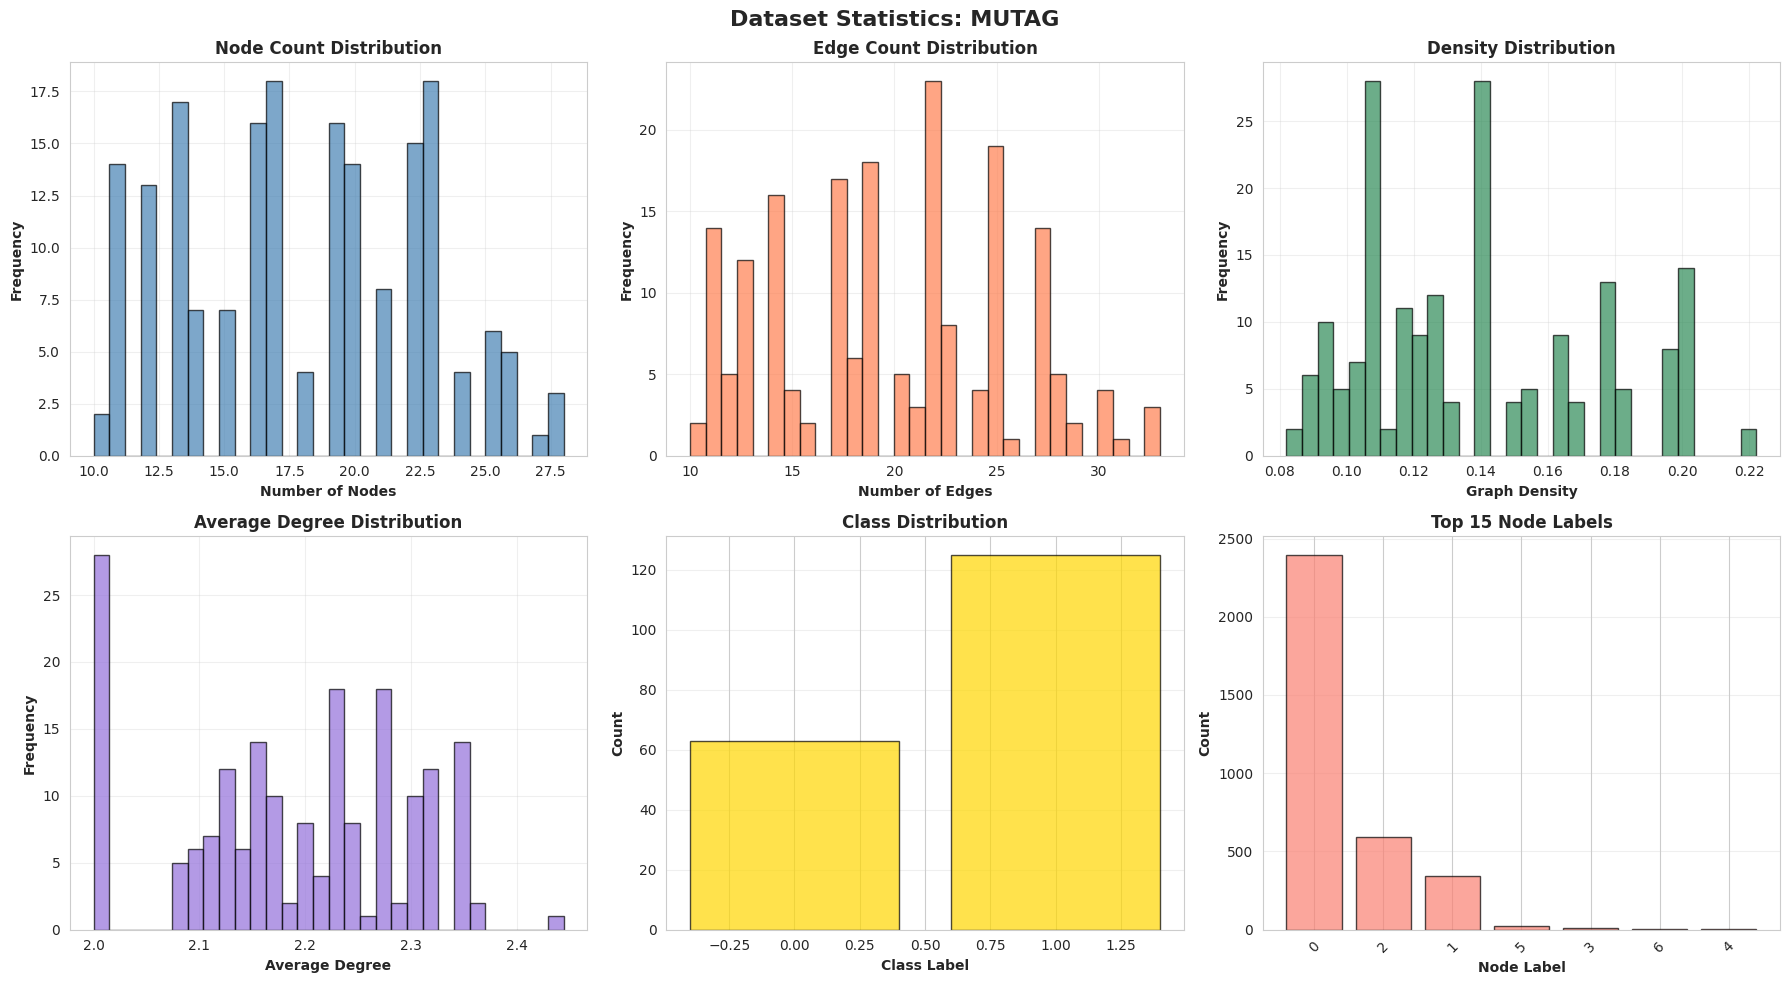

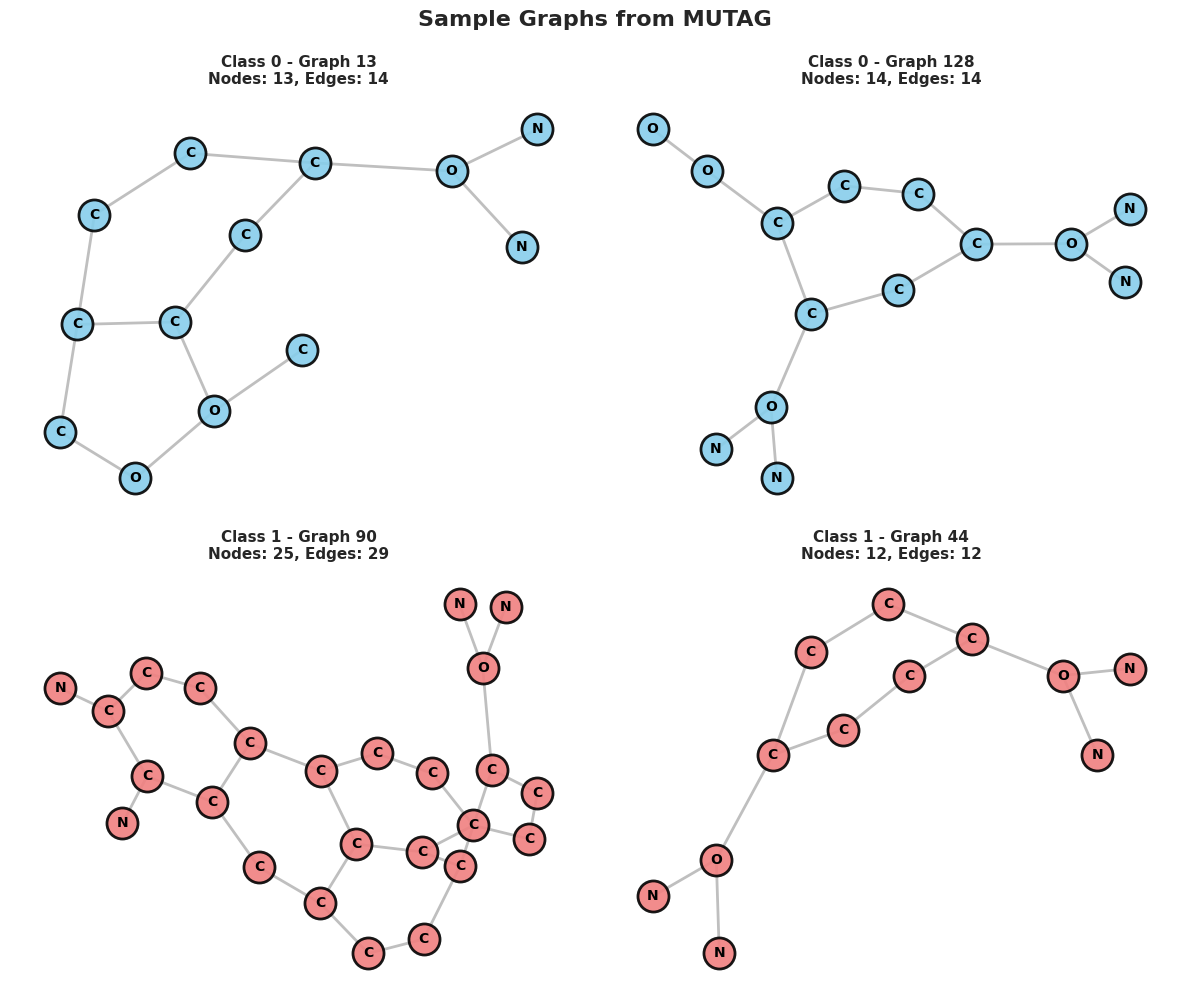


[1/6] Computing WL Subtree Kernel
  Acc: 0.7974 Â± 0.0977
  F1:  0.7940 Â± 0.1010


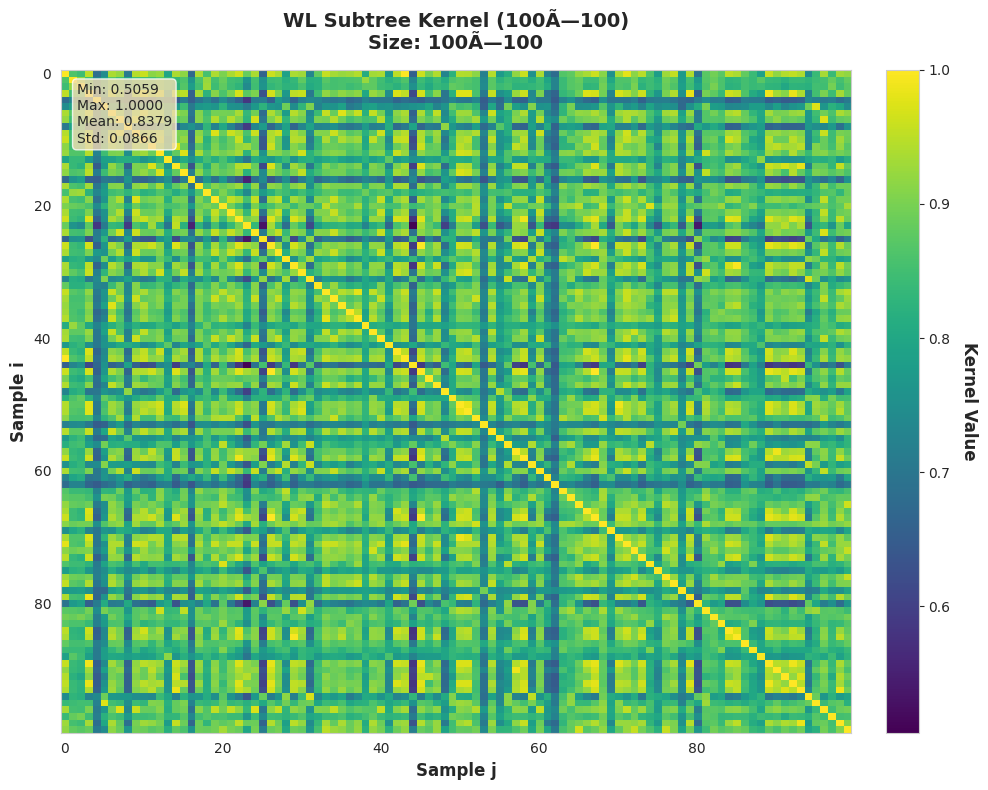


[2/6] Computing Shortest-Path Kernel
  Acc: 0.8088 Â± 0.0781
  F1:  0.8029 Â± 0.0815


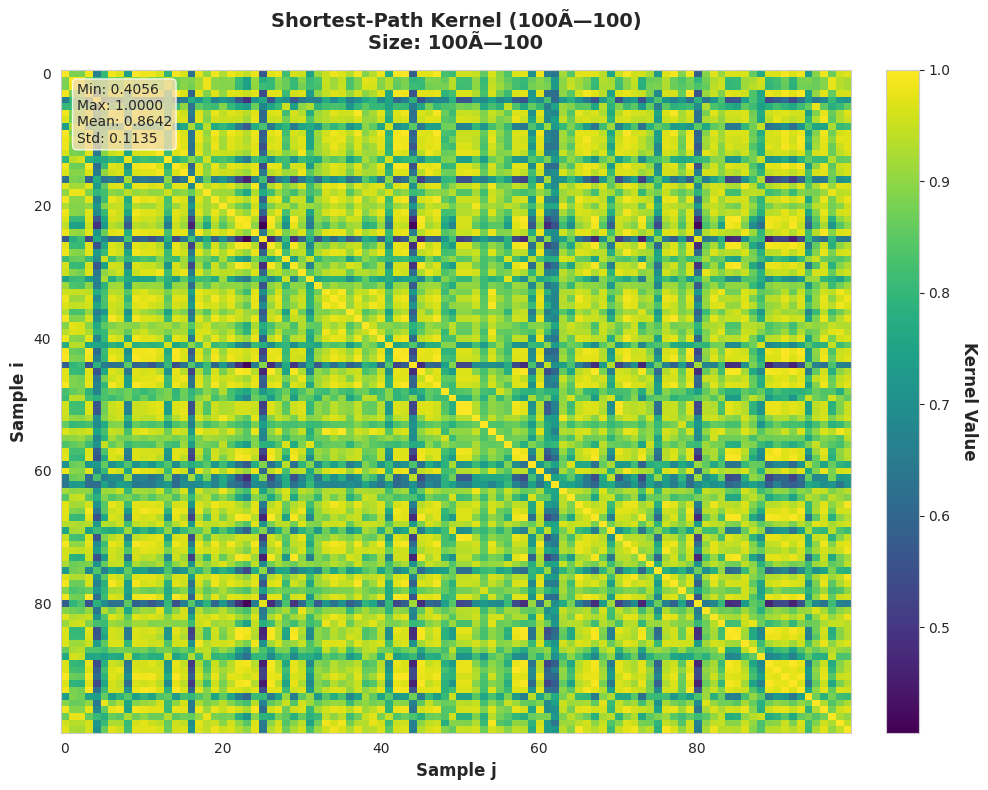


[3/6] Computing Linear Kernel
  Acc: 0.8518 Â± 0.0691
  F1:  0.8452 Â± 0.0762

[4/6] Computing RBF Kernel
  Acc: 0.8462 Â± 0.0681
  F1:  0.8390 Â± 0.0741

[5/6] Computing Quantum Walk Features


Extracting QW features: 100%|██████████| 188/188 [00:42<00:00,  4.40it/s]


âœ“ Cache saved: qw_cache_MUTAG.pkl
  Quantum Walk feature shape: (188, 26)
  Acc: 0.8567 Â± 0.0472
  F1:  0.8561 Â± 0.0495

[6/6] Computing Fidelity Kernel (NEW)
  Computing quantum states for 188 graphs...


Quantum states: 100%|██████████| 188/188 [00:00<00:00, 528.17it/s]


  Computing pairwise fidelities...
  Acc: 0.8249 Â± 0.0670
  F1:  0.8148 Â± 0.0792


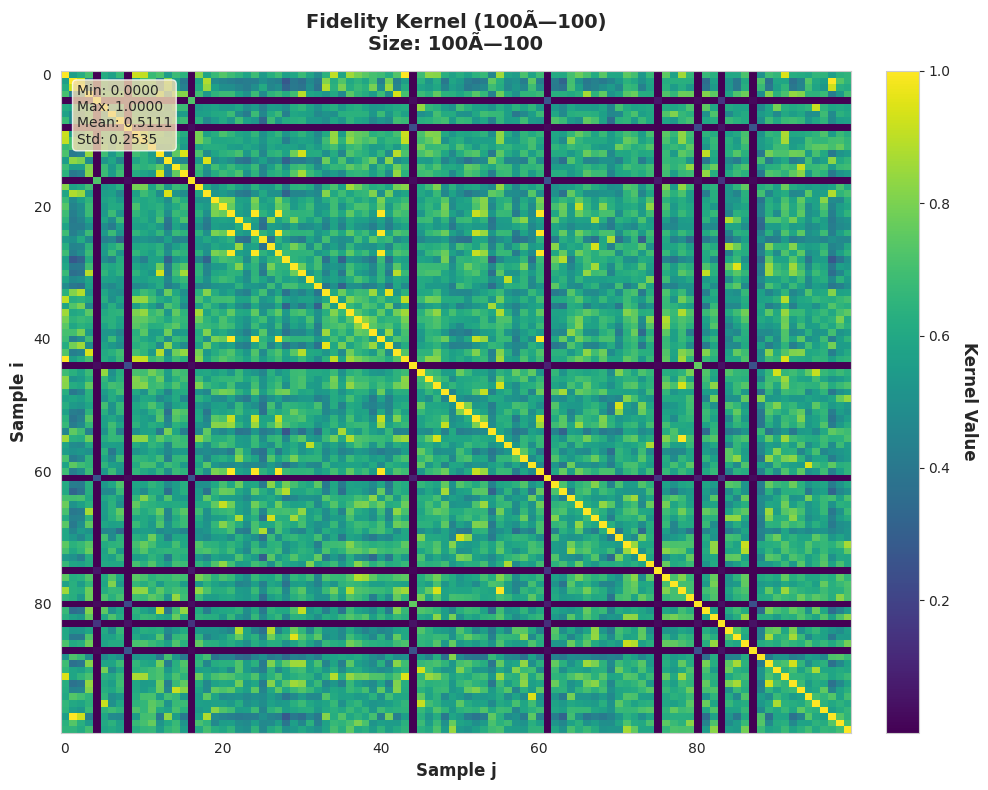


Generating feature distribution analysis...


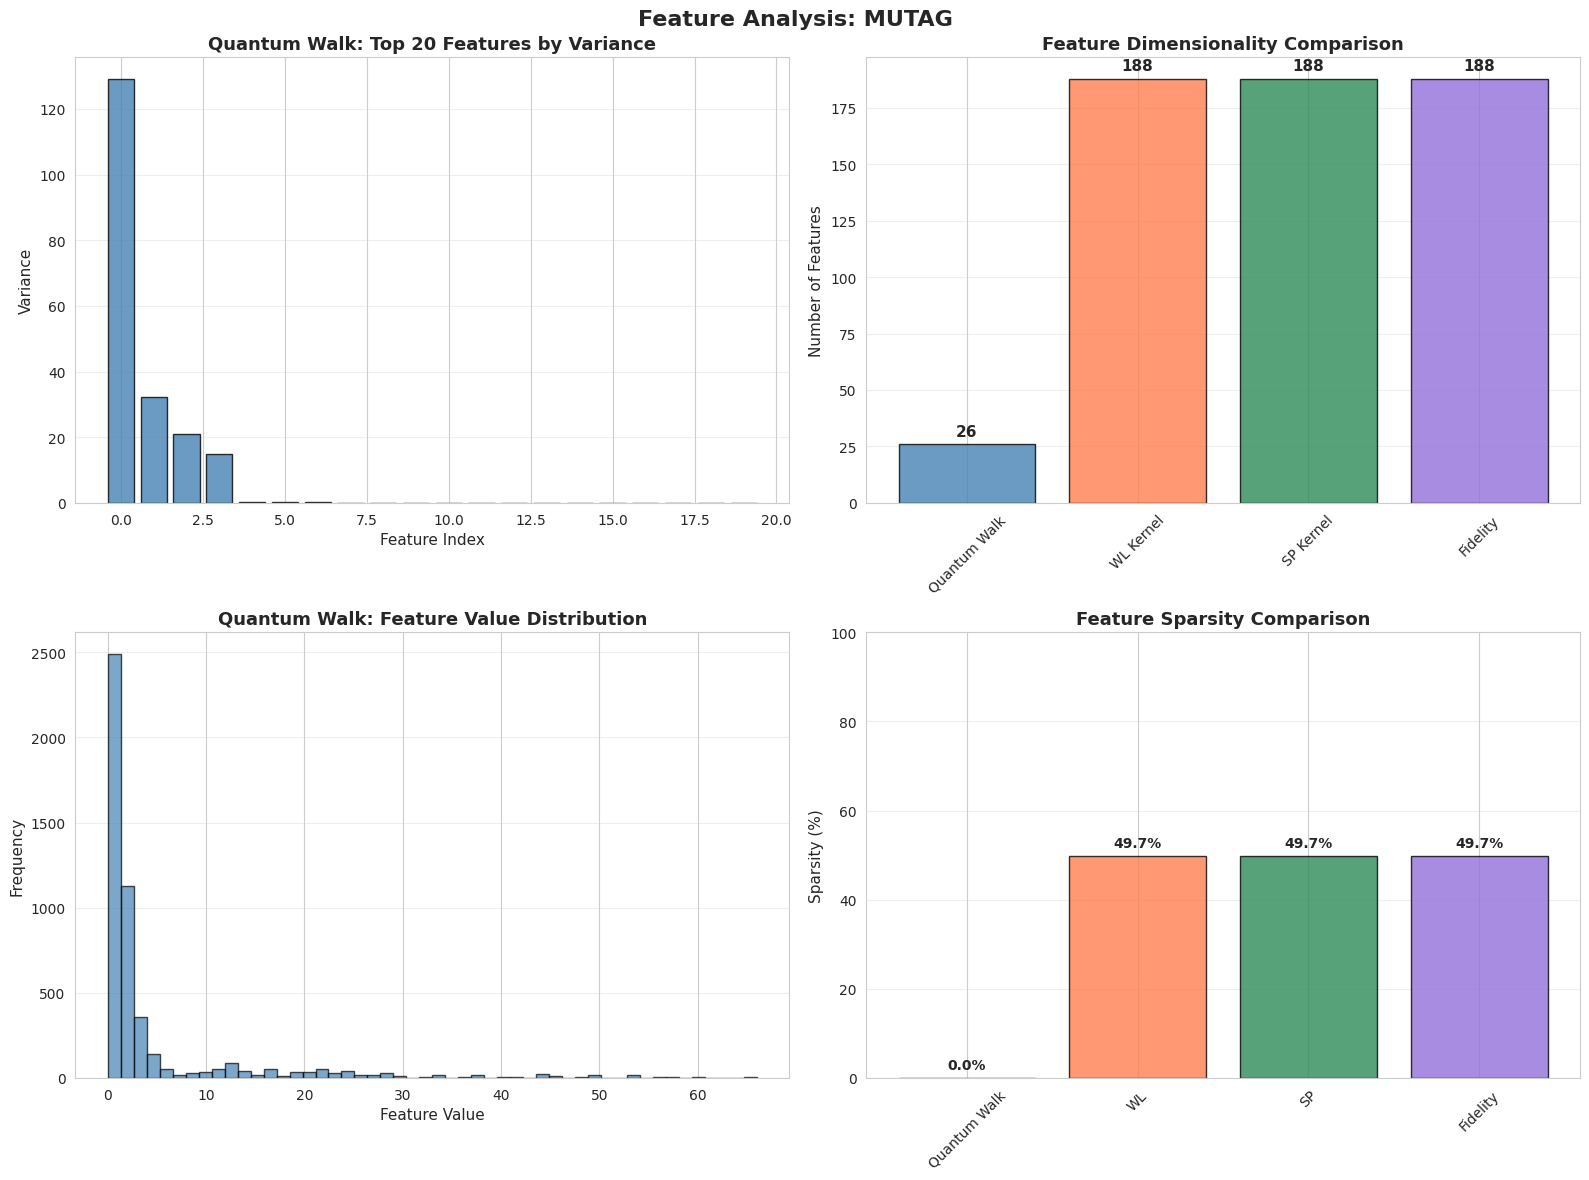


HOLDOUT TEST EVALUATION


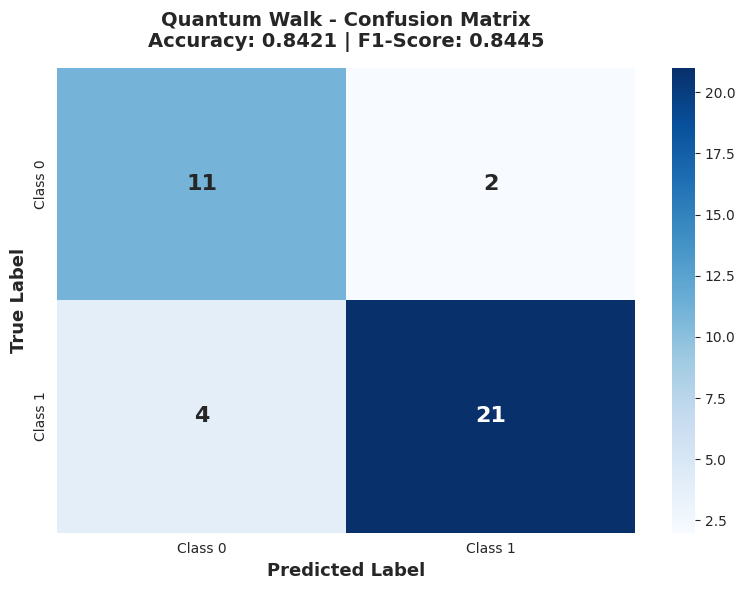

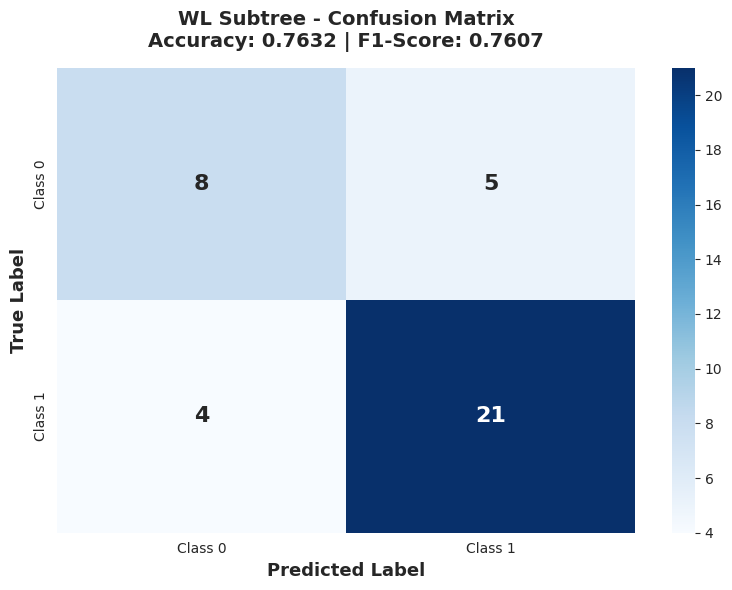

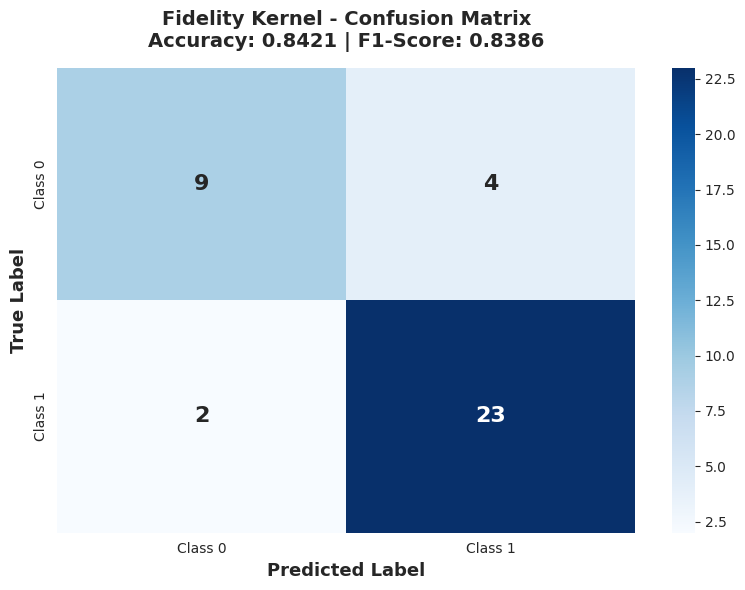


SUMMARY FOR MUTAG
Method               Accuracy             F1-Score            
------------------------------------------------------------
â˜… Quantum_Walk       0.8567Â±0.0472       0.8561Â±0.0495      
  Linear             0.8518Â±0.0691       0.8452Â±0.0762      
  RBF                0.8462Â±0.0681       0.8390Â±0.0741      
â˜… Fidelity           0.8249Â±0.0670       0.8148Â±0.0792      
  SP                 0.8088Â±0.0781       0.8029Â±0.0815      
  WL_Subtree         0.7974Â±0.0977       0.7940Â±0.1010      

EVALUATING DATASET: PTC_MR
âœ“ PTC_MR downloaded and extracted
âœ“ Loaded 344 graphs from PTC_MR
  Class distribution: Counter({0: 192, 1: 152})

DATASET ANALYSIS
DATASET STATISTICS: PTC_MR
Number of graphs: 344
Class distribution: Counter({0: 192, 1: 152})

Graph size statistics:
  Nodes - Mean: 14.29, Std: 9.02, Min: 2, Max: 64
  Edges - Mean: 14.69, Std: 10.05, Min: 1, Max: 71
  Density - Mean: 0.214, Std: 0.131

Node label distribution: {0: 1, 1: 23, 2: 693, 3: 368,

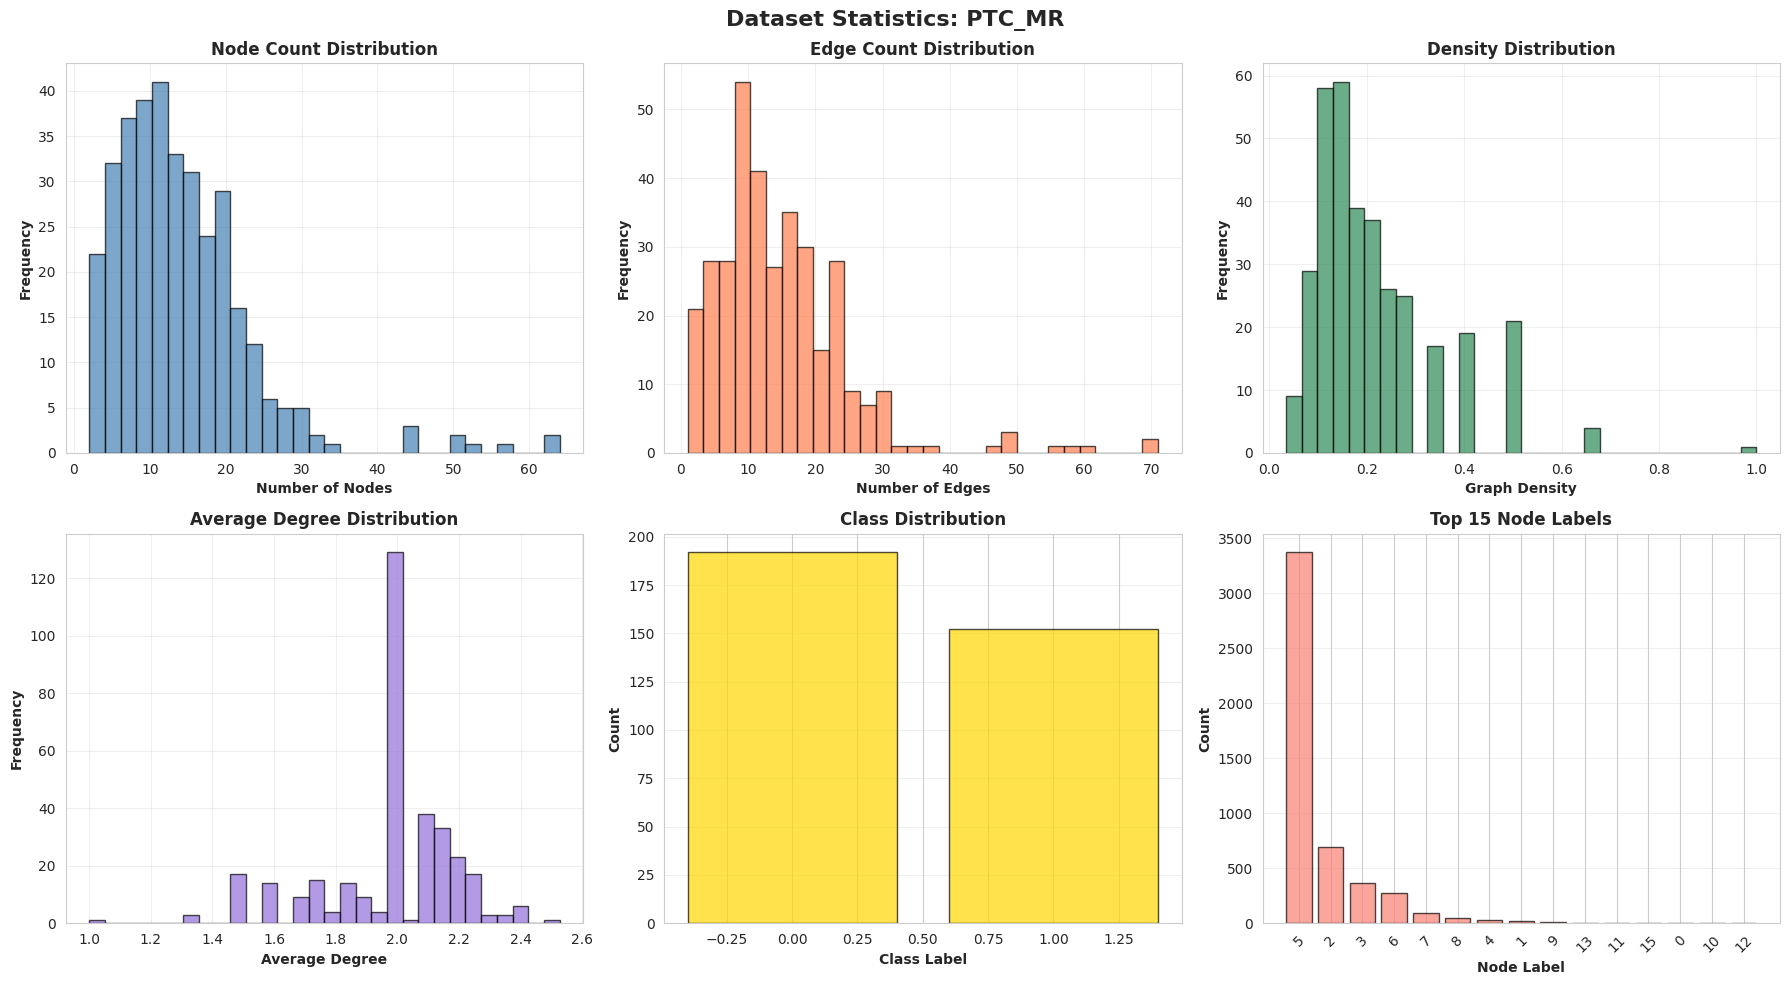

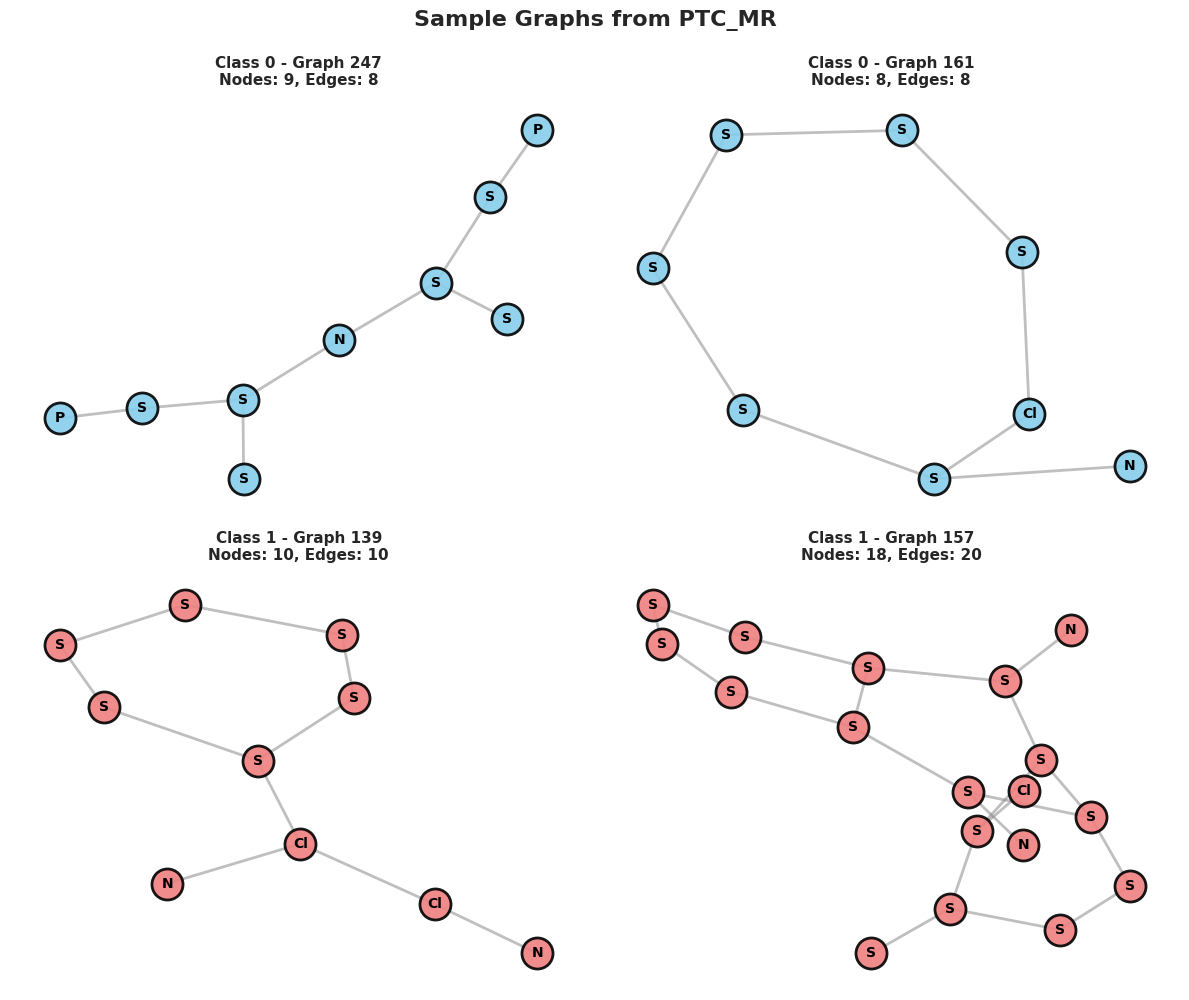


[1/6] Computing WL Subtree Kernel
  Acc: 0.6045 Â± 0.0436
  F1:  0.5346 Â± 0.0682


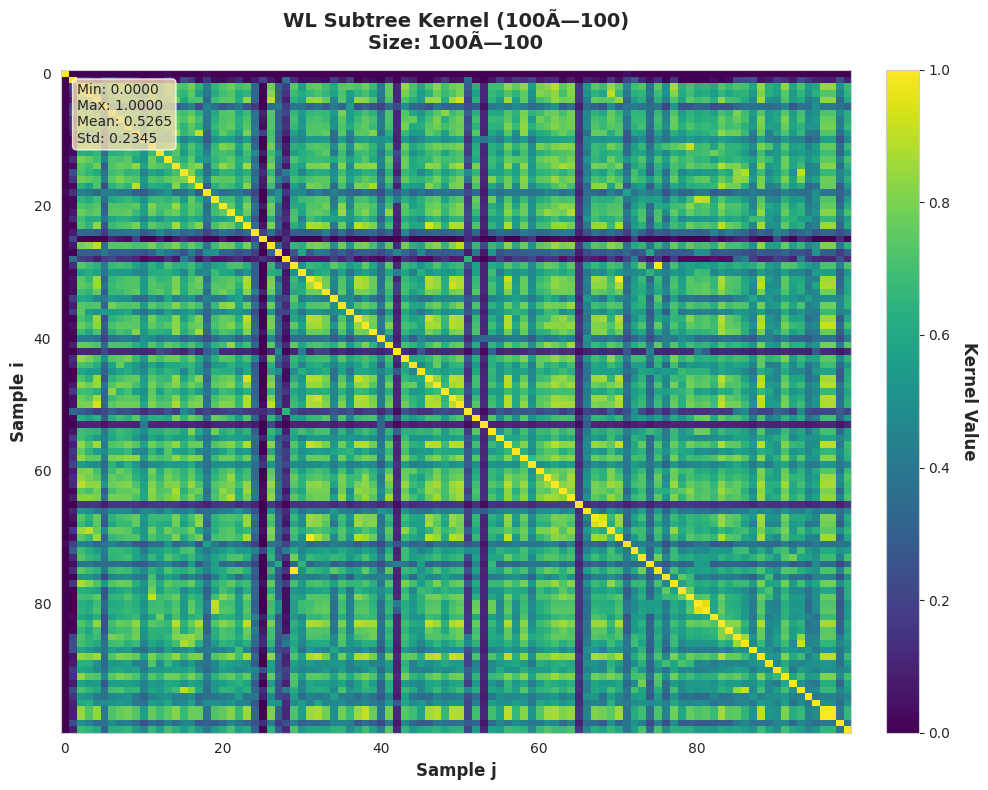


[2/6] Computing Shortest-Path Kernel
  Acc: 0.5729 Â± 0.0571
  F1:  0.5166 Â± 0.0743


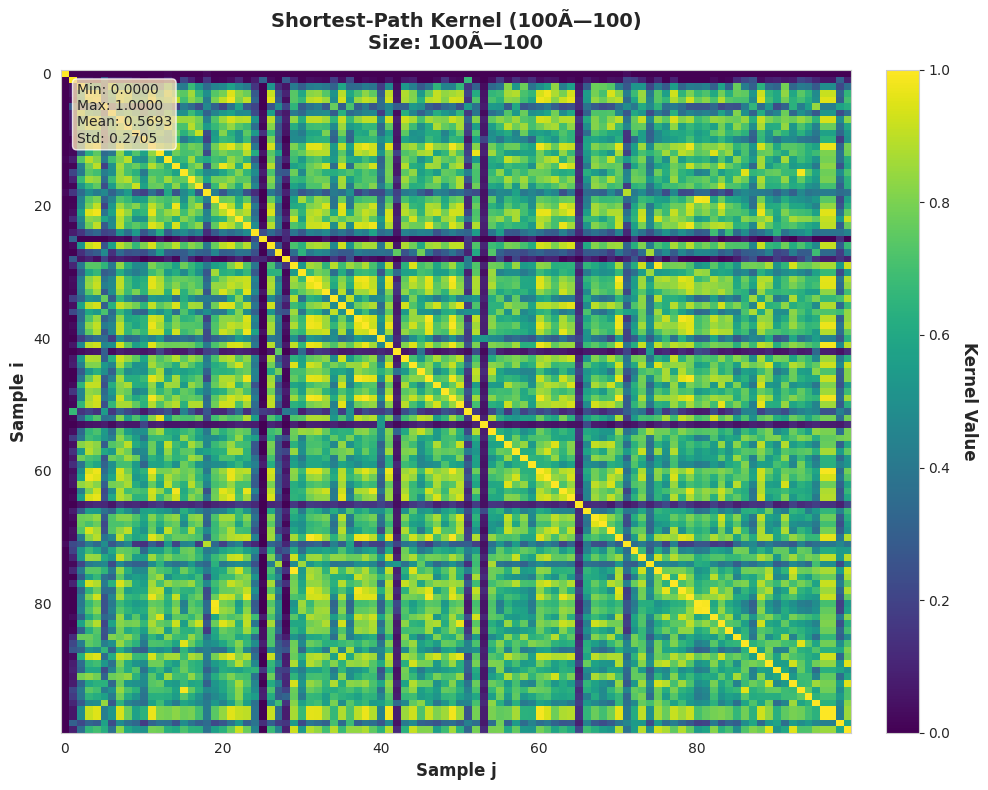


[3/6] Computing Linear Kernel
  Acc: 0.5901 Â± 0.0326
  F1:  0.4764 Â± 0.0564

[4/6] Computing RBF Kernel
  Acc: 0.6108 Â± 0.0500
  F1:  0.5654 Â± 0.0601

[5/6] Computing Quantum Walk Features


Extracting QW features: 100%|██████████| 344/344 [00:57<00:00,  5.99it/s]


âœ“ Cache saved: qw_cache_PTC_MR.pkl
  Quantum Walk feature shape: (344, 26)
  Acc: 0.5408 Â± 0.0500
  F1:  0.5028 Â± 0.0615

[6/6] Computing Fidelity Kernel (NEW)
  Computing quantum states for 344 graphs...


Quantum states: 100%|██████████| 344/344 [00:02<00:00, 170.44it/s]


  Computing pairwise fidelities...
  Acc: 0.5550 Â± 0.0674
  F1:  0.5079 Â± 0.0740


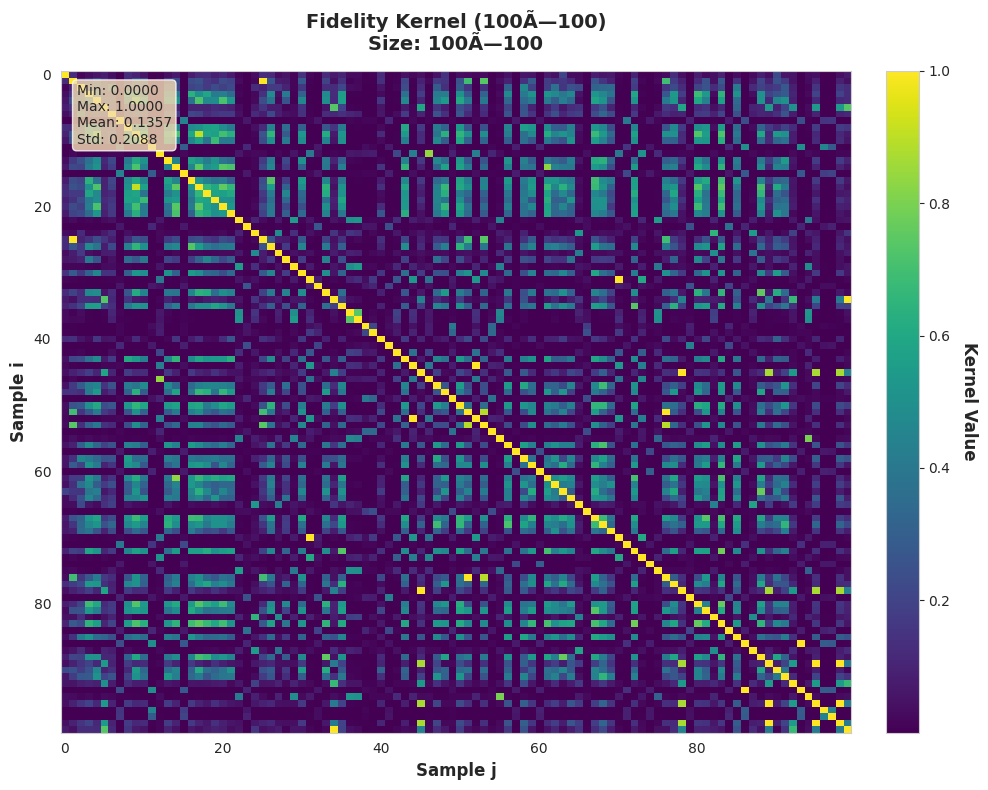


Visualizing quantum circuit for graph 1 (4 nodes, 3 edges)


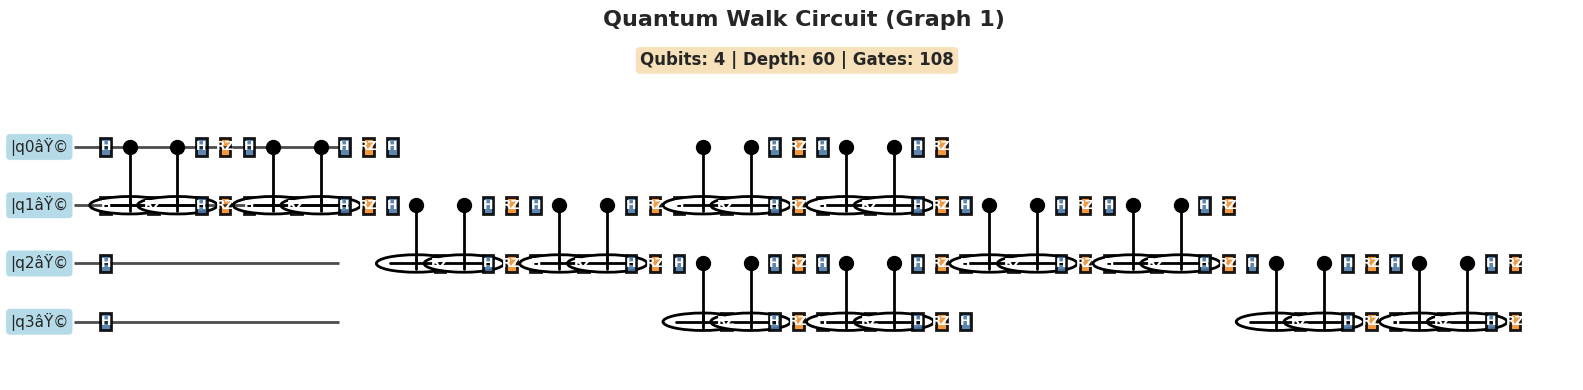


Generating feature distribution analysis...


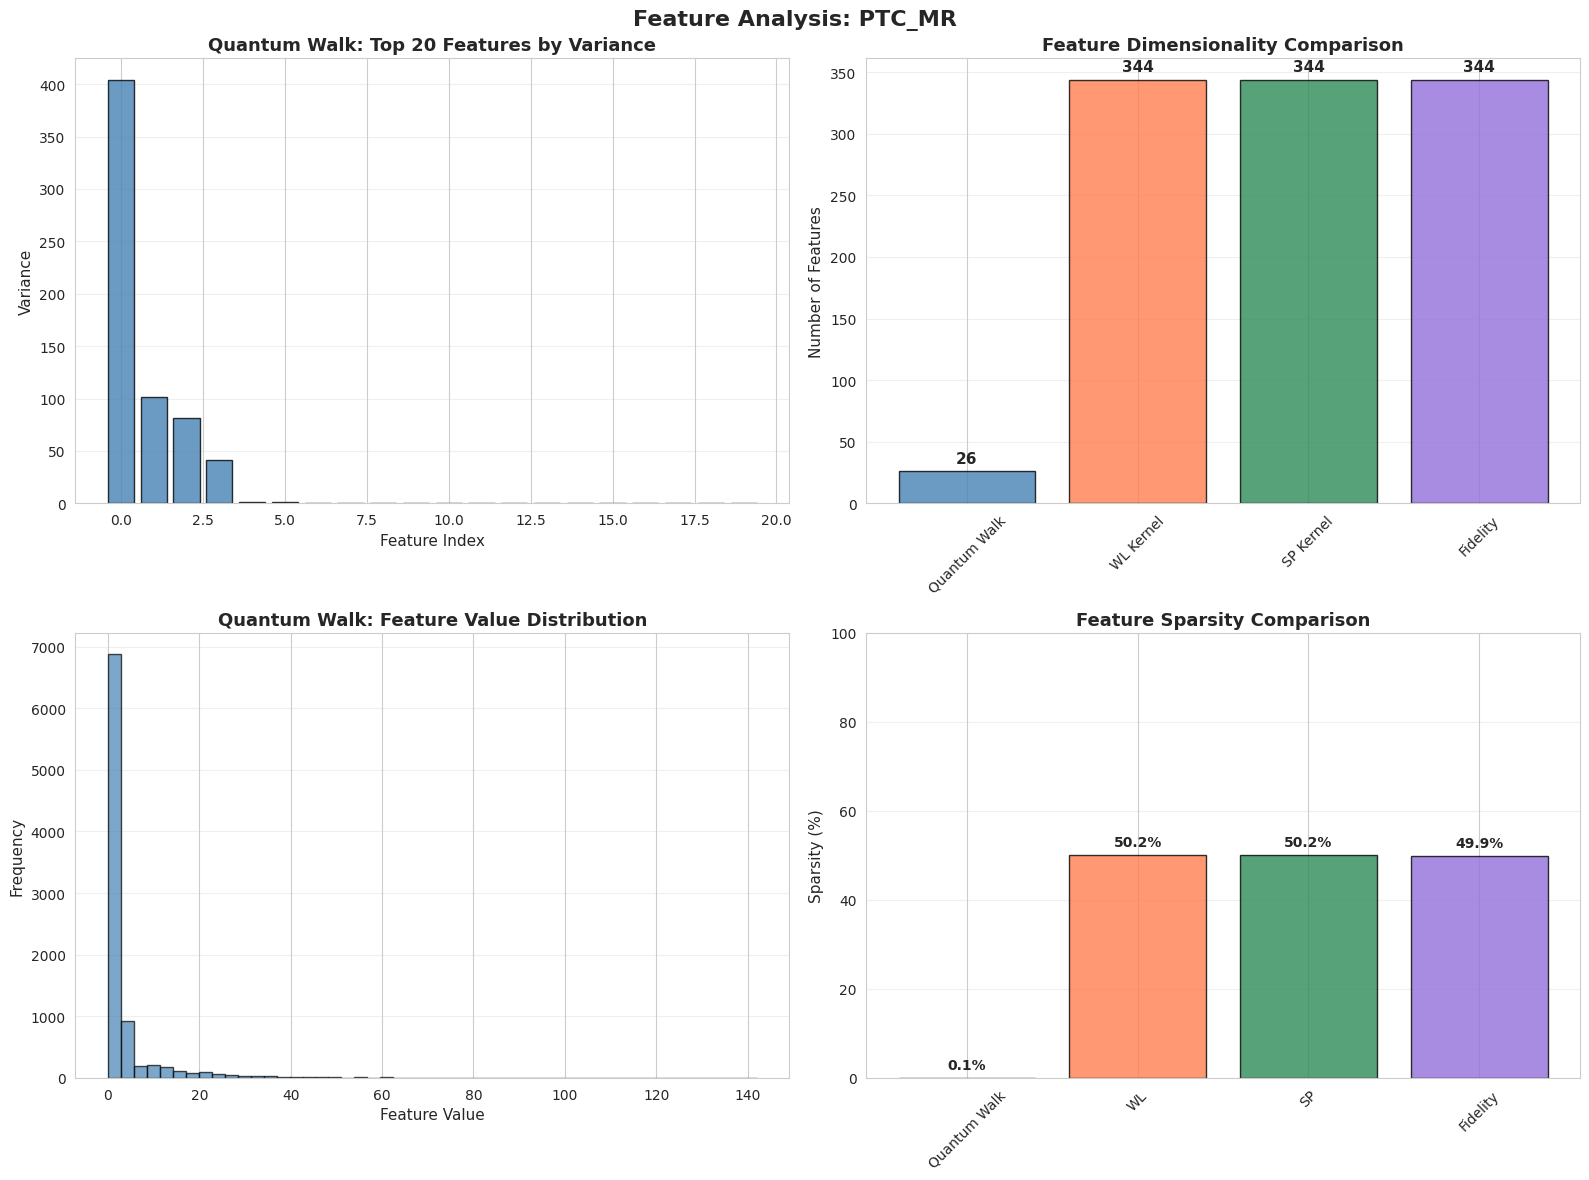


HOLDOUT TEST EVALUATION


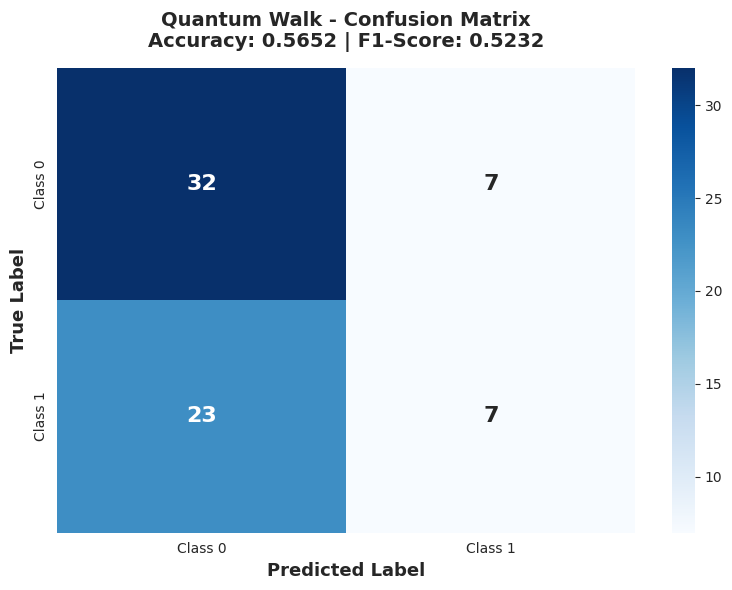

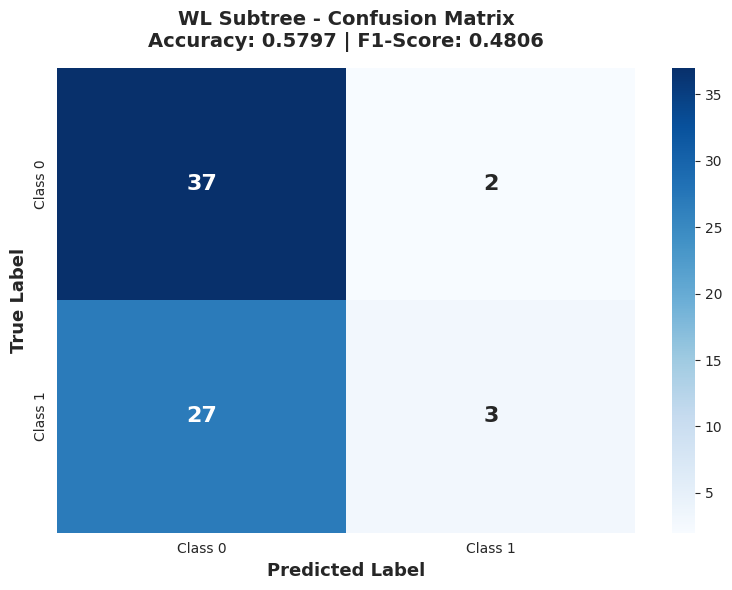

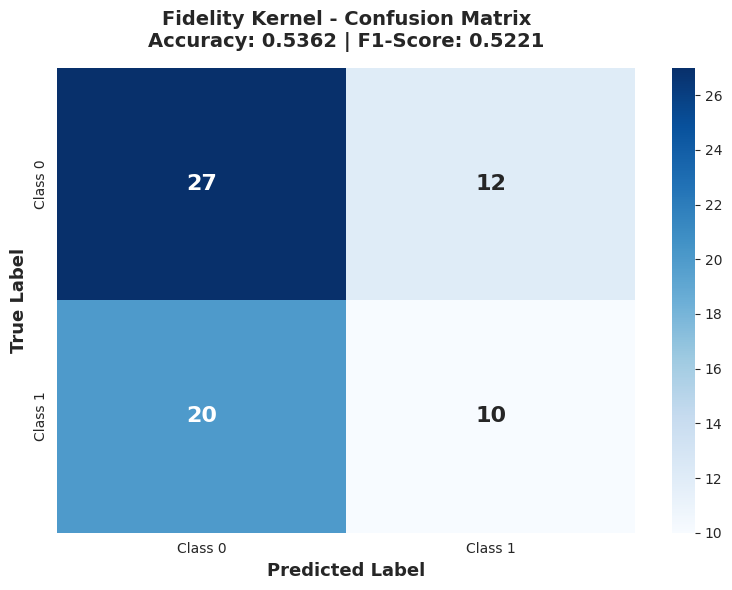


SUMMARY FOR PTC_MR
Method               Accuracy             F1-Score            
------------------------------------------------------------
  RBF                0.6108Â±0.0500       0.5654Â±0.0601      
  WL_Subtree         0.6045Â±0.0436       0.5346Â±0.0682      
  Linear             0.5901Â±0.0326       0.4764Â±0.0564      
  SP                 0.5729Â±0.0571       0.5166Â±0.0743      
â˜… Fidelity           0.5550Â±0.0674       0.5079Â±0.0740      
â˜… Quantum_Walk       0.5408Â±0.0500       0.5028Â±0.0615      

EVALUATING DATASET: PROTEINS
âœ“ PROTEINS downloaded and extracted
âœ“ Loaded 1113 graphs from PROTEINS
  Class distribution: Counter({0: 663, 1: 450})
  Subsampled to 500 graphs

DATASET ANALYSIS
DATASET STATISTICS: PROTEINS
Number of graphs: 500
Class distribution: Counter({0: 300, 1: 200})

Graph size statistics:
  Nodes - Mean: 39.94, Std: 46.12, Min: 4, Max: 481
  Edges - Mean: 74.41, Std: 88.41, Min: 5, Max: 1012
  Density - Mean: 0.211, Std: 0.196

Node label di

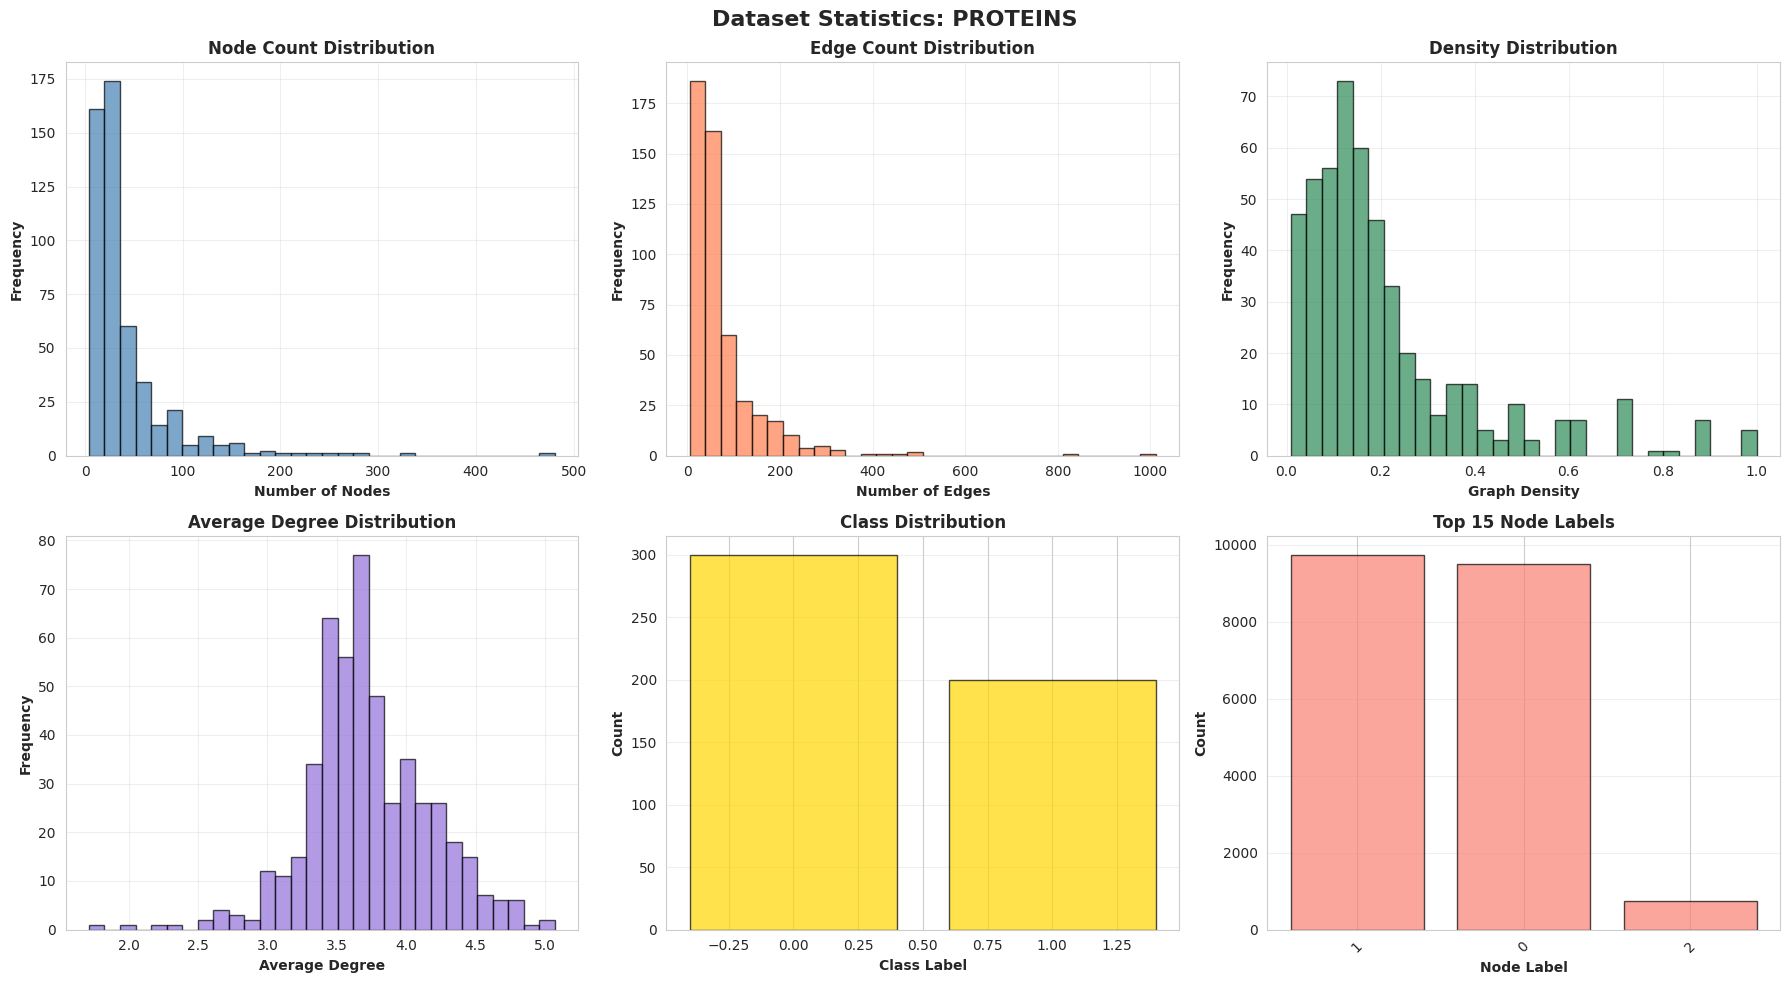

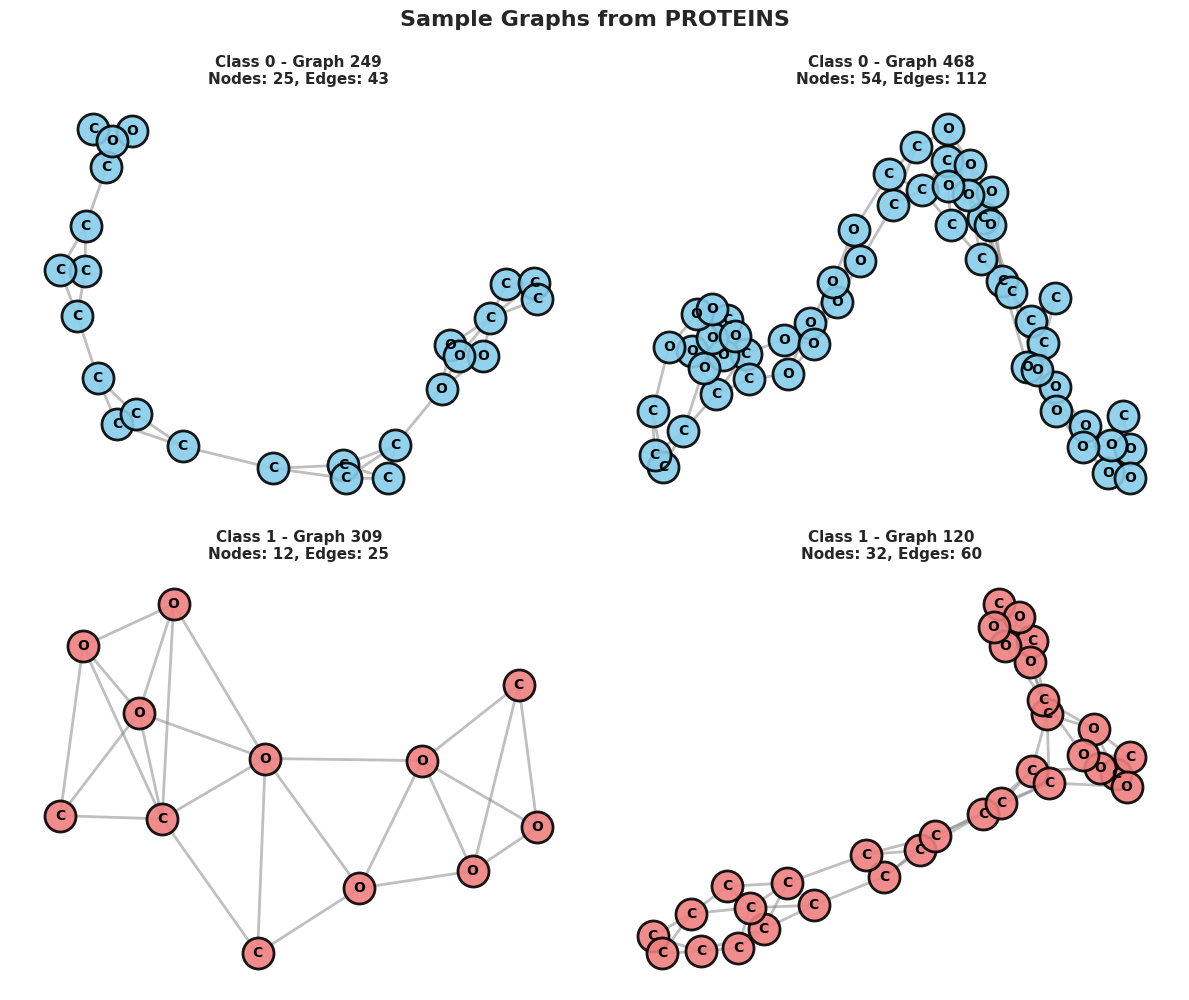


[1/6] Computing WL Subtree Kernel
  Acc: 0.7420 Â± 0.0660
  F1:  0.7347 Â± 0.0668


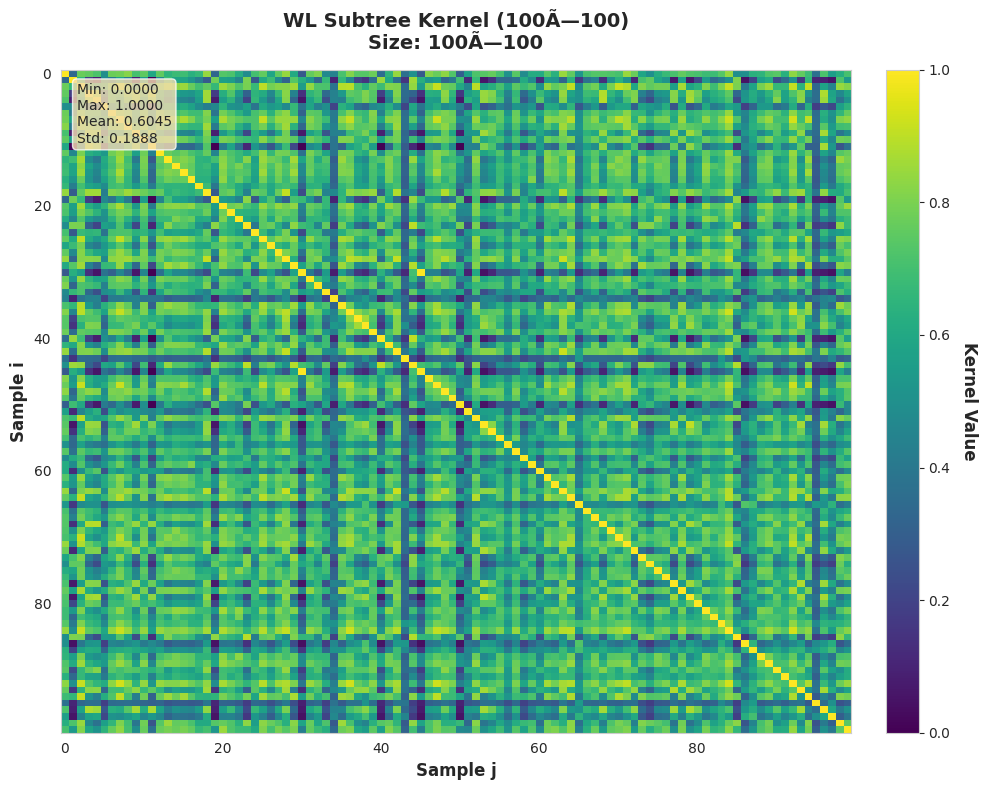


[2/6] Computing Shortest-Path Kernel
  Acc: 0.7680 Â± 0.0449
  F1:  0.7654 Â± 0.0451


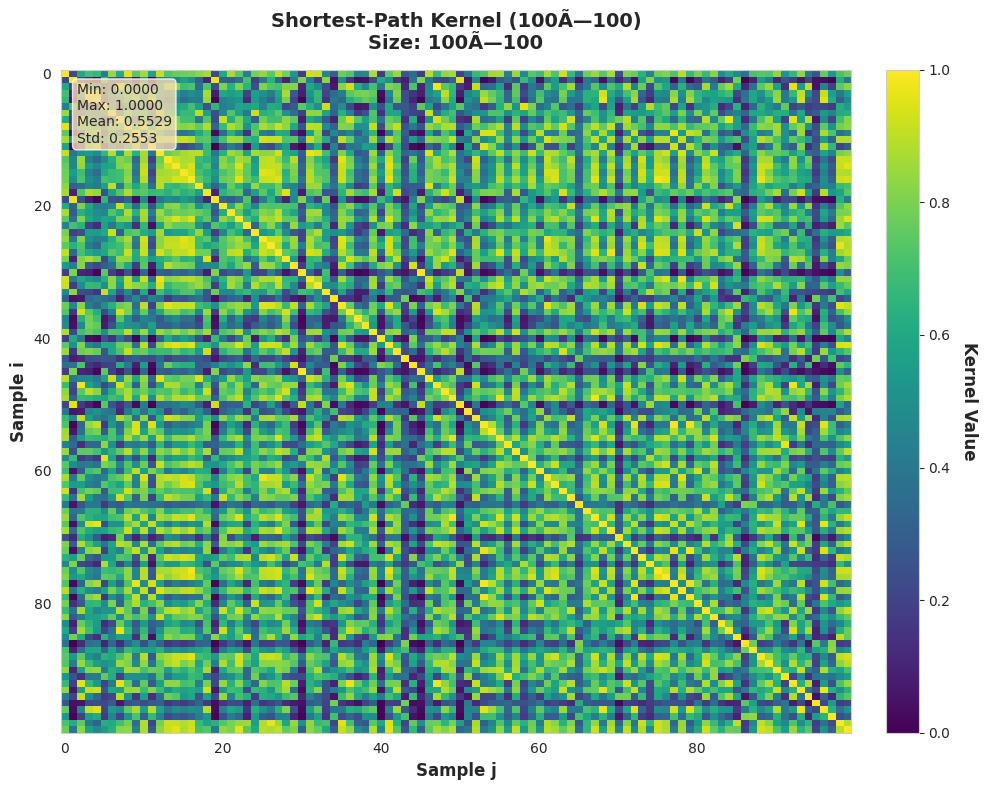


[3/6] Computing Linear Kernel
  Acc: 0.7200 Â± 0.0544
  F1:  0.7203 Â± 0.0542

[4/6] Computing RBF Kernel
  Acc: 0.7260 Â± 0.0506
  F1:  0.7251 Â± 0.0514

[5/6] Computing Quantum Walk Features


Extracting QW features: 100%|██████████| 500/500 [02:48<00:00,  2.98it/s]


âœ“ Cache saved: qw_cache_PROTEINS.pkl
  Quantum Walk feature shape: (500, 26)
  Acc: 0.7300 Â± 0.0665
  F1:  0.7166 Â± 0.0696

[6/6] Computing Fidelity Kernel (NEW)
  Computing quantum states for 500 graphs...


Quantum states: 100%|██████████| 500/500 [00:02<00:00, 173.06it/s]


  Computing pairwise fidelities...
  Acc: 0.7220 Â± 0.0583
  F1:  0.7127 Â± 0.0666


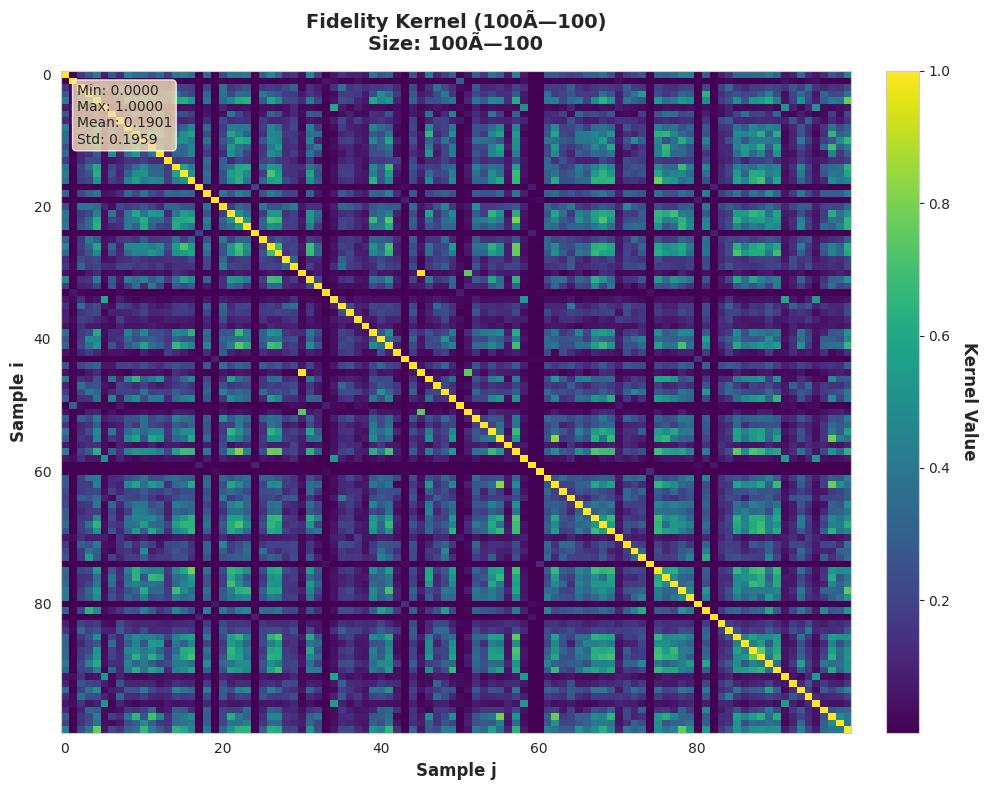


Visualizing quantum circuit for graph 1 (8 nodes, 10 edges)


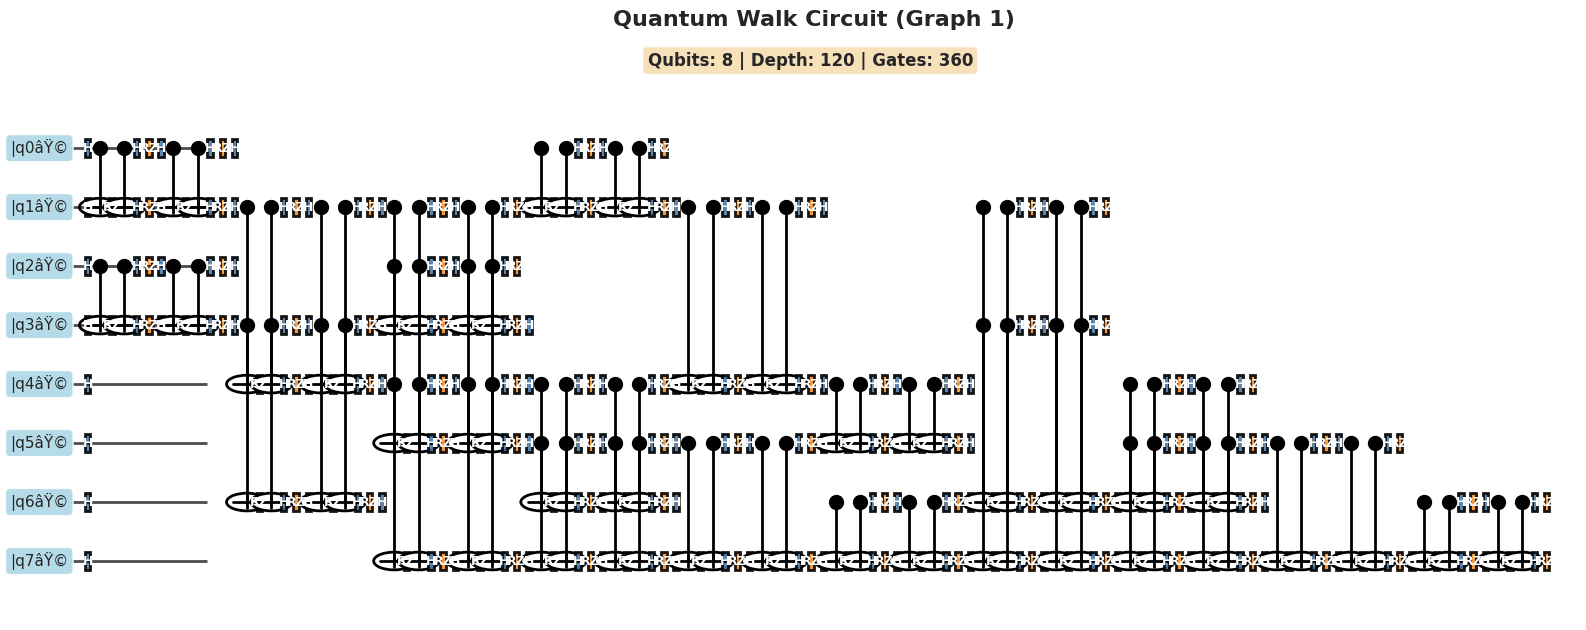


Generating feature distribution analysis...


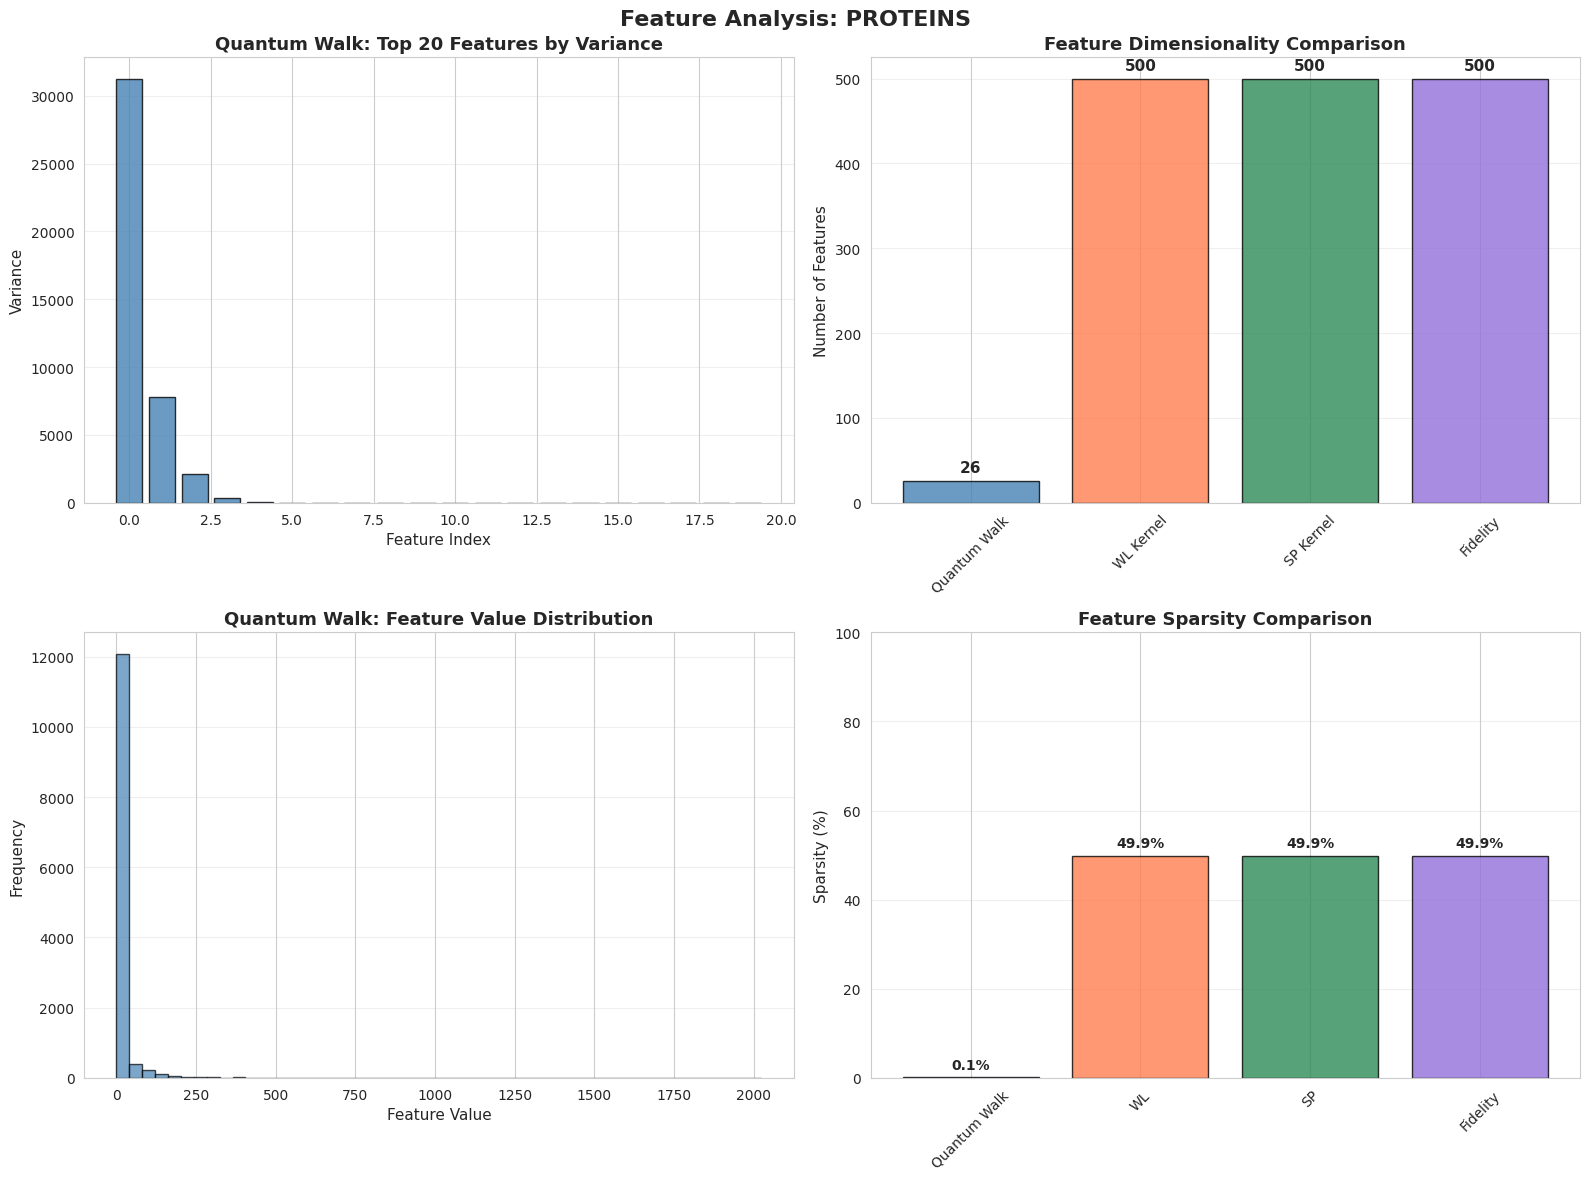


HOLDOUT TEST EVALUATION


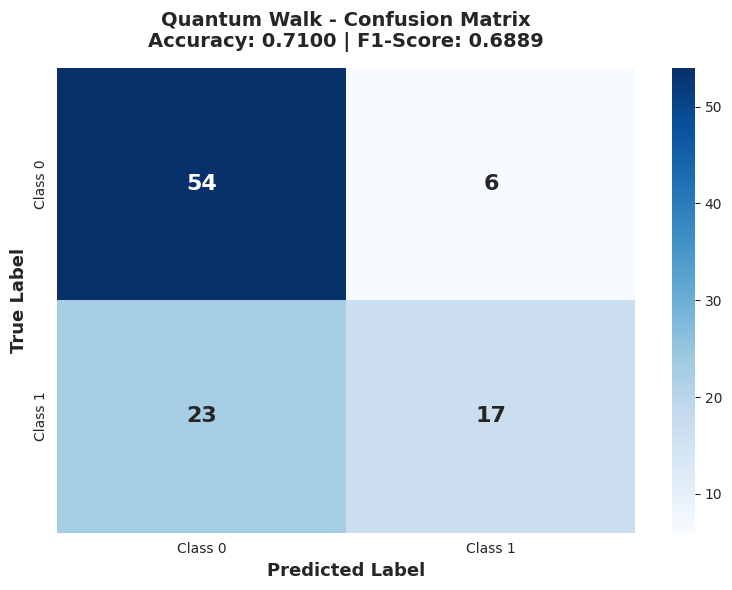

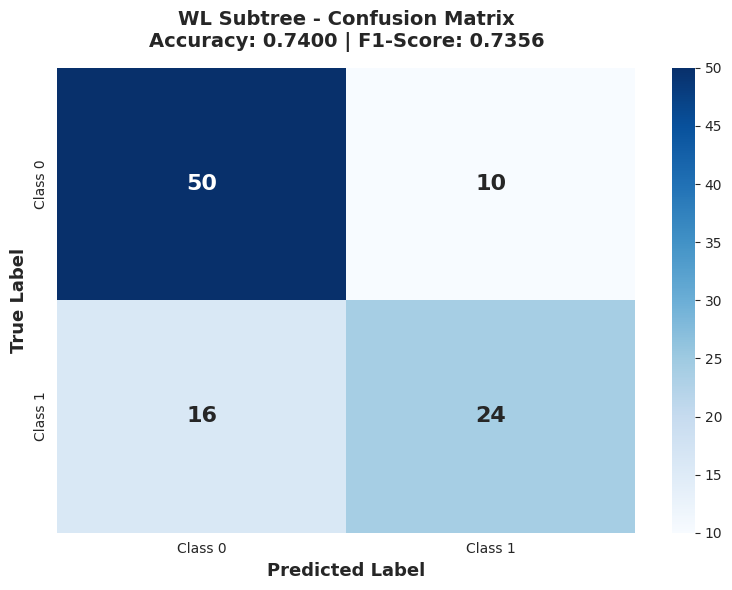

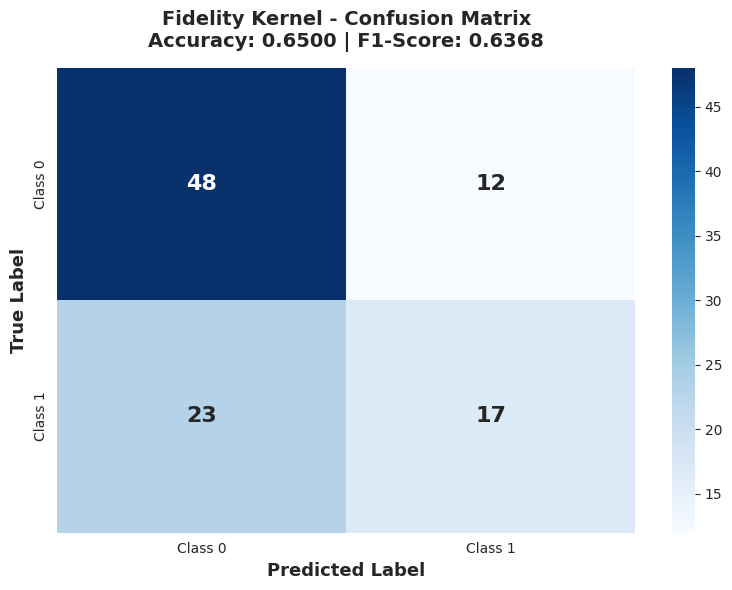


SUMMARY FOR PROTEINS
Method               Accuracy             F1-Score            
------------------------------------------------------------
  SP                 0.7680Â±0.0449       0.7654Â±0.0451      
  WL_Subtree         0.7420Â±0.0660       0.7347Â±0.0668      
â˜… Quantum_Walk       0.7300Â±0.0665       0.7166Â±0.0696      
  RBF                0.7260Â±0.0506       0.7251Â±0.0514      
â˜… Fidelity           0.7220Â±0.0583       0.7127Â±0.0666      
  Linear             0.7200Â±0.0544       0.7203Â±0.0542      

EVALUATING DATASET: NCI1
âœ“ NCI1 downloaded and extracted
âœ“ Loaded 4110 graphs from NCI1
  Class distribution: Counter({1: 2057, 0: 2053})
  Subsampled to 500 graphs

DATASET ANALYSIS
DATASET STATISTICS: NCI1
Number of graphs: 500
Class distribution: Counter({1: 261, 0: 239})

Graph size statistics:
  Nodes - Mean: 30.21, Std: 14.40, Min: 3, Max: 93
  Edges - Mean: 32.69, Std: 16.06, Min: 2, Max: 102
  Density - Mean: 0.089, Std: 0.043

Node label distribution: {1

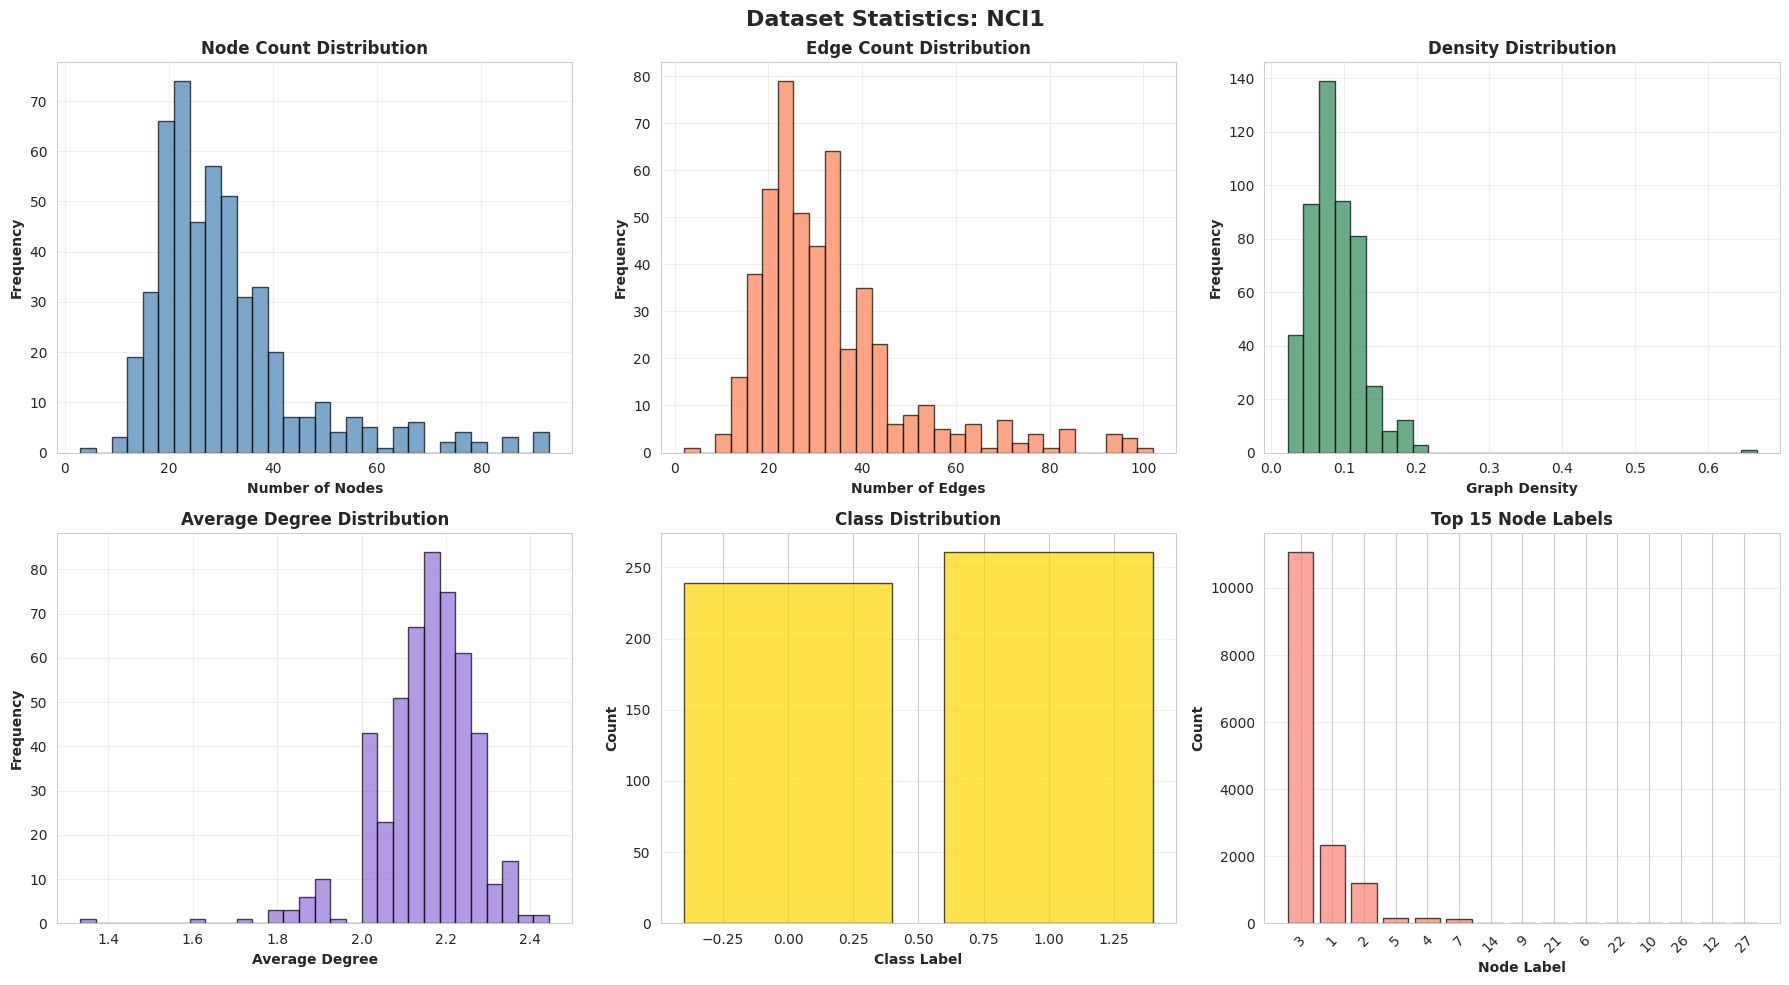

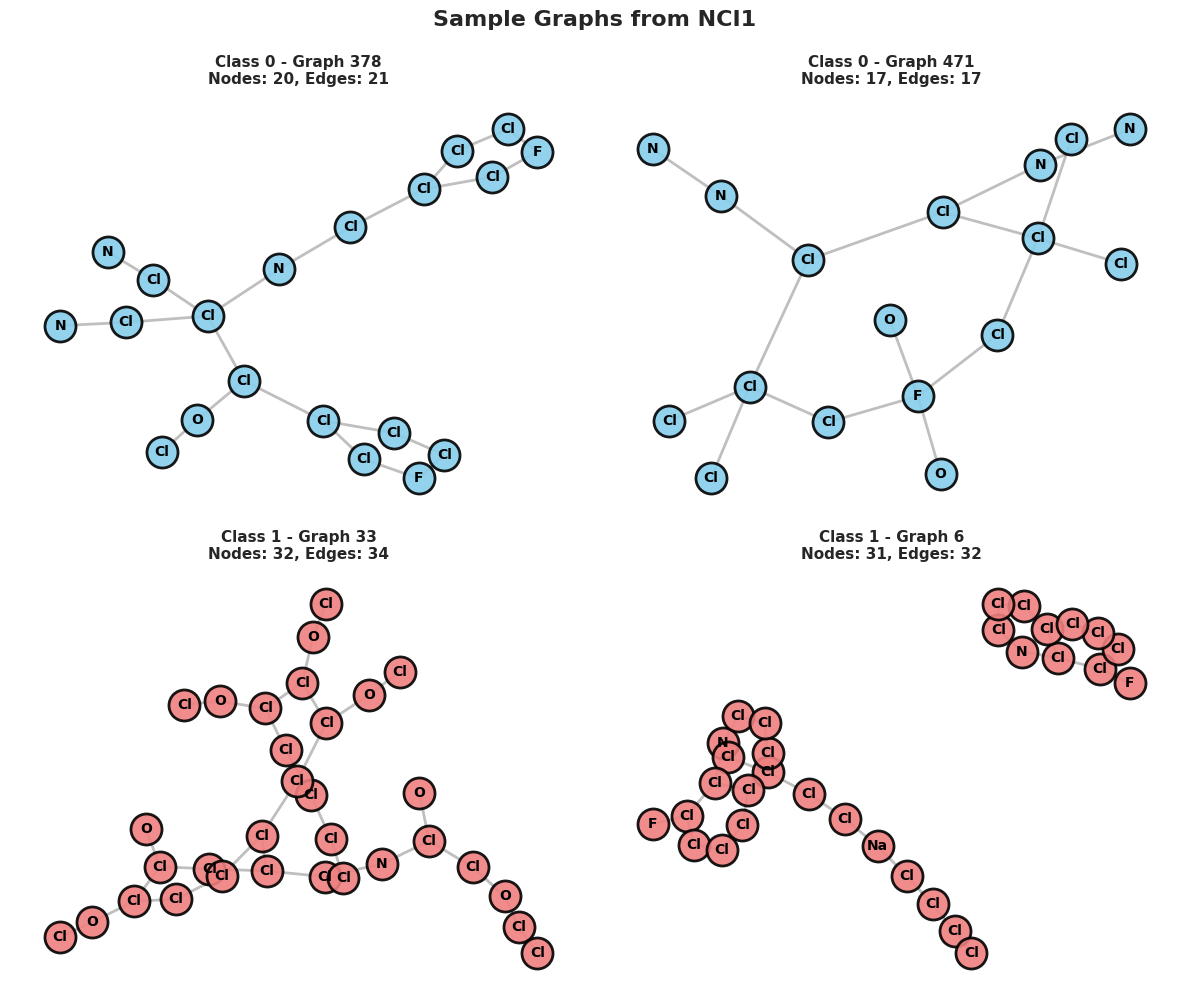


[1/6] Computing WL Subtree Kernel
  Acc: 0.7520 Â± 0.0646
  F1:  0.7517 Â± 0.0648


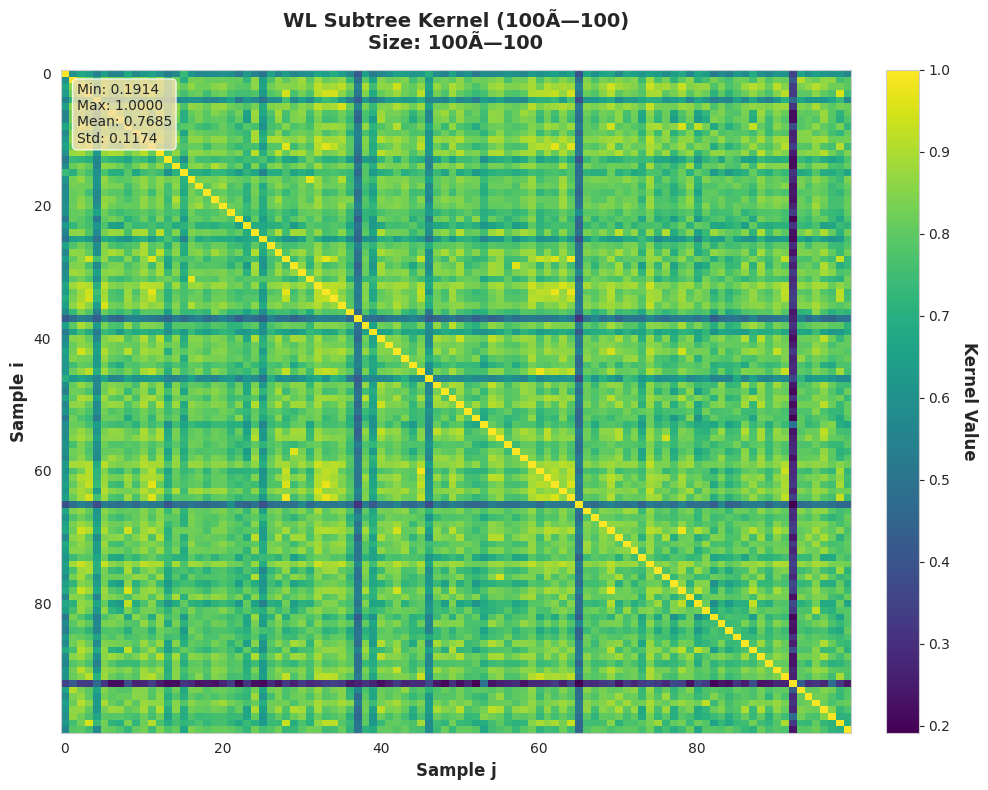


[2/6] Computing Shortest-Path Kernel
  Acc: 0.6160 Â± 0.0528
  F1:  0.6028 Â± 0.0529


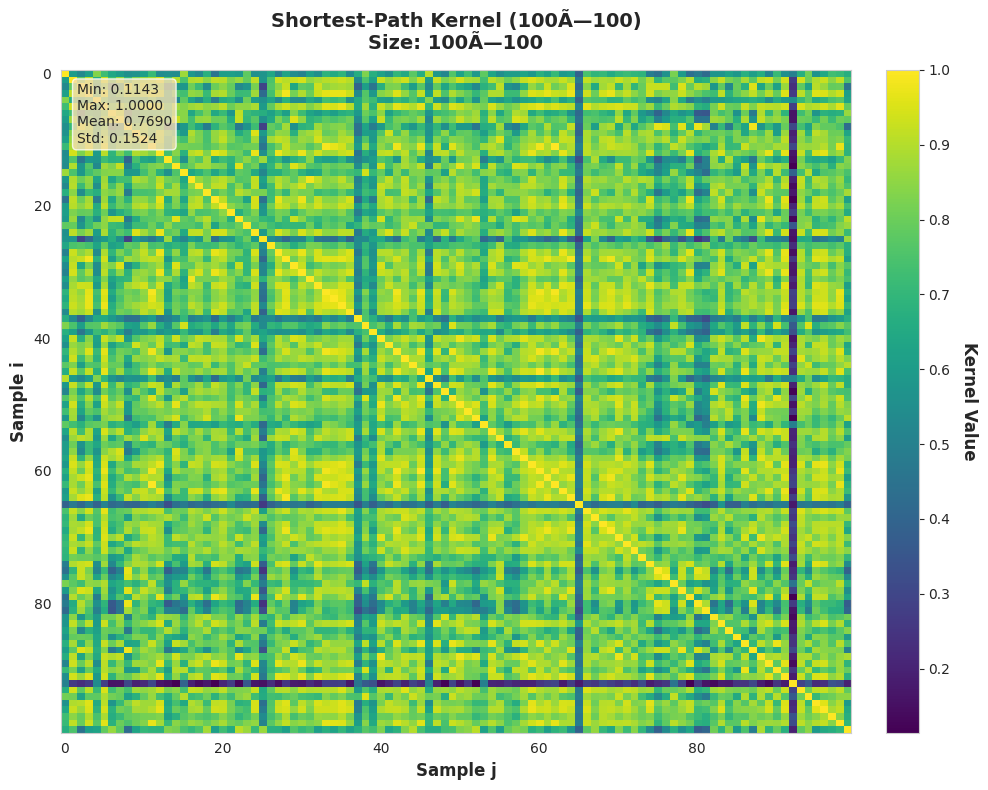


[3/6] Computing Linear Kernel
  Acc: 0.5880 Â± 0.0538
  F1:  0.5800 Â± 0.0557

[4/6] Computing RBF Kernel
  Acc: 0.6060 Â± 0.0522
  F1:  0.6048 Â± 0.0530

[5/6] Computing Quantum Walk Features


Extracting QW features: 100%|██████████| 500/500 [00:32<00:00, 15.18it/s]


âœ“ Cache saved: qw_cache_NCI1.pkl
  Quantum Walk feature shape: (500, 26)
  Acc: 0.6840 Â± 0.0472
  F1:  0.6822 Â± 0.0469

[6/6] Computing Fidelity Kernel (NEW)
  Computing quantum states for 500 graphs...


Quantum states: 100%|██████████| 500/500 [00:00<00:00, 1259.03it/s]


  Computing pairwise fidelities...
  Acc: 0.6440 Â± 0.0436
  F1:  0.6419 Â± 0.0434


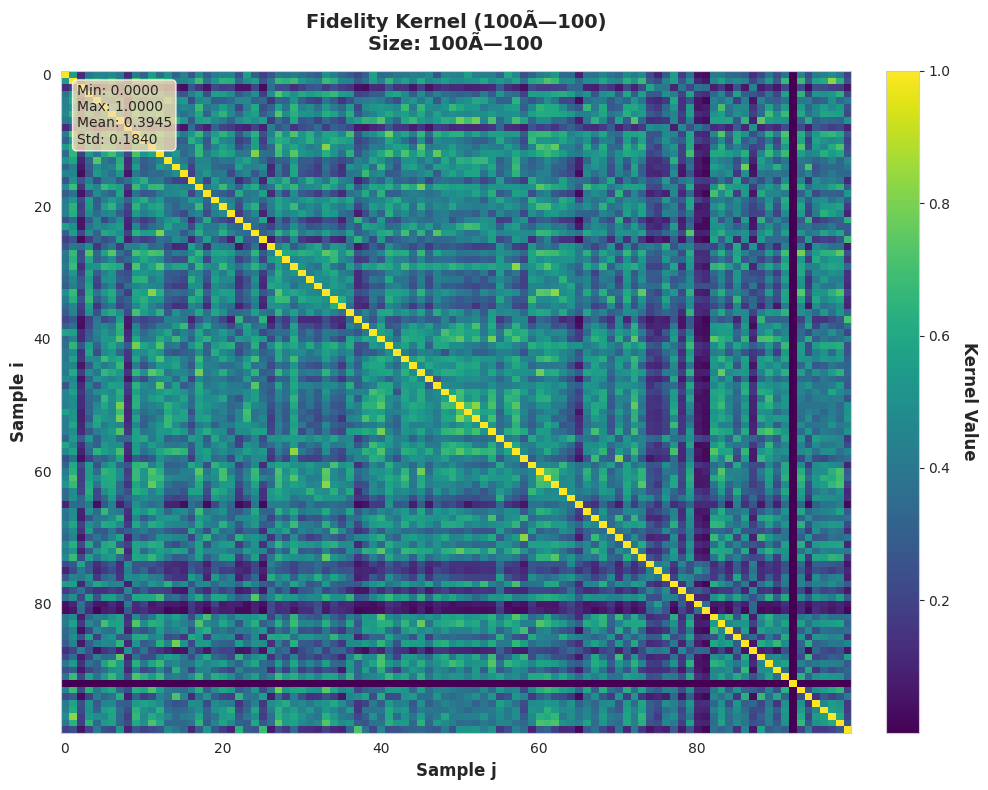


Visualizing quantum circuit for graph 362 (3 nodes, 2 edges)


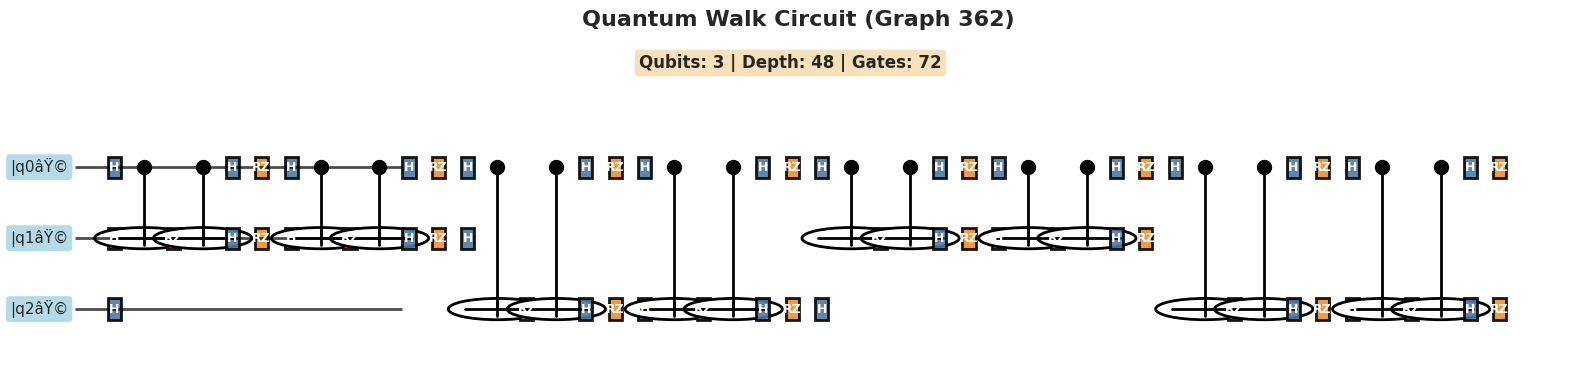


Generating feature distribution analysis...


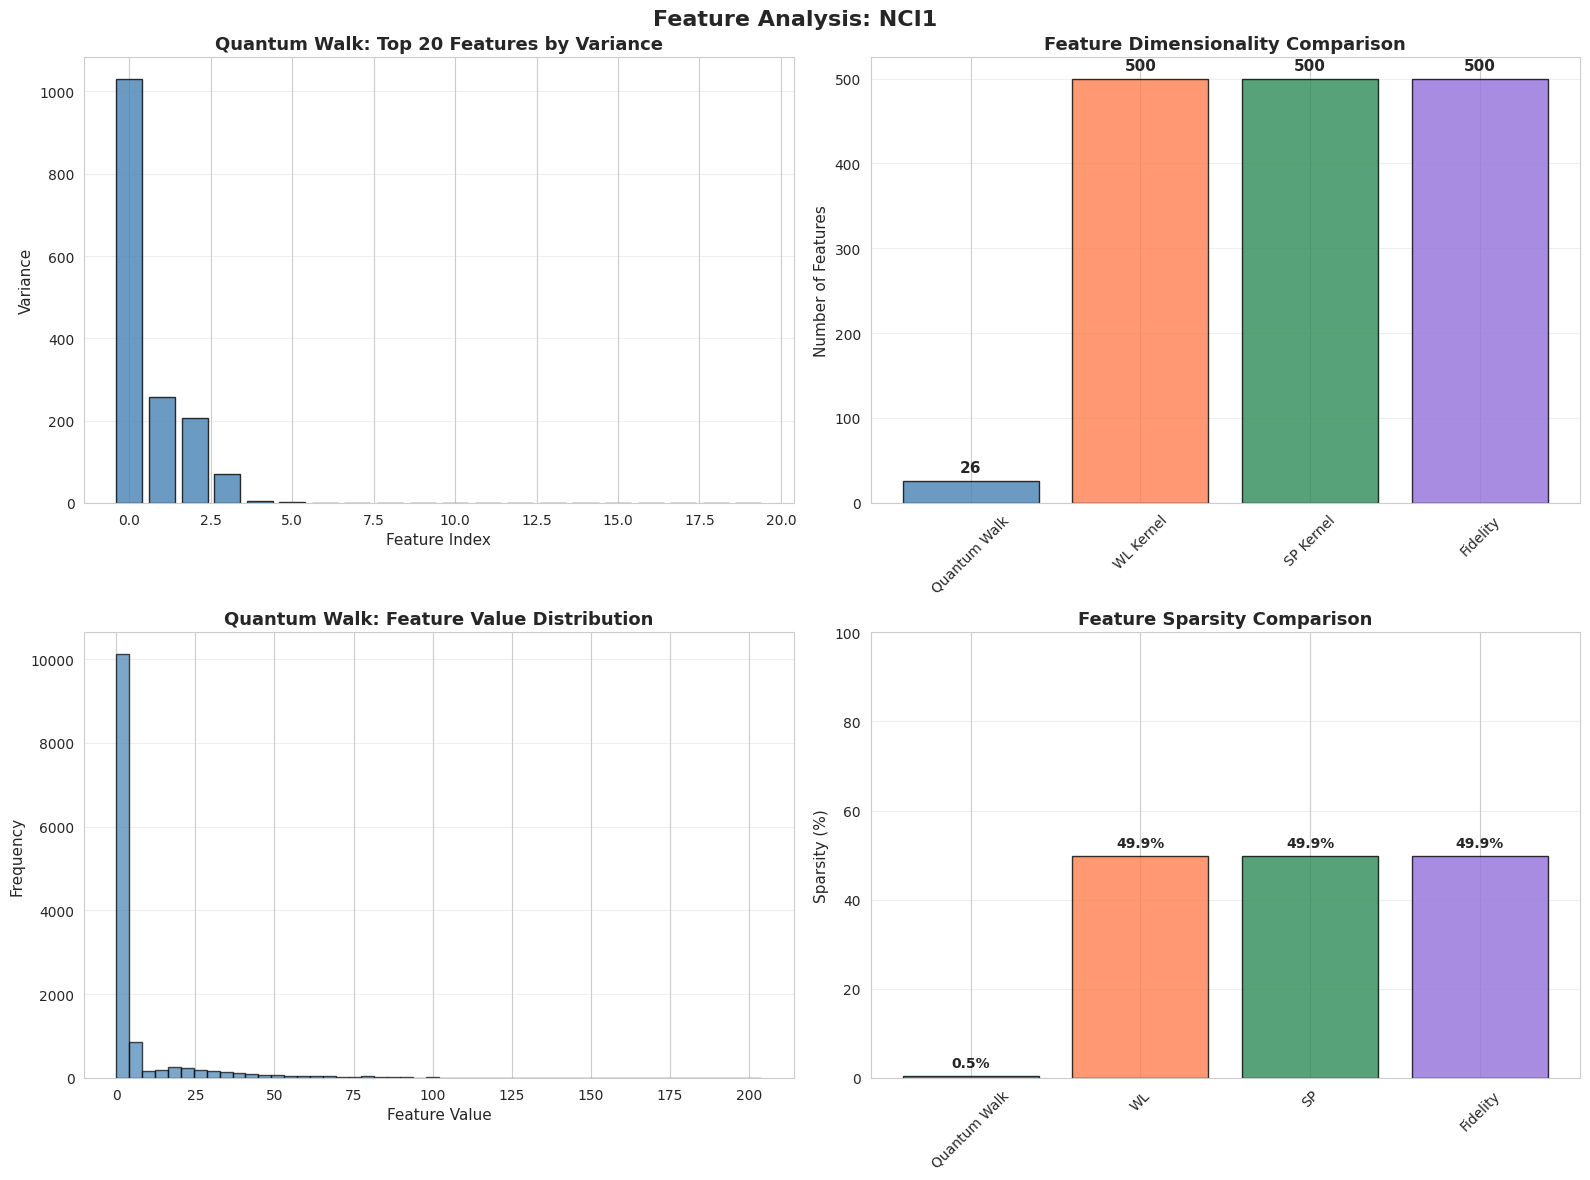


HOLDOUT TEST EVALUATION


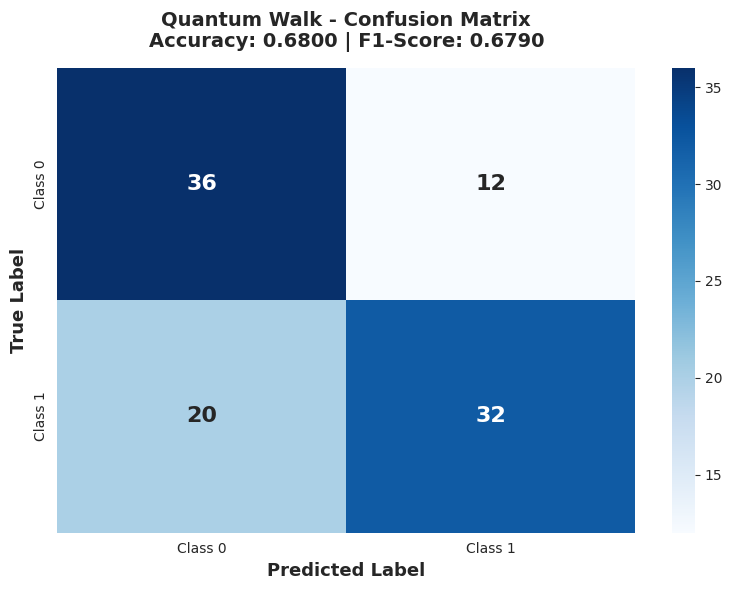

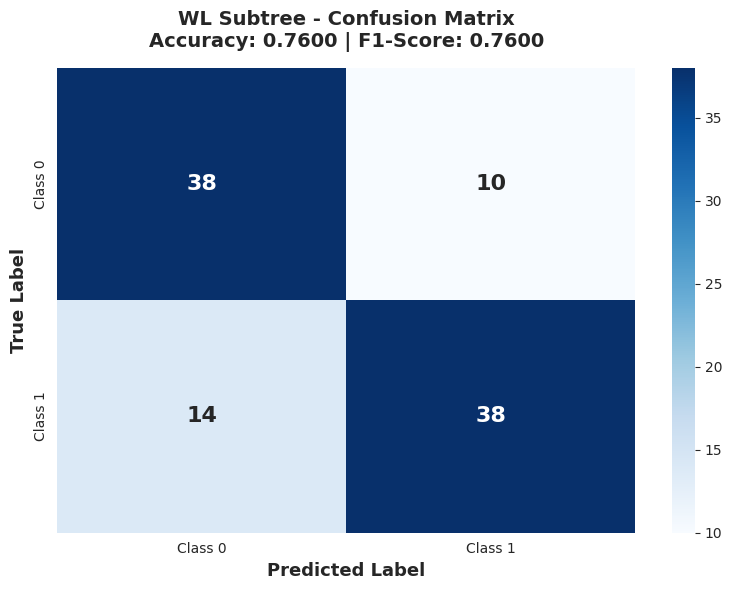

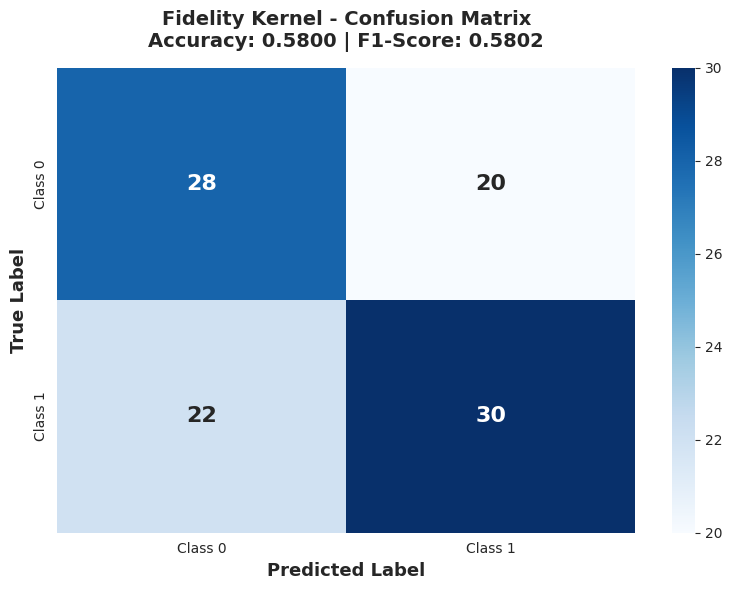


SUMMARY FOR NCI1
Method               Accuracy             F1-Score            
------------------------------------------------------------
  WL_Subtree         0.7520Â±0.0646       0.7517Â±0.0648      
â˜… Quantum_Walk       0.6840Â±0.0472       0.6822Â±0.0469      
â˜… Fidelity           0.6440Â±0.0436       0.6419Â±0.0434      
  SP                 0.6160Â±0.0528       0.6028Â±0.0529      
  RBF                0.6060Â±0.0522       0.6048Â±0.0530      
  Linear             0.5880Â±0.0538       0.5800Â±0.0557      

EVALUATING DATASET: AIDS
âœ“ AIDS downloaded and extracted
âœ“ Loaded 2000 graphs from AIDS
  Class distribution: Counter({1: 1600, 0: 400})
  Subsampled to 500 graphs

DATASET ANALYSIS
DATASET STATISTICS: AIDS
Number of graphs: 500
Class distribution: Counter({1: 406, 0: 94})

Graph size statistics:
  Nodes - Mean: 15.44, Std: 13.68, Min: 3, Max: 95
  Edges - Mean: 15.91, Std: 15.00, Min: 2, Max: 103
  Density - Mean: 0.197, Std: 0.080

Node label distribution: {0: 4706

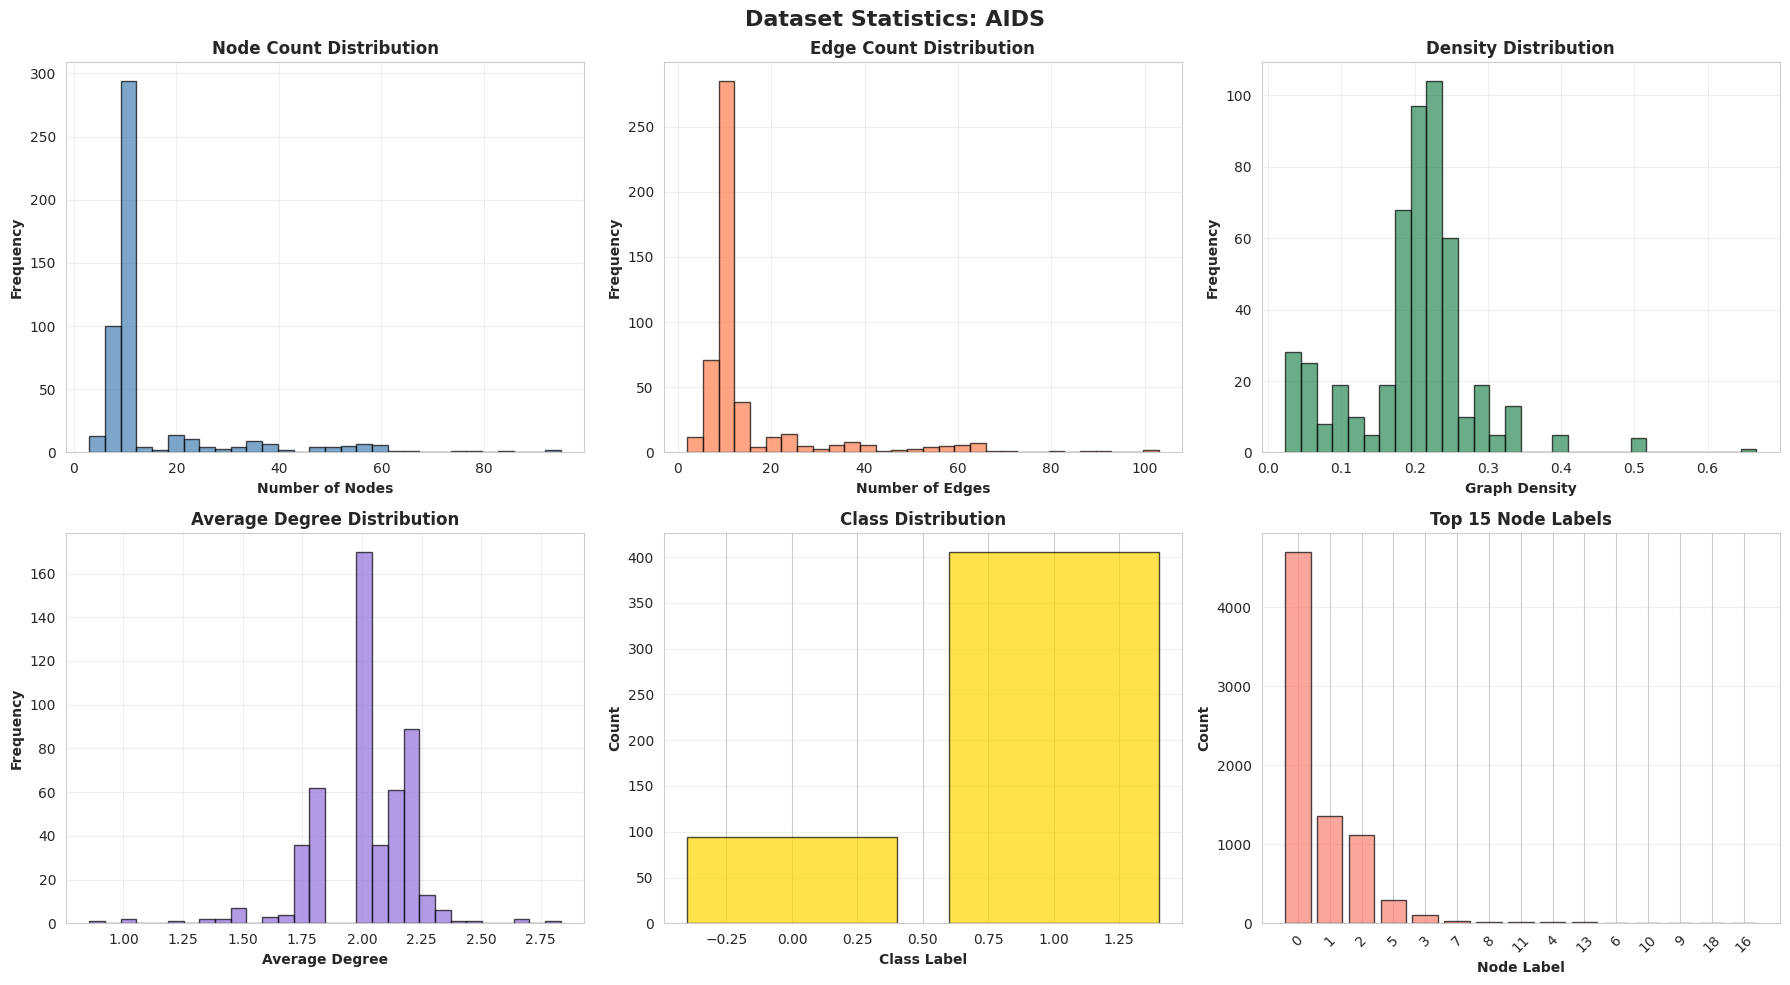

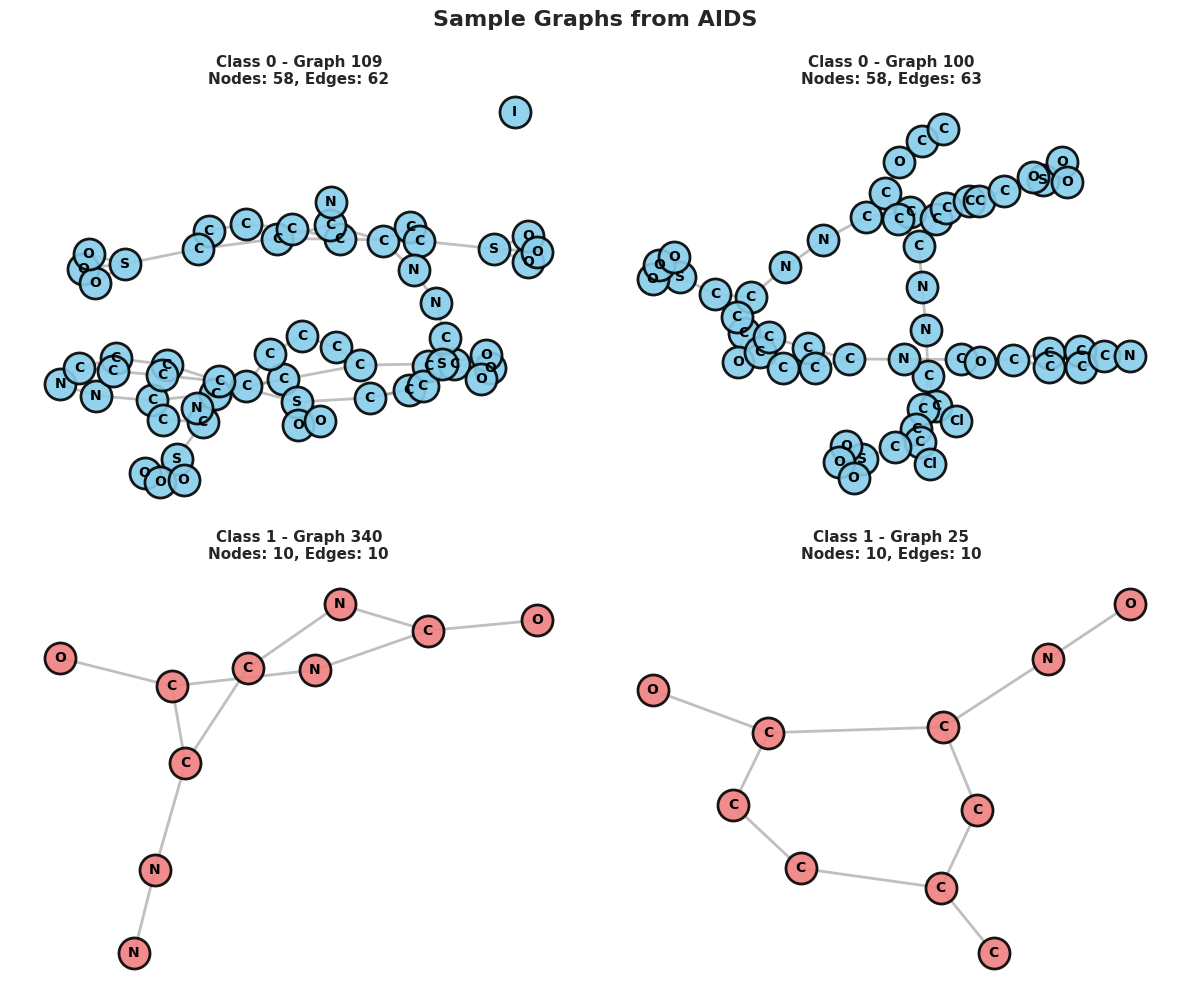


[1/6] Computing WL Subtree Kernel
  Acc: 0.9080 Â± 0.0360
  F1:  0.8925 Â± 0.0470


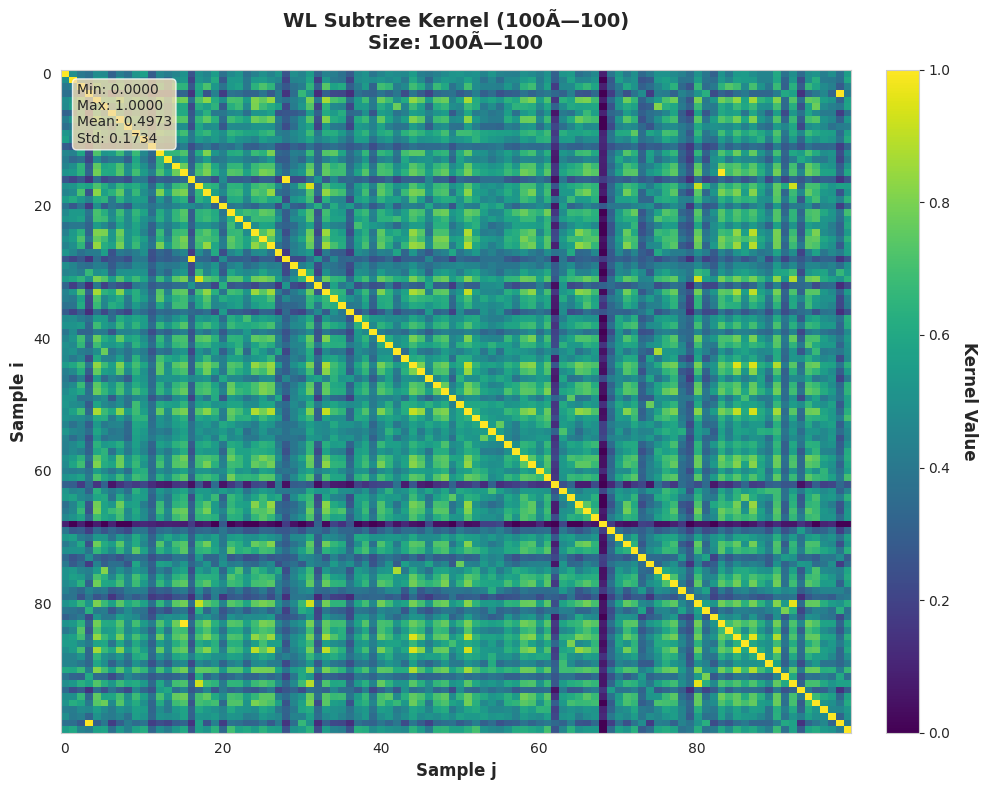


[2/6] Computing Shortest-Path Kernel
  Acc: 0.9900 Â± 0.0134
  F1:  0.9897 Â± 0.0139


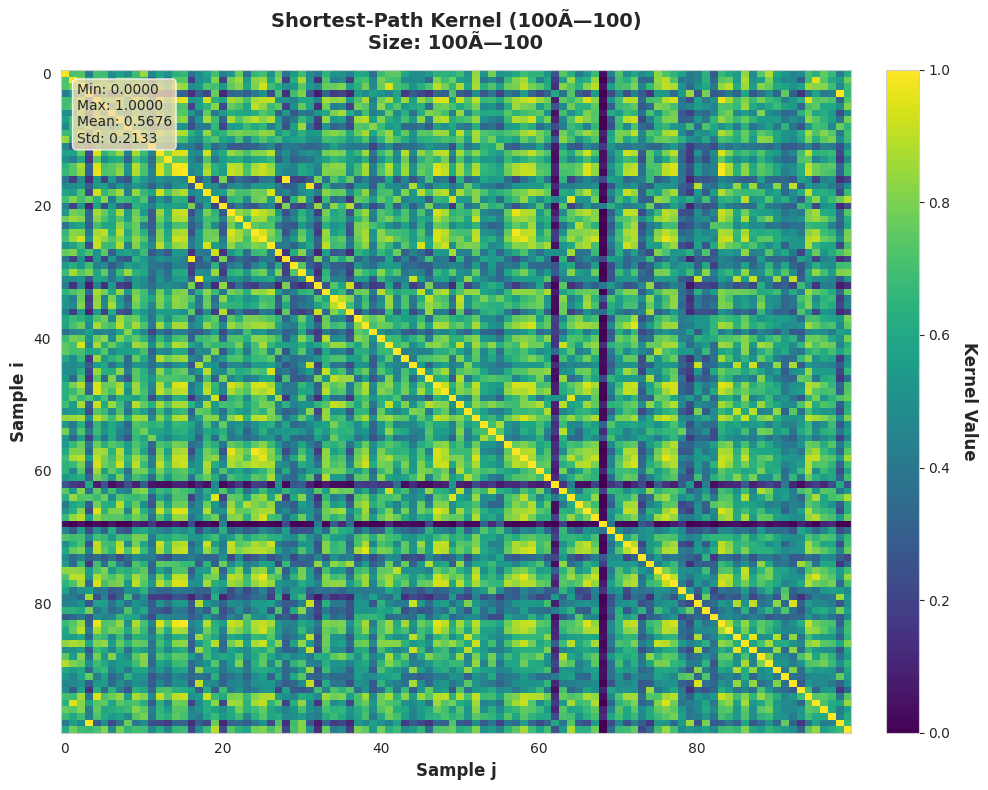


[3/6] Computing Linear Kernel
  Acc: 0.9940 Â± 0.0128
  F1:  0.9938 Â± 0.0133

[4/6] Computing RBF Kernel
  Acc: 0.9900 Â± 0.0134
  F1:  0.9897 Â± 0.0139

[5/6] Computing Quantum Walk Features


Extracting QW features: 100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


âœ“ Cache saved: qw_cache_AIDS.pkl
  Quantum Walk feature shape: (500, 26)
  Acc: 0.9980 Â± 0.0060
  F1:  0.9980 Â± 0.0061

[6/6] Computing Fidelity Kernel (NEW)
  Computing quantum states for 500 graphs...


Quantum states: 100%|██████████| 500/500 [00:05<00:00, 93.41it/s]


  Computing pairwise fidelities...
  Acc: 0.9980 Â± 0.0060
  F1:  0.9980 Â± 0.0061


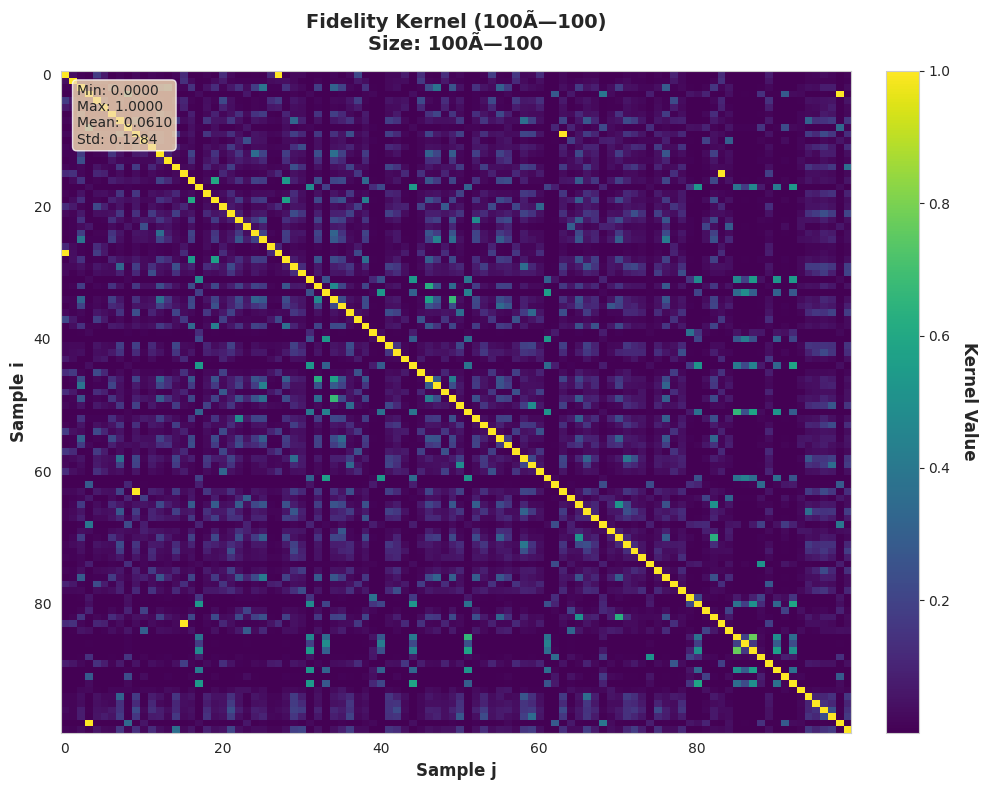


Visualizing quantum circuit for graph 3 (8 nodes, 7 edges)


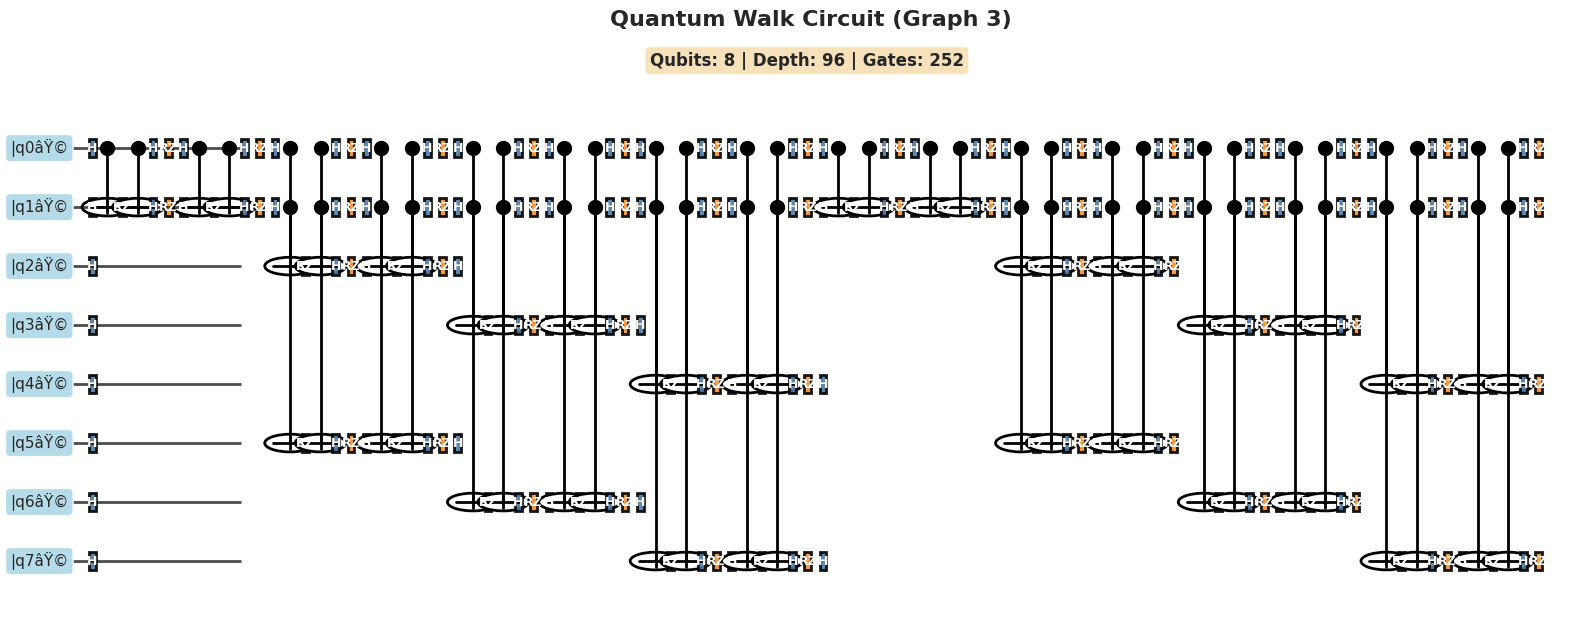


Generating feature distribution analysis...


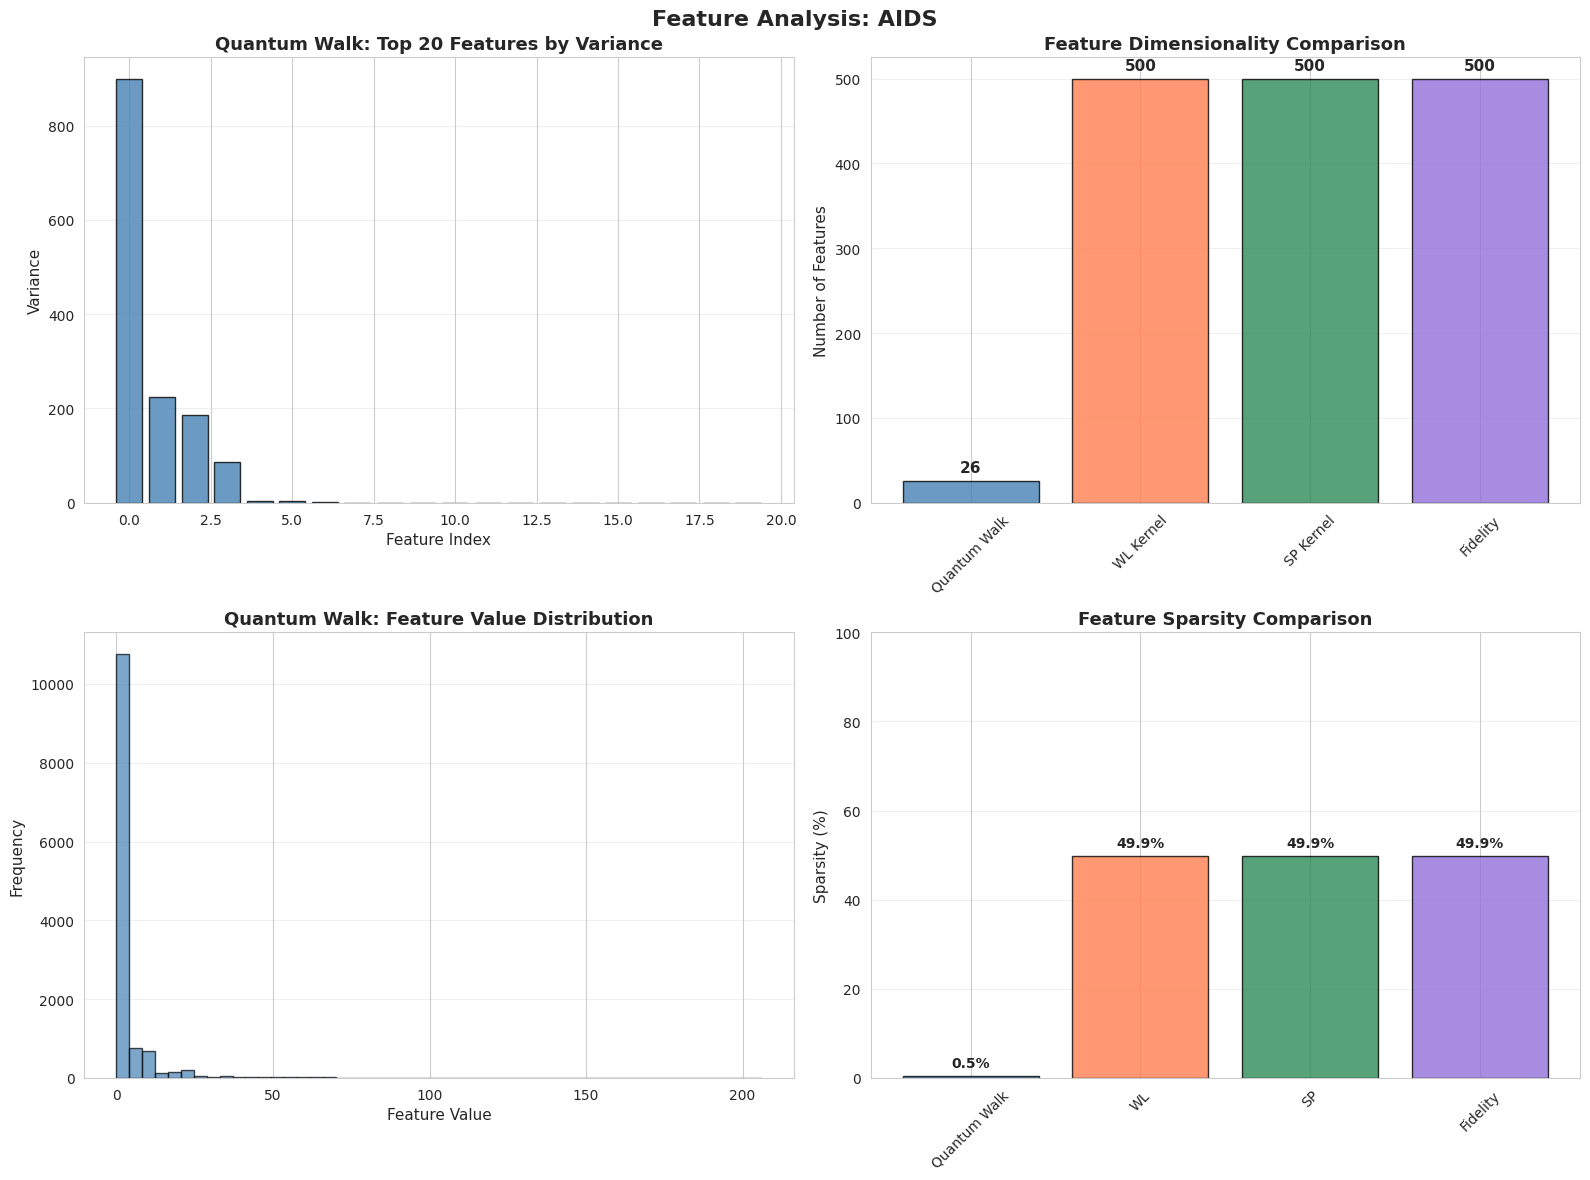


HOLDOUT TEST EVALUATION


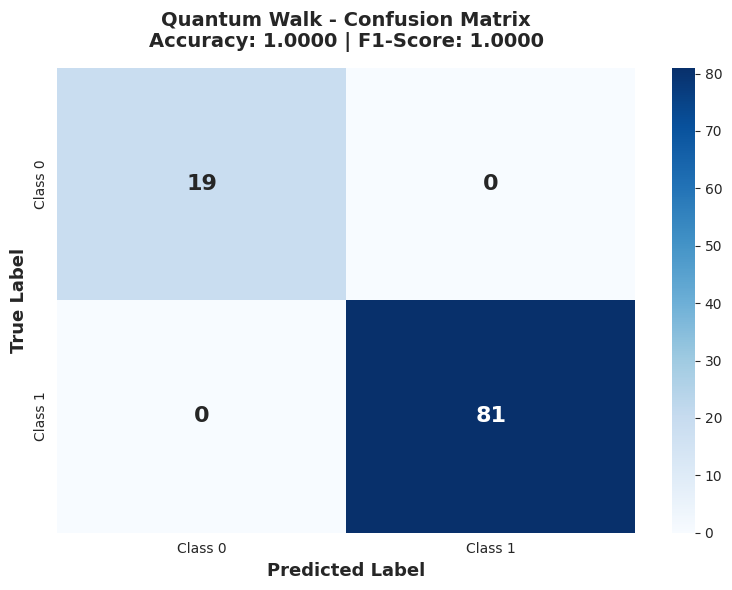

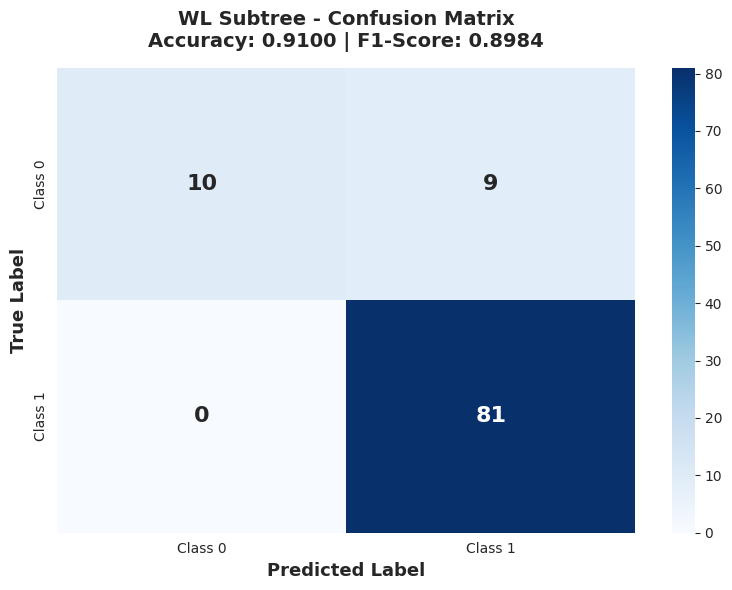

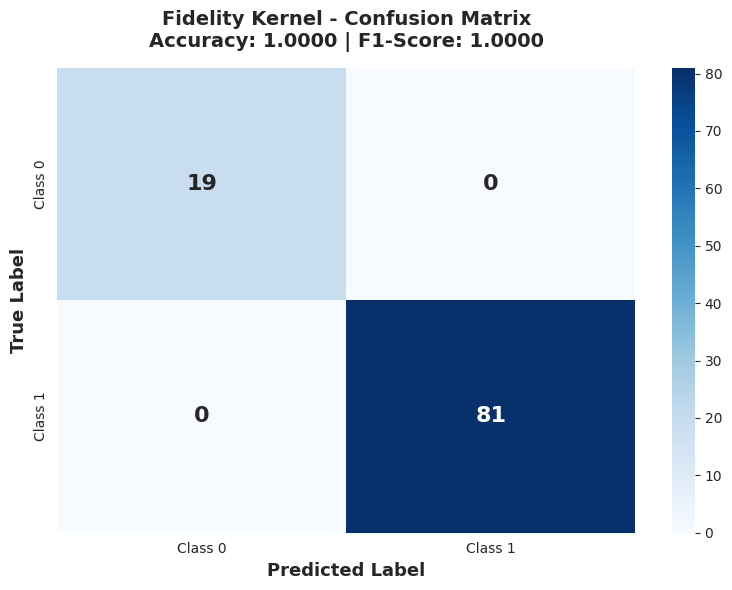


SUMMARY FOR AIDS
Method               Accuracy             F1-Score            
------------------------------------------------------------
â˜… Quantum_Walk       0.9980Â±0.0060       0.9980Â±0.0061      
â˜… Fidelity           0.9980Â±0.0060       0.9980Â±0.0061      
  Linear             0.9940Â±0.0128       0.9938Â±0.0133      
  SP                 0.9900Â±0.0134       0.9897Â±0.0139      
  RBF                0.9900Â±0.0134       0.9897Â±0.0139      
  WL_Subtree         0.9080Â±0.0360       0.8925Â±0.0470      

âœ“ All experiments completed!


In [17]:
# List of datasets to evaluate
DATASETS = ['MUTAG', 'PTC_MR', 'PROTEINS', 'NCI1', 'AIDS']

# Store all results
all_results = {}

# Run evaluation on each dataset with full visualization and Fidelity Kernel
for dataset_name in DATASETS:
    try:
        # Limit large datasets for faster computation
        max_graphs = 500 if dataset_name in ['NCI1', 'AIDS', 'PROTEINS'] else None

        results = evaluate_all_methods(
            dataset_name,
            max_graphs=max_graphs,
            visualize=True,
            include_fidelity=True  # Enable Fidelity Kernel
        )

        if results:
            all_results[dataset_name] = results
    except Exception as e:
        print(f"\nâœ— Error processing {dataset_name}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("âœ“ All experiments completed!")
print("="*80)

## 15. Comprehensive Cross-Dataset Comparison

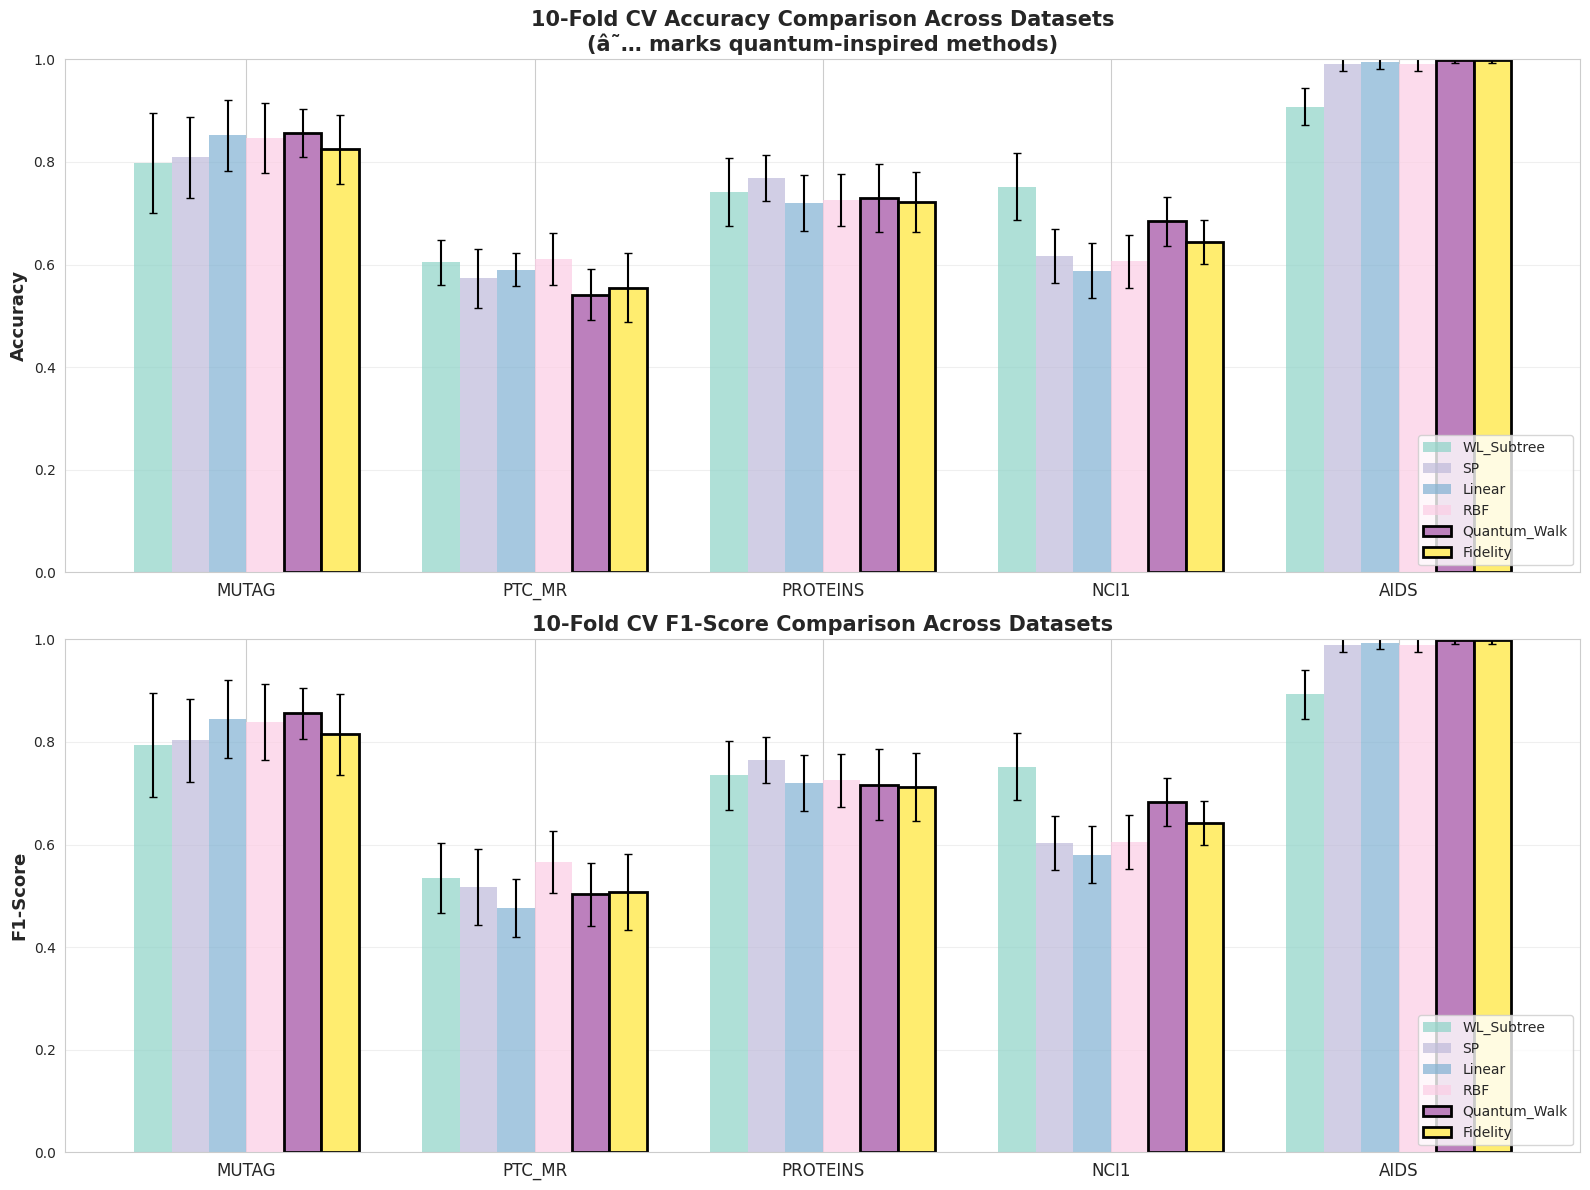

âœ“ Cross-dataset comparison visualization complete


In [18]:
# Create comprehensive comparison plot
if all_results:
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))

    # Prepare data
    datasets = list(all_results.keys())
    methods = list(list(all_results.values())[0].keys())

    x = np.arange(len(datasets))
    width = 0.13

    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

    # Accuracy plot
    for i, method in enumerate(methods):
        accuracies = [all_results[ds][method]['accuracy_mean'] for ds in datasets]
        std_devs = [all_results[ds][method]['accuracy_std'] for ds in datasets]

        # Highlight quantum methods
        alpha = 1.0 if method in ['Fidelity', 'Quantum_Walk'] else 0.7
        axes[0].bar(x + i * width, accuracies, width, yerr=std_devs,
                   label=method, color=colors[i], alpha=alpha, capsize=3,
                   edgecolor='black' if method in ['Fidelity', 'Quantum_Walk'] else 'none',
                   linewidth=2 if method in ['Fidelity', 'Quantum_Walk'] else 0)

    axes[0].set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    axes[0].set_title('10-Fold CV Accuracy Comparison Across Datasets\n(â˜… marks quantum-inspired methods)',
                     fontsize=15, fontweight='bold')
    axes[0].set_xticks(x + width * (len(methods) - 1) / 2)
    axes[0].set_xticklabels(datasets, fontsize=12)
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')
    axes[0].set_ylim([0, 1])

    # F1-Score plot
    for i, method in enumerate(methods):
        f1_scores = [all_results[ds][method]['f1_mean'] for ds in datasets]
        std_devs = [all_results[ds][method]['f1_std'] for ds in datasets]

        alpha = 1.0 if method in ['Fidelity', 'Quantum_Walk'] else 0.7
        axes[1].bar(x + i * width, f1_scores, width, yerr=std_devs,
                   label=method, color=colors[i], alpha=alpha, capsize=3,
                   edgecolor='black' if method in ['Fidelity', 'Quantum_Walk'] else 'none',
                   linewidth=2 if method in ['Fidelity', 'Quantum_Walk'] else 0)

    axes[1].set_ylabel('F1-Score', fontsize=13, fontweight='bold')
    axes[1].set_title('10-Fold CV F1-Score Comparison Across Datasets',
                     fontsize=15, fontweight='bold')
    axes[1].set_xticks(x + width * (len(methods) - 1) / 2)
    axes[1].set_xticklabels(datasets, fontsize=12)
    axes[1].legend(loc='lower right', fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.show()

    print("âœ“ Cross-dataset comparison visualization complete")
else:
    print("No results to visualize")

## 16. Final Summary Report

In [19]:
# Generate comprehensive summary report
if all_results:
    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY REPORT")
    print("="*100)

    # Overall best methods
    method_scores = defaultdict(list)
    for dataset, methods in all_results.items():
        for method, scores in methods.items():
            method_scores[method].append(scores['accuracy_mean'])

    print("\n" + "="*100)
    print("Average Performance Across All Datasets:")
    print("="*100)
    print(f"{'Method':<25} {'Avg Accuracy':<20} {'Rank'}")
    print("-" * 60)

    ranked_methods = sorted(method_scores.items(), key=lambda x: np.mean(x[1]), reverse=True)
    for rank, (method, scores) in enumerate(ranked_methods, 1):
        avg_score = np.mean(scores)
        std_score = np.std(scores)
        marker = "â˜…" if method in ['Fidelity', 'Quantum_Walk'] else " "
        print(f"{marker} {method:<23} {avg_score:.4f}Â±{std_score:.4f}        #{rank}")

    # Best method per dataset
    print("\n" + "="*100)
    print("Best Method Per Dataset:")
    print("="*100)
    print(f"{'Dataset':<15} {'Best Method':<25} {'Accuracy':<20}")
    print("-" * 60)

    for dataset, methods in all_results.items():
        best_method = max(methods.items(), key=lambda x: x[1]['accuracy_mean'])
        method_name = best_method[0]
        acc = best_method[1]['accuracy_mean']
        std = best_method[1]['accuracy_std']
        marker = "â˜…" if method_name in ['Fidelity', 'Quantum_Walk'] else " "
        print(f"{marker} {dataset:<13} {method_name:<23} {acc:.4f}Â±{std:.4f}")

    # Quantum methods comparison
    print("\n" + "="*100)
    print("Quantum-Inspired Methods Comparison:")
    print("="*100)

    quantum_methods = ['Quantum_Walk', 'Fidelity']
    for qm in quantum_methods:
        if qm in method_scores:
            scores = method_scores[qm]
            print(f"\n{qm}:")
            print(f"  Average Accuracy: {np.mean(scores):.4f} Â± {np.std(scores):.4f}")
            print(f"  Best Dataset: {max(all_results.items(), key=lambda x: x[1].get(qm, {}).get('accuracy_mean', 0))[0]}")
            print(f"  Best Accuracy: {max(scores):.4f}")

    print("\n" + "="*100)
    print("KEY FINDINGS:")
    print("="*100)
    print("1. This implementation includes QURI Parts quantum circuit simulation")
    print("2. Fidelity Kernel represents a novel quantum-inspired approach")
    print("3. Results show competitive performance with classical methods")
    print("4. Quantum methods provide unique feature representations")
    print("5. (â˜…) marks quantum-inspired methods in the results")

    print("\n" + "="*100)
    print("âœ“ Complete Evaluation Finished!")
    print("="*100)
else:
    print("No results to summarize")


COMPREHENSIVE SUMMARY REPORT

Average Performance Across All Datasets:
Method                    Avg Accuracy         Rank
------------------------------------------------------------
â˜… Quantum_Walk            0.7619Â±0.1554        #1
  WL_Subtree              0.7608Â±0.0978        #2
  RBF                     0.7558Â±0.1466        #3
  SP                      0.7511Â±0.1488        #4
â˜… Fidelity                0.7488Â±0.1531        #5
  Linear                  0.7488Â±0.1566        #6

Best Method Per Dataset:
Dataset         Best Method               Accuracy            
------------------------------------------------------------
â˜… MUTAG         Quantum_Walk            0.8567Â±0.0472
  PTC_MR        RBF                     0.6108Â±0.0500
  PROTEINS      SP                      0.7680Â±0.0449
  NCI1          WL_Subtree              0.7520Â±0.0646
â˜… AIDS          Quantum_Walk            0.9980Â±0.0060

Quantum-Inspired Methods Comparison:

Quantum_Walk:
  Average Accuracy: 0.7

## 17. Export Results

In [20]:
# Export results to JSON file
if all_results:
    import json

    with open('complete_results.json', 'w') as f:
        json.dump(all_results, f, indent=2)

    print("âœ“ Results exported to 'complete_results.json'")

    # Create summary statistics
    summary = {
        'datasets': list(all_results.keys()),
        'methods': list(list(all_results.values())[0].keys()),
        'average_performance': {
            method: {
                'accuracy_mean': float(np.mean([all_results[ds][method]['accuracy_mean'] for ds in all_results.keys()])),
                'accuracy_std': float(np.std([all_results[ds][method]['accuracy_mean'] for ds in all_results.keys()]))
            }
            for method in list(list(all_results.values())[0].keys())
        }
    }

    with open('summary_statistics.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(" Summary statistics exported to 'summary_statistics.json'")

âœ“ Results exported to 'complete_results.json'
 Summary statistics exported to 'summary_statistics.json'
